#### [The Dataset: TNG300-NewSAM](#1)
#### [Correlations Matrix](#2)
#### [Machine Learning (LR, RF & SVR) results - All morphologies (using the complete dataset) - Note: Only RF & LR analysis carried on; SVR not carried on because of the large dataset, have to address this analysis at a later time](#3)
#### [LR, RF, SVR figure](#4)
#### [Feature Ranking: All morphologies, add-on feature ranking using RF model](#5)
#### [Choose a subset of 10,000 galaxies to use with Symbolic Regression (SR). This subset should be representative of all morphologies in distribution.](#6)
#### [SR All morphologies](#7)
#### [SR by morphology: Define morphologies by increasing $\frac{M_{bulge}}{M_{star}}$ fraction](#8)
#### [SR by morphology: Group 1 Pure Disk Galaxies, $\frac{M_{bulge}}{M_{star}}$<0.1](#9)
#### [SR by morphology: Group 2 Disk Galaxies, 0.1<$\frac{M_{bulge}}{M_{star}}$<0.2](#10)

In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor

import target_predicting_ML_functions_and_feature_ranking as functions
import RF_target_predicting_and_learning_curves_functions as tp_lc_functions

In [2]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    fig, ax = plt.subplots(figsize=(7, 5))
#     plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("# of training examples",fontsize = 14)
 
    ax.set_ylabel("R2 score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    ax.legend(loc="best",fontsize = 12)
    return fig

## <font color='purple'> <a id =1> </a> <br> The Dataset: TNG300-NewSAM

#### Not-Normalized Dataset (Raw)

In [3]:
# Raw dataset from TNG300 Notebook v1,
# the version of dataset without non-physical galaxies whose Mstar/Mvir (GalpropNormMstar) > 0.2,
# and with stellar mass cut at log10Mstar>9.0
# and without fdisk<0.02 galaxies
df_not_normalized = pd.read_csv ('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphys_mstar9_and_diskgals_w_smallfdisk.csv') 

df_not_normalized = df_not_normalized.loc[:, :]
df_not_normalized.shape

(207467, 59)

#### Normalized Dataset

In [4]:
# Normalized (in better words, dimensionless) dataset from TNG300 Notebook v1: 
# all masses divided by halo mass (Mvir), halfmass radius divided by halo size (Rhalo);
# the version of dataset without non-physical galaxies whose Mstar/Mvir (GalpropNormMstar) > 0.2
# and with stellar mass cut at log10Mstar>9.0
# and without fdisk<0.02 galaxies
df_normalized_v1 = pd.read_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1_wo_mstar9_nonphys_and_diskgals_w_smallfdsik.csv')

# read the same file again
df_normalized_35 = pd.read_csv('TNG300-SAM_images/v1_TNG300-SAM_cleanup_normalize_dataset/TNG300-NewSAM_Normalized_Dataset_fromv1_wo_mstar9_nonphys_and_diskgals_w_smallfdsik.csv')

df_normalized_35.shape

(207467, 38)

In [5]:
df_normalized_v1.shape

(207467, 38)

In [6]:
df_normalized_35.columns.to_list()

['GalpropMaccdot_radio',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropSpin',
 'HalopropZhot',
 'BulgeMstar_ratio',
 'DiskMstar_ratio',
 'GalpropNormHalfRadius',
 'GalpropNormMstar',
 'HalopropNormMhot',
 'GalpropNormMbulge',
 'GalpropNormMdisk',
 'GalpropNormMBH',
 'GalpropNormMH2',
 'GalpropNormMHI',
 'GalpropNormMHII',
 'GalpropNormMcold',
 'GalpropNormMstar_merge',
 'HalopropNormMass_ejected',
 'HalopropNormMstar_diffuse',
 'GalpropNormSigmaBulge',
 'GalpropNormVdisk']

Note: From here on, only the normalized dataset is used for analysis.

## <font color='purple'> <a id =2> </a> <br> Correlations Matrix

In [7]:
import os
# os.mkdir('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk')

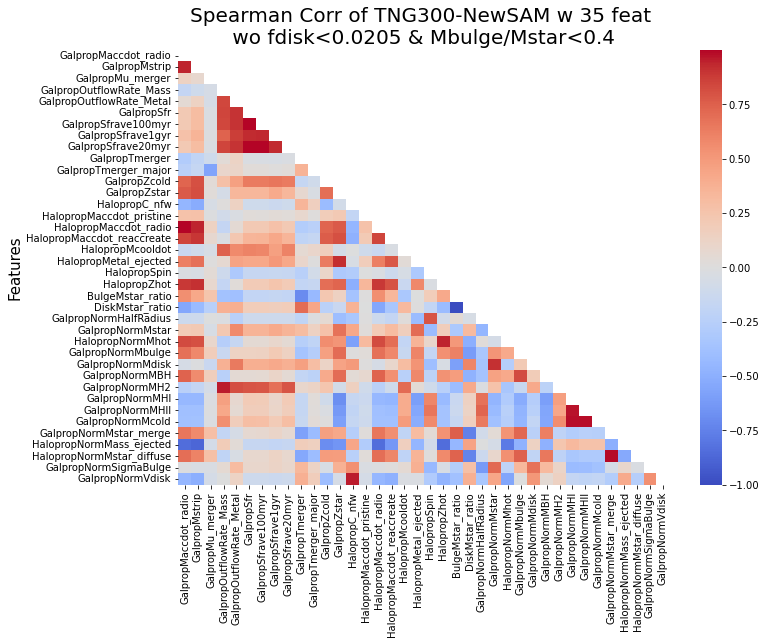

In [8]:
df_sample = df_normalized_35.sample(n = 100000, random_state = 2023)
corr_df = df_sample.corr('spearman')
plt.figure(figsize=(11,8))
matrix = np.triu(corr_df) # take upper correlation matrix
sns.heatmap(corr_df, cmap="coolwarm", mask=matrix)
plt.title("Spearman Corr of TNG300-NewSAM w 35 feat \n wo fdisk<0.0205 & Mbulge/Mstar<0.4 ", fontsize = 20)
plt.ylabel("Features", fontsize = 15)
# plt.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-SAM_Spearman_correlation_matrix_df_normalized_35.jpeg', dpi=500)
plt.show()

In [9]:
mass_size_corr_norm = round(stats.spearmanr(df_normalized_35['GalpropNormMstar'], 
                                               df_normalized_35['GalpropNormHalfRadius'])[0], 2)
SFR_size_corr_norm = round(stats.spearmanr(df_normalized_35['GalpropSfr'], 
                                              df_normalized_35['GalpropNormHalfRadius'] )[0], 2)
SFR_mass_corr_norm = round(stats.spearmanr(df_normalized_35['GalpropSfr'], 
                                              df_normalized_35['GalpropNormMstar'] )[0], 2)
spin_size_corr_norm = round(stats.spearmanr(df_normalized_35['HalopropSpin'], 
                                              df_normalized_35['GalpropNormHalfRadius'])[0], 2)
print('mass_size_corr_norm:', mass_size_corr_norm)
print('SFR_size_corr_norm:', SFR_size_corr_norm)
print('SFR_mass_corr_norm:', SFR_mass_corr_norm)
print('spin_size_corr_norm:', spin_size_corr_norm)

mass_size_corr_norm: -0.46
SFR_size_corr_norm: -0.12
SFR_mass_corr_norm: 0.35
spin_size_corr_norm: 0.8


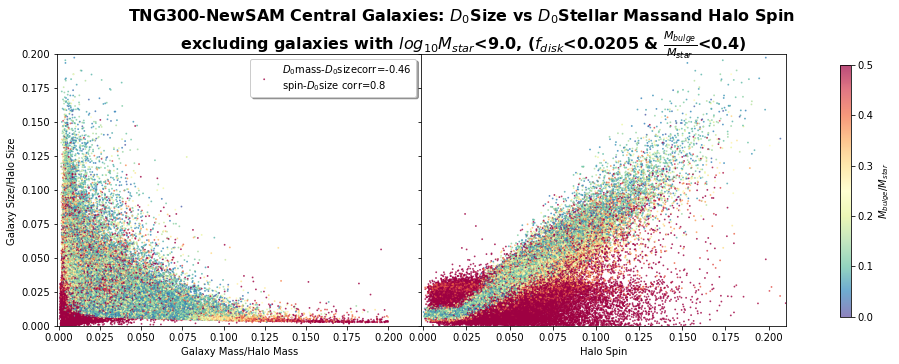

In [10]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
fig.suptitle(r'TNG300-NewSAM Central Galaxies: $D_{0}$Size vs $D_{0}$Stellar Mass' +'and Halo Spin \n ' + r'excluding galaxies with $log_{10}M_{star}$<9.0, ($f_{disk}$<0.0205 & $\frac{M_{bulge}}{M_{star}}$<0.4) ', 
             fontsize=16, fontweight='bold', y=1.01)
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = (r'$D_{0}$mass-$D_{0}$size' + 'corr=-0.46 \n'+ r'spin-$D_{0}$size corr=0.8')
im1 = ax1.scatter(df_normalized_35.loc[:, 'GalpropNormMstar'], df_normalized_35.loc[:, 'GalpropNormHalfRadius'], 
                  c = (df_normalized_35.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, label=label,
                  cmap='Spectral_r', vmin=0.0, vmax=0.5)

ax1.set_xlim([-0.001, 0.22])
# ax1.set_xticks([0.0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150])
ax1.set_ylim([0.0,0.2])
# ax1.set_title('Size vs Mass')
# ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_xlabel('Galaxy Mass/Halo Mass')
ax1.set_ylabel('Galaxy Size/Halo Size ')
ax1.legend(loc='upper right' , shadow=True)
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(df_normalized_35.loc[:, 'HalopropSpin'], df_normalized_35.loc[:, 'GalpropNormHalfRadius'], 
                    c = (df_normalized_35.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, 
                     cmap='Spectral_r', vmin=0.0, vmax=0.5)

     
ax2.set_xlim([-0.001,0.21])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
# ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')

# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax, label=r'$M_{bulge}/M_{star}$')

# plt.savefig("TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_NoDMass_NoDSize_Spin_wo_DISKgals_w_smallfdisk.jpeg", dpi=500)
plt.show()

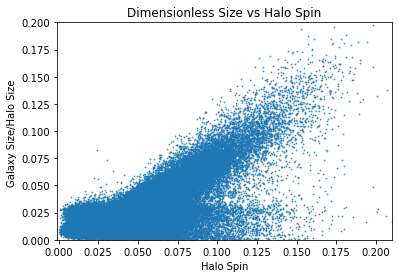

In [13]:
plt.scatter(df_normalized_35.loc[:, 'HalopropSpin'], df_normalized_35.loc[:, 'GalpropNormHalfRadius'], 
            s=3, marker='.', alpha=0.7)
    
plt.xlim([-0.001,0.21])
plt.ylim([0.0,0.2])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
# ax2.set_title('Size vs Spin')
plt.xlabel('Halo Spin')
plt.ylabel('Galaxy Size/Halo Size ')
plt.title('Dimensionless Size vs Halo Spin')
plt.show()


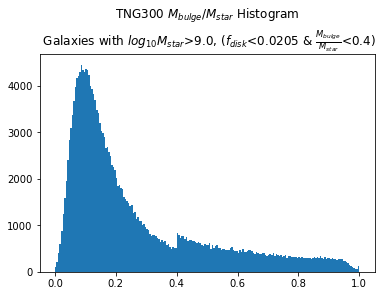

In [14]:
plt.hist(df_normalized_35.BulgeMstar_ratio, range=(0,1.0),bins=200)
plt.title(r'TNG300 $M_{bulge}/M_{star}$ Histogram' + '\n Galaxies with ' + r'$log_{10}M_{star}$>9.0, ($f_{disk}$<0.0205 & $\frac{M_{bulge}}{M_{star}}$<0.4)')
# plt.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_BulgeMstar_ratio_hist_wo_DISKgals_w_smallfdisk.jpeg', dpi=500)
plt.show()

In [15]:
df_normalized_35.shape

(207467, 38)

In [16]:
df_normalized_35[df_normalized_35.BulgeMstar_ratio>0.4].shape

(48966, 38)

In [17]:
(48966*100)/207467

23.601825832542044

## <font color='purple'> <a id =3> </a> <br> Machine Learning (LR, RF & SVR) results - All morphologies (using the complete dataset)

In [18]:
df_normalized_35.columns.to_list()

['GalpropMaccdot_radio',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropSpin',
 'HalopropZhot',
 'BulgeMstar_ratio',
 'DiskMstar_ratio',
 'GalpropNormHalfRadius',
 'GalpropNormMstar',
 'HalopropNormMhot',
 'GalpropNormMbulge',
 'GalpropNormMdisk',
 'GalpropNormMBH',
 'GalpropNormMH2',
 'GalpropNormMHI',
 'GalpropNormMHII',
 'GalpropNormMcold',
 'GalpropNormMstar_merge',
 'HalopropNormMass_ejected',
 'HalopropNormMstar_diffuse',
 'GalpropNormSigmaBulge',
 'GalpropNormVdisk']

In [19]:
# Drop 'BulgeMstar_ratio', 'GalpropNormMdisk', 'DiskMstar_ratio'; therefore remaining features to use are 35

X_all = df_normalized_35.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio', 'GalpropNormMdisk', 
                                        'DiskMstar_ratio'])


y_all = df_normalized_35.loc[:,'GalpropNormHalfRadius']

### Random Forest - RF

Note: Update the grid to search for best model. Here the already known best model is used (in order to reduce time required to run the line)

In [28]:
# This block of code takes ~1.3 hrs to run with ~207,000 galaxies (with only one model and 5-fold cross validation)

start_time = time.time()
regr_RF = RandomForestRegressor(random_state=0)


# # number of trees in random forest
# n_estimators = [20,50,100]
# # create random grid
# grid = {'bootstrap': [True],
#                'max_depth': [5, 10, None],
# #                'max_features': ['auto', 'sqrt'],
#                'min_samples_leaf': [1, 2, 4],
# #                'min_samples_split': [2, 5, 10],
#                'n_estimators': n_estimators}

n_estimators = [100]
# create random grid
grid = {'bootstrap': [True],
               'max_depth': [None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [2],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}

# Grid search of parameters
rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(rfr_grid.best_score_), \
    rfr_grid.best_params_)
# define trainscore according to best model
best_RF=rfr_grid.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

best_RF_trainscore=rfr_grid.cv_results_['mean_train_score'][rfr_grid.best_index_]

# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_RF = cross_val_predict(best_RF, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))

# find prediction scores of each of the cross validation fold
scores_RF = cross_val_score(best_RF, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))
print("RF Accuracy: %0.2f (+/- %0.2f)" % (scores_RF.mean(), scores_RF.std() * 2))

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute RF on complete dataset: {elapsed_time:.3f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params, best score: 0.9627 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
RF Accuracy: 0.96 (+/- 0.01)
Elapsed time to compute RF on complete dataset: 4706.665 seconds


Fitting 5 folds for each of 1 candidates, totalling 5 fits

    Best params, best score: 0.9627 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
    RF Accuracy: 0.96 (+/- 0.01)
    Elapsed time to compute RF on complete dataset: 4706.665 seconds

In [29]:
y_pred_RF

array([0.01549819, 0.02441535, 0.01840741, ..., 0.02883958, 0.03141294,
       0.02536937])

In [30]:
y_pred_RF_df = pd.DataFrame({'y_pred_RF': y_pred_RF})

In [31]:
# y_pred_RF_df.to_csv('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_y_pred_RF_predicted_sizes.csv', index=False)

In [20]:
# y_pred_RF = pd.read_csv('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_y_pred_RF_predicted_sizes.csv')

Elapsed time to run RF Learning Curves on the complete dataset: 862.521 seconds


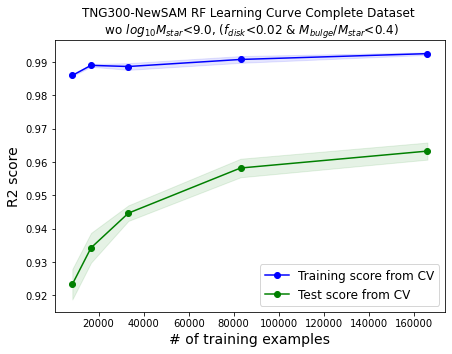

In [48]:
# this code takes ~862 seconds to run on the whole dataset with ~207,000 galaxies
start_time = time.time()

lc_all_rf = plot_learning_curve(best_RF, 'TNG300-NewSAM RF Learning Curve Complete Dataset \n wo' + r' $log_{10}M_{star}$<9.0, ($f_{disk}$<0.02 & $M_{bulge}/M_{star}$<0.4)', X_all, y_all, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_LC_RF_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

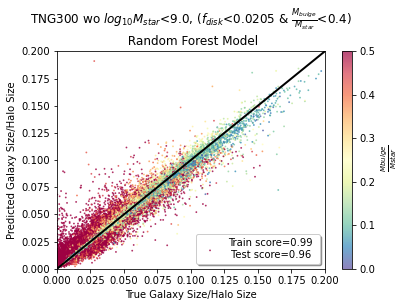

In [37]:

label = ('Train score=0.99 \n Test score=0.96')
plt.scatter(df_normalized_35.loc[:, 'GalpropNormHalfRadius'], y_pred_RF, s=3, marker='.', alpha=0.7, label=label,
                 c = df_normalized_35.loc[:, 'BulgeMstar_ratio'],cmap='Spectral_r', vmin=0.0, vmax=0.5)
# ax5.set_xlim(auto=True)
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim(auto=True)
plt.axis([0.0,0.2, 0.0,0.2])
plt.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
plt.title(r'TNG300 wo $log_{10}M_{star}$<9.0, ($f_{disk}$<0.0205 & $\frac{M_{bulge}}{M_{star}}$<0.4)' + '\n Random Forest Model')
plt.xlabel('True Galaxy Size/Halo Size')
plt.ylabel('Predicted Galaxy Size/Halo Size')
plt.legend(loc='lower right', shadow=True)
plt.colorbar(label=r' $\frac{Mbulge}{Mstar}$')

# plt.savefig("TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_RF_size_prediction_35feat_MbulgeMstar.jpeg", dpi=500)
plt.show()

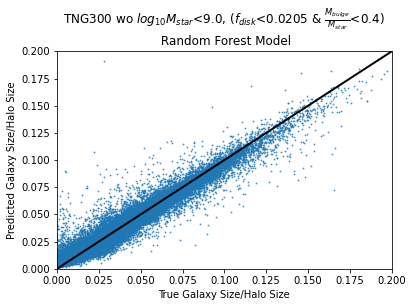

In [39]:

label = ('Train score=0.99 \n Test score=0.94')
plt.scatter(df_normalized_35.loc[:, 'GalpropNormHalfRadius'], y_pred_RF, s=3, marker='.', alpha=0.7) #, 
#             label=label, c = df_normalized_35.loc[:, 'BulgeMstar_ratio'],cmap='Spectral_r', vmin=0.0, vmax=0.5)
# ax5.set_xlim(auto=True)
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim(auto=True)
plt.axis([0.0,0.2, 0.0,0.2])
plt.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
plt.title(r'TNG300 wo $log_{10}M_{star}$<9.0, ($f_{disk}$<0.0205 & $\frac{M_{bulge}}{M_{star}}$<0.4)' + '\n Random Forest Model')
plt.xlabel('True Galaxy Size/Halo Size')
plt.ylabel('Predicted Galaxy Size/Halo Size')
# plt.legend(loc='lower right', shadow=True)
# plt.colorbar(label=r' $\frac{Mbulge}{Mstar}$')

# plt.savefig("TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_RF_size_prediction_35feat_nocolorcode.jpeg", dpi=500)
plt.show()

#### Distribution of RF predicted sizes vs true sizes

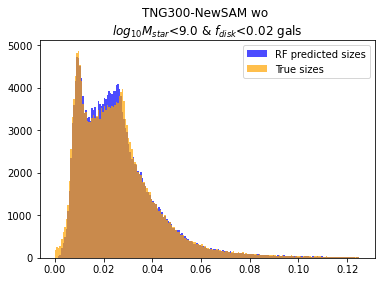

In [46]:
plt.hist(y_pred_RF, color='blue', label='RF predicted sizes', range=(0,0.125), bins=200, alpha=0.7)
plt.hist(df_normalized_35.loc[:, 'GalpropNormHalfRadius'],  color='orange', 
         label='True sizes', alpha=0.7, range=(0,0.125), bins=200)
plt.title('TNG300-NewSAM wo \n' + r'$log_{10}M_{star}$<9.0, ($f_{disk}$<0.0205 & $\frac{M_{bulge}}{M_{star}}$<0.4) gals')
plt.legend()
# plt.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_RFpredicted_vs_True_size_distribution.jpeg', dpi=500)
plt.show()

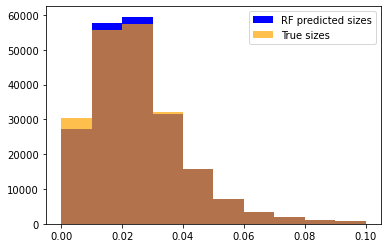

In [47]:
plt.hist(y_pred_RF, color='blue', label='RF predicted sizes', range=(0,0.1))
plt.hist(df_normalized_35.loc[:, 'GalpropNormHalfRadius'],  color='orange', 
         label='True sizes', alpha=0.7, range=(0,0.1))
plt.legend()
plt.show()

### Linear Regression - LR

Note: Update to use the same style like in RF and SVR where cv is applied to all dataset, not just X_test, y_test

In [30]:
reg = LinearRegression() # choose the model: Linear Regression
reg.fit(X_all, y_all) # fit the data to the chosen model
# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_LR = cross_val_predict(reg, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))
# find prediction scores of each of the cross validation fold
scores_reg = cross_validate(reg, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10),
                           return_train_score=True)
print("LR Accuracy: %0.2f (+/- %0.2f)" % (scores_reg['test_score'].mean(), scores_reg['test_score'].std() * 2))

LR Accuracy: 0.67 (+/- 0.07)


Elapsed time to run SVR Learning Curves on the complete dataset: 1.101 seconds


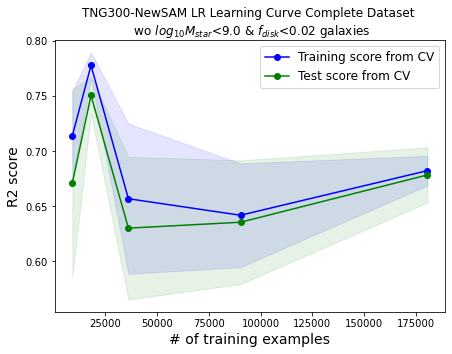

In [37]:
# this code takes ~1.3seconds to run on the whole dataset with ~273,000 galaxies
start_time = time.time()

lc_all_lr = plot_learning_curve(reg, 'TNG300-NewSAM LR Learning Curve Complete Dataset \n wo' + r'$log_{10}M_{star}$<9.0, ($f_{disk}$<0.0205 & $\frac{M_{bulge}}{M_{star}}$<0.4) gals', X_all, y_all, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_LC_SVR_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

### Support Vector Regressor - SVR

<font color='darkred'> Note: ~270,000 galaxies is a too big dataset to run the SVR with in my computer. In order to reduce the time required for searching for an optimal model, we decided to randomly choose 20,000-40,000 galaxies from this dataset and only use the first ~20 most important features (instead of the all the 35 ones; see below for Add-feature Feature Ranking analysis) to run the SVR with.

In [ ]:
df_sample_all = df_normalized_35.sample(n = 100000, random_state = 2023)


In [ ]:
# Drop 'BulgeMstar_ratio', 'GalpropNormMdisk', 'DiskMstar_ratio'; therefore remaining features to use are 35
# Drop the other ~15 least important features (from feature ranking analysis below)

X_sample_all = df_sample_all.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio', 'GalpropNormMdisk', 
                                        'DiskMstar_ratio'])


y_sample_all = df_sample_all.loc[:,'GalpropNormHalfRadius']

In [61]:
# this code takes ~ 4.3 hrs to run it on the complete dataset with ~273,000 galaxies 
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.0001, 0.001, 0.01, 0.1, 1.0, 100], 'svr__C':[0.1, 1.0, 100, 1000], \
              }


model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_all.fit(X_sample_all, y_sample_all)

print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to search for the best SVR model on Complete Dataset: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params, best score: -2.7593 {'svr__C': 100, 'svr__gamma': 0.0001, 'svr__kernel': 'rbf'}
Elapsed time to search for the best SVR model on Complete Dataset: 111.571 seconds


Parameters used:
parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 0.1, 1.0, 100], 'svr__C':[0.1, 1.0, 100, 1000]}

model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)
                     
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params, best score: 0.9069 {'svr__C': 1000, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to search for the best SVR model on Complete Dataset: 15603.734 seconds

In [57]:
# this code takes ~ 31 min to run it on the complete dataset with ~273,000 galaxies 
start_time = time.time()

best_SVR_all=model_all.best_estimator_

best_SVR_trainscore_all=model_all.cv_results_['mean_train_score'][model_all.best_index_]

scores_SVR_all = cross_val_score(best_SVR_all, X_sample_all, y_sample_all, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data

elapsed_time = time.time() - start_time
print(f"Elapsed time to calculate SVR scores with 5-fold CV: {elapsed_time:.3f} seconds")

Elapsed time to calculate SVR scores with 5-fold CV: 5.607 seconds


In [58]:
# this code takes ~ 31 min to run it on the complete dataset with ~273,000 galaxies 
start_time = time.time()
y_pred_SVR_all = cross_val_predict(best_SVR_all, X_sample_all, y_sample_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))
elapsed_time = time.time() - start_time
print(f"Elapsed time to calculate y_pred_SVR_all with 5-fold CV: {elapsed_time:.3f} seconds")

Elapsed time to calculate y_pred_SVR_all with 5-fold CV: 5.599 seconds


In [61]:
y_pred_SVR_all_df = pd.DataFrame({'y_pred_SVR_all': y_pred_SVR_all})

y_pred_SVR_all_df.to_csv('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_y_pred_SVR_all_predicted_sizes.csv', index=False)

Elapsed time to run SVR Learning Curves on the complete dataset: 3670.561 seconds


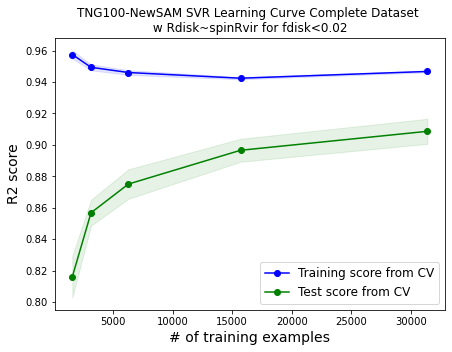

In [62]:
# this code takes ~1,2 hrs to run on the whole dataset with ~273,000 galaxies
start_time = time.time()

lc_all_svr = plot_learning_curve(best_SVR_all, 'TNG300-NewSAM SVR Learning Curve Complete Dataset \n '+r'wo $log_{10}M_{star}$<9.0, ($f_{disk}$<0.0205 & $\frac{M_{bulge}}{M_{star}}$<0.4) gals', X_sample_all, y_sample_all, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
plt.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_LC_SVR_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on randomly sampled 30,000 gals & 20 most important features: {elapsed_time:.3f} seconds")

## <font color='purple'> <a id =4> </a> <br> LR, RF, SVR figure

NameError: name 'best_SVR_trainscore_all' is not defined

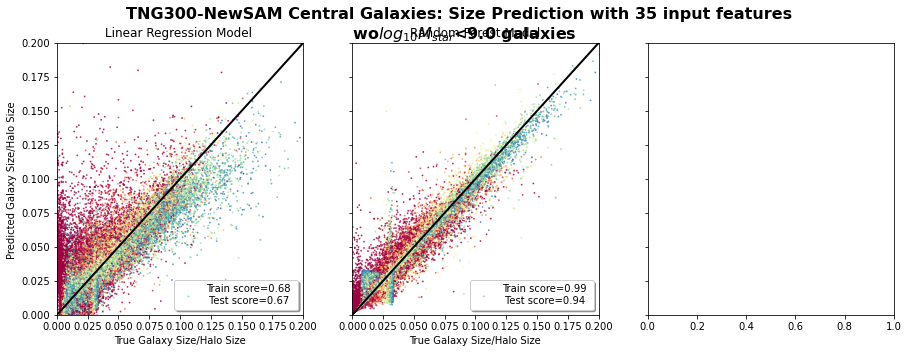

In [38]:
fig1,[ax1, ax5, ax6 ]=plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))
fig1.suptitle('TNG300-NewSAM Central Galaxies: Size Prediction with 35 input features \n wo' + r'wo $log_{10}M_{star}$<9.0, ($f_{disk}$<0.0205 & $\frac{M_{bulge}}{M_{star}}$<0.4) galaxies', 
              fontsize=16,fontweight='bold', y=1.01)
# plt.subplots_adjust(hspace=1.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(scores_reg['train_score'].mean(), 2),round(scores_reg['test_score'].mean(), 2) )# print(label)
im1 = ax1.scatter(y_all, y_pred_LR, s=3, marker='.', alpha=0.7, label=label,
                 c = df_normalized_35.loc[:, 'BulgeMstar_ratio'],cmap='Spectral_r', vmin=0.0, vmax=0.5)
# cmap='Spectral_r'since ellipticals are red, disks are blue in color from observations
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.0,0.2, 0.0,0.2])
ax1.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model ')
ax1.set_xlabel('True Galaxy Size/Halo Size')
ax1.set_ylabel('Predicted Galaxy Size/Halo Size ')
ax1.legend(loc='lower right', shadow=True)


label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
im5 = ax5.scatter(y_all, y_pred_RF, s=3, marker='.', alpha=0.7, label=label,
                 c = df_normalized_35.loc[:, 'BulgeMstar_ratio'],cmap='Spectral_r', vmin=0.0, vmax=0.5)
# ax5.set_xlim(auto=True)
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim(auto=True)
ax5.axis([0.0,0.2, 0.0,0.2])
ax5.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
ax5.set_title('Random Forest Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_all, 2),round(scores_SVR_all.mean(), 2) )
im6 = ax6.scatter(y_all, y_pred_SVR_all, s=3, marker='.', alpha=0.7, label=label,
                 c = df_normalized_35.loc[:, 'BulgeMstar_ratio'],cmap='Spectral_r', vmin=0.0, vmax=0.5)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.0,0.2, 0.0,0.2])
ax6.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
ax6.set_title('Support Vector Regressor')
ax6.set_xlabel('True Galaxy Size/Halo Size')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
cbar_ax = fig1.add_axes([0.92, 0.14, 0.01, 0.67])
fig1.colorbar(im6, cax=cbar_ax, label=r' $\frac{Mbulge}{Mstar}$')
# fig1.colorbar(im6, ax=ax6, label=r' $\frac{Mbulge}{Mstar}$')
  
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

fig1.subplots_adjust(top=1.0, hspace=2.0, wspace=0.03)
# fig1.tight_layout()
# fig1.savefig("TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_LR_RF_SVR_size_prediction_35feat_MbulgeMstar.jpeg", dpi=500)
plt.show()

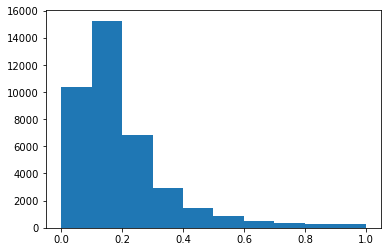

In [66]:
plt.hist(df_normalized_35.loc[:, 'BulgeMstar_ratio'])
plt.show()

## <font color='purple'> <a id =5> </a> <br> Feature Ranking: All morphologies, add-on feature ranking using RF model

In [23]:
df_sample_all = df_normalized_35.sample(n = 100000, random_state = 2023)


In [24]:
# Drop 'BulgeMstar_ratio', 'GalpropNormMdisk', 'DiskMstar_ratio'; therefore remaining features to use are 35
# Drop the other ~15 least important features (from feature ranking analysis below)

X_sample_all = df_sample_all.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio', 'GalpropNormMdisk', 
                                        'DiskMstar_ratio'])


y_sample_all = df_sample_all.loc[:,'GalpropNormHalfRadius']

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.9565 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
RF Accuracy: 0.96 (+/- 0.01)


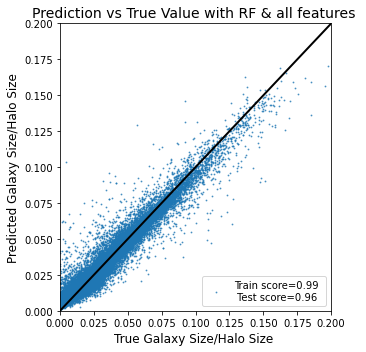

Elapsed time to compute the importances: 0.089 seconds
Elapsed time to compute the importances: 170.587 seconds


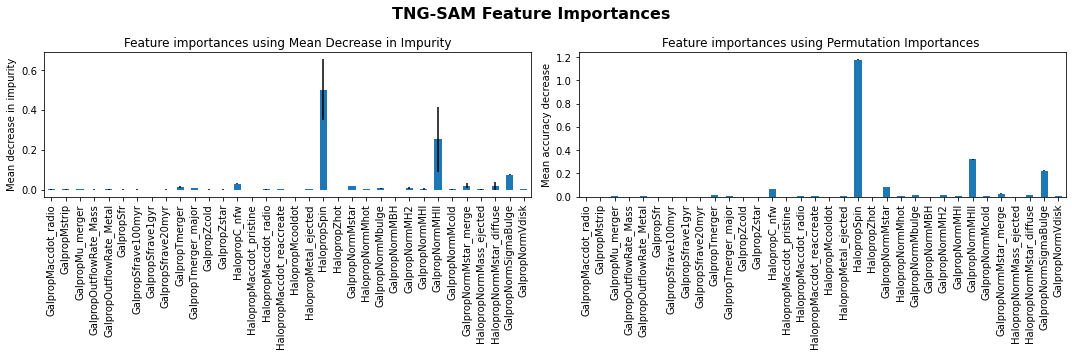

  0%|                                                    | 0/34 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▎                                          | 1/34 [00:13<07:39, 13.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▌                                         | 2/34 [00:37<10:35, 19.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▉                                        | 3/34 [01:07<12:26, 24.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▏                                      | 4/34 [01:31<12:07, 24.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▍                                     | 5/34 [01:56<11:51, 24.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|███████▊                                    | 6/34 [02:23<11:52, 25.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████                                   | 7/34 [02:50<11:35, 25.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▎                                 | 8/34 [03:16<11:16, 26.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▋                                | 9/34 [03:41<10:36, 25.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▋                              | 10/34 [03:55<08:50, 22.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▉                             | 11/34 [04:06<07:10, 18.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▏                           | 12/34 [04:34<07:51, 21.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▍                          | 13/34 [04:58<07:45, 22.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▋                         | 14/34 [05:22<07:36, 22.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▉                        | 15/34 [05:39<06:39, 21.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▏                      | 16/34 [05:51<05:30, 18.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 17/34 [06:16<05:43, 20.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▊                    | 18/34 [06:34<05:13, 19.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████                   | 19/34 [06:58<05:13, 20.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▎                 | 20/34 [07:16<04:40, 20.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▌                | 21/34 [07:37<04:26, 20.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▊               | 22/34 [08:00<04:14, 21.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████              | 23/34 [08:19<03:45, 20.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▎            | 24/34 [08:42<03:31, 21.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▌           | 25/34 [08:46<02:25, 16.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▉          | 26/34 [09:08<02:22, 17.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████▏        | 27/34 [09:30<02:13, 19.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▍       | 28/34 [09:51<01:58, 19.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▋      | 29/34 [10:14<01:42, 20.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▉     | 30/34 [10:36<01:24, 21.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████▏   | 31/34 [10:59<01:04, 21.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▍  | 32/34 [11:12<00:37, 18.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▋ | 33/34 [11:34<00:20, 20.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 34/34 [11:57<00:00, 21.10s/it]


1. iteration: 
	 1 HalopropSpin 0.652298282114003


  0%|                                                    | 0/33 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▎                                          | 1/33 [00:35<18:45, 35.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▋                                         | 2/33 [01:12<18:50, 36.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████                                        | 3/33 [01:45<17:24, 34.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▎                                      | 4/33 [02:22<17:15, 35.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▋                                     | 5/33 [02:59<16:54, 36.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|████████                                    | 6/33 [03:33<15:53, 35.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▎                                  | 7/33 [04:06<15:03, 34.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▋                                 | 8/33 [04:40<14:20, 34.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|████████████                                | 9/33 [05:14<13:41, 34.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████                              | 10/33 [05:43<12:33, 32.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 11/33 [06:08<11:06, 30.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▋                           | 12/33 [06:46<11:22, 32.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▉                          | 13/33 [07:19<10:57, 32.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▏                        | 14/33 [07:49<10:09, 32.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▌                       | 15/33 [08:18<09:18, 31.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 16/33 [08:50<08:49, 31.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 17/33 [09:28<08:52, 33.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.028, test=0.025) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.033, test=0.025) total time=   4.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.048, test=0.014) total time=   3.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.054, test=0.052) total time=   3.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.297, test=-0.145) total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.297, test=-0.122) total time=   6.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.007, test=0.003) total time=   1.8s
[CV 1/3]

 55%|███████████████████████▍                   | 18/33 [09:57<08:01, 32.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.027, test=0.027) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.033, test=0.024) total time=   2.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.047, test=0.013) total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.047, test=0.014) total time=   4.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.054, test=0.052) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.072, test=0.049) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.071, test=0.051) total time=   6.5s
[CV 3/3] END

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.028, test=0.025) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.033, test=0.025) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.033, test=0.025) total time=   2.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.047, test=0.014) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.054, test=0.052) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.073, test=0.050) total time=   3.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.303, test=-0.134) total time=   7.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimator

 58%|████████████████████████▊                  | 19/33 [10:35<07:52, 33.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████                 | 20/33 [11:08<07:15, 33.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.027, test=0.027) total time=   3.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.033, test=0.024) total time=   4.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.054, test=0.052) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.054, test=0.052) total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.293, test=-0.132) total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.305, test=-0.136) total time=  11.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.007, test=0.002) total time=   1.8s
[CV 3/3] E

 64%|███████████████████████████▎               | 21/33 [11:41<06:42, 33.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.028, test=0.025) total time=   3.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.047, test=0.013) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.048, test=0.014) total time=   2.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.054, test=0.053) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.071, test=0.050) total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.073, test=0.050) total time=   6.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.007, test=0.003) total time=   0.7s
[CV 3/3] END 

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.028, test=0.026) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.033, test=0.024) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.033, test=0.024) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.033, test=0.024) total time=   4.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.054, test=0.053) total time=   3.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.072, test=0.050) total time=   6.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.008, test=0.002) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=

 67%|████████████████████████████▋              | 22/33 [12:18<06:20, 34.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.027, test=0.027) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.028, test=0.025) total time=   3.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.046, test=0.013) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.048, test=0.014) total time=   4.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.054, test=0.052) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.071, test=0.051) total time=   3.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.291, test=-0.129) total time=   2.9s
[CV 2/3] E

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.028, test=0.025) total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.033, test=0.024) total time=   2.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.046, test=0.014) total time=   2.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.054, test=0.052) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.071, test=0.050) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.073, test=0.050) total time=   3.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.299, test=-0.123) total time=   6.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimator

 70%|█████████████████████████████▉             | 23/33 [12:55<05:52, 35.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▎           | 24/33 [13:29<05:13, 34.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▌          | 25/33 [14:00<04:29, 33.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▉         | 26/33 [14:37<04:02, 34.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▏       | 27/33 [15:13<03:31, 35.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▍      | 28/33 [15:50<02:57, 35.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▊     | 29/33 [16:26<02:23, 35.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████    | 30/33 [17:03<01:48, 36.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▍  | 31/33 [17:39<01:12, 36.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▋ | 32/33 [18:15<00:36, 36.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 33/33 [18:49<00:00, 34.23s/it]


2. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049


  0%|                                                    | 0/32 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/32 [00:51<26:28, 51.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 2/32 [01:43<26:01, 52.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████▏                                       | 3/32 [02:36<25:14, 52.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 4/32 [03:28<24:26, 52.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|██████▉                                     | 5/32 [04:21<23:37, 52.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▎                                   | 6/32 [05:08<21:52, 50.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▋                                  | 7/32 [06:01<21:23, 51.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 8/32 [06:54<20:46, 51.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▍                               | 9/32 [07:47<20:01, 52.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▍                             | 10/32 [08:36<18:45, 51.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 34%|██████████████▊                            | 11/32 [09:20<17:11, 49.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▏                          | 12/32 [10:13<16:44, 50.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▍                         | 13/32 [11:06<16:10, 51.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▊                        | 14/32 [11:58<15:25, 51.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▏                      | 15/32 [12:44<14:06, 49.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 16/32 [13:36<13:24, 50.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▊                    | 17/32 [14:29<12:48, 51.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████▏                  | 18/32 [15:18<11:46, 50.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▌                 | 19/32 [16:11<11:07, 51.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 20/32 [17:04<10:20, 51.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.750, test=0.740) total time=   2.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.792, test=0.725) total time=   4.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.890, test=0.697) total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.892, test=0.715) total time=  12.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.733, test=0.722) total time=   5.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.780, test=0.731) total time=   9.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.676, test=0.665) total time=   5.6s
[CV 1/3] EN

 66%|████████████████████████████▏              | 21/32 [17:50<09:10, 50.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.736, test=0.728) total time=   5.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.906, test=0.693) total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.907, test=0.703) total time=   8.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.674, test=0.665) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.672, test=0.651) total time=   5.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.882, test=0.612) total time=   3.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.888, test=0.614) total time=  14.0s
[CV 2/3]

 69%|█████████████████████████████▌             | 22/32 [18:42<08:28, 50.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.746, test=0.750) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.786, test=0.751) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.792, test=0.738) total time=   4.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.894, test=0.689) total time=   8.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.734, test=0.727) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.780, test=0.734) total time=   4.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.909, test=0.698) total time=   8.8s
[CV 3/3] END b

 72%|██████████████████████████████▉            | 23/32 [19:35<07:43, 51.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.900, test=0.673) total time=   8.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.685, test=0.662) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.684, test=0.679) total time=   5.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.886, test=0.619) total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.891, test=0.637) total time=  14.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.685, test=0.667) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.727, test=0.678) total time=   4.8s
[CV 1/3] EN

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.676, test=0.659) total time=   5.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.723, test=0.647) total time=   9.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.711, test=0.697) total time=   5.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.762, test=0.708) total time=  10.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.686, test=0.663) total time=   2.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.733, test=0.676) total time=   4.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.884, test=0.629) total time=   3.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estima

 75%|████████████████████████████████▎          | 24/32 [20:27<06:51, 51.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▌         | 25/32 [21:19<06:01, 51.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.896, test=0.665) total time=   3.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.899, test=0.667) total time=  14.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.686, test=0.663) total time=   5.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.883, test=0.631) total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.889, test=0.635) total time=   8.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.680, test=0.681) total time=   5.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.886, test=0.607) total time=   3.4s
[CV 3

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.765, test=0.699) total time=   9.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.900, test=0.674) total time=  13.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.683, test=0.678) total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.731, test=0.674) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.733, test=0.678) total time=   4.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.892, test=0.625) total time=   8.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.680, test=0.680) total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

 81%|██████████████████████████████████▉        | 26/32 [22:11<05:10, 51.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.712, test=0.702) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.763, test=0.703) total time=   4.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.894, test=0.667) total time=   3.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.901, test=0.670) total time=  13.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.686, test=0.676) total time=   5.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.733, test=0.679) total time=   9.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.684, test=0.658) total time=   5.7s
[CV 3/3] EN

 84%|████████████████████████████████████▎      | 27/32 [23:02<04:18, 51.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 28/32 [23:55<03:27, 51.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|██████████████████████████████████████▉    | 29/32 [24:48<02:36, 52.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▎  | 30/32 [25:40<01:44, 52.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▋ | 31/32 [26:25<00:50, 50.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 32/32 [27:17<00:00, 51.18s/it]


3. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686


  0%|                                                    | 0/31 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/31 [00:57<28:48, 57.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 2/31 [02:05<30:50, 63.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▎                                       | 3/31 [03:12<30:30, 65.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 4/31 [04:20<29:49, 66.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 5/31 [05:28<28:56, 66.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▌                                   | 6/31 [06:36<27:57, 67.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|█████████▉                                  | 7/31 [07:43<26:51, 67.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▎                                | 8/31 [08:50<25:46, 67.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▊                               | 9/31 [09:58<24:41, 67.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▊                             | 10/31 [11:01<23:10, 66.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                           | 11/31 [12:01<21:25, 64.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▋                          | 12/31 [13:09<20:40, 65.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████                         | 13/31 [14:17<19:49, 66.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▍                       | 14/31 [15:24<18:47, 66.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 15/31 [16:24<17:14, 64.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 16/31 [17:31<16:16, 65.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▌                   | 17/31 [18:39<15:23, 65.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▉                  | 18/31 [19:42<14:07, 65.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▎                | 19/31 [20:49<13:10, 65.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▋               | 20/31 [21:57<12:09, 66.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 21/31 [23:04<11:05, 66.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▌            | 22/31 [24:11<09:59, 66.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▉           | 23/31 [25:10<08:36, 64.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████▎         | 24/31 [26:22<07:46, 66.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.838, test=0.791) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.837, test=0.795) total time=  14.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.776, test=0.770) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.826, test=0.778) total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.825, test=0.784) total time=   7.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.934, test=0.758) total time=  11.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.773, test=0.771) total time=   8.3s
[CV 1/3] END b

 81%|██████████████████████████████████▋        | 25/31 [27:34<06:50, 68.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.934, test=0.749) total time=  19.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.782, test=0.778) total time=   4.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.837, test=0.792) total time=   7.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.939, test=0.778) total time=  12.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.776, test=0.771) total time=   4.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.824, test=0.782) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.830, test=0.775) total time=  14.8s
[CV 1/3] END

 84%|████████████████████████████████████       | 26/31 [28:56<06:02, 72.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.933, test=0.760) total time=  11.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.782, test=0.777) total time=   8.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.935, test=0.773) total time=   4.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.938, test=0.779) total time=  11.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.775, test=0.757) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.829, test=0.772) total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.827, test=0.780) total time=  14.6s
[CV 3/3] E

 87%|█████████████████████████████████████▍     | 27/31 [30:14<04:56, 74.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.780, test=0.764) total time=   4.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.825, test=0.791) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.828, test=0.780) total time=  14.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.771, test=0.757) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.823, test=0.773) total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.820, test=0.781) total time=   7.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.934, test=0.759) total time=  12.1s
[CV 2/3] END bo

 90%|██████████████████████████████████████▊    | 28/31 [31:25<03:38, 72.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▏  | 29/31 [32:32<02:22, 71.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.771, test=0.766) total time=   4.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.825, test=0.775) total time=   7.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.929, test=0.761) total time=   4.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.935, test=0.761) total time=  19.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.773, test=0.765) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.828, test=0.770) total time=   2.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.833, test=0.775) total time=  14.6s
[CV 3/3] END

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.933, test=0.754) total time=   4.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.936, test=0.770) total time=  11.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.789, test=0.775) total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.840, test=0.795) total time=   6.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.939, test=0.772) total time=   4.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.940, test=0.787) total time=  18.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.780, test=0.774) total time=   6.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_est

 97%|█████████████████████████████████████████▌ | 30/31 [33:39<01:09, 69.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.781, test=0.761) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.775, test=0.768) total time=   8.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.932, test=0.755) total time=   4.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.938, test=0.760) total time=  19.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.786, test=0.784) total time=   3.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.835, test=0.801) total time=   6.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.940, test=0.780) total time=  10.9s
[CV 2/3] EN

100%|███████████████████████████████████████████| 31/31 [34:46<00:00, 67.29s/it]


4. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826


  0%|                                                    | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/30 [01:32<44:51, 92.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|██▉                                         | 2/30 [03:06<43:29, 93.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 3/30 [04:39<41:58, 93.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▊                                      | 4/30 [06:13<40:27, 93.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 5/30 [07:46<38:50, 93.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 6/30 [09:19<37:19, 93.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▎                                 | 7/30 [10:52<35:44, 93.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▋                                | 8/30 [12:25<34:09, 93.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 9/30 [13:58<32:35, 93.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 10/30 [15:28<30:40, 92.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▊                           | 11/30 [16:53<28:29, 89.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 12/30 [18:26<27:16, 90.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▋                        | 13/30 [19:59<25:56, 91.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████                       | 14/30 [21:31<24:24, 91.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 15/30 [22:56<22:24, 89.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▉                    | 16/30 [24:27<21:02, 90.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 17/30 [26:00<19:42, 90.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 18/30 [27:29<18:02, 90.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████▏               | 19/30 [29:02<16:41, 91.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 20/30 [30:34<15:15, 91.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████             | 21/30 [32:07<13:46, 91.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▌           | 22/30 [33:39<12:14, 91.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|████████████████████████████████▉          | 23/30 [35:11<10:44, 92.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 24/30 [36:42<09:10, 91.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 25/30 [38:15<07:39, 91.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▎     | 26/30 [39:47<06:08, 92.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▋    | 27/30 [41:19<04:36, 92.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████▏  | 28/30 [42:53<03:04, 92.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.824, test=0.816) total time=   2.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.827, test=0.794) total time=  11.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.961, test=0.852) total time=   6.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.964, test=0.856) total time=  24.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.839, test=0.831) total time=   5.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.918, test=0.878) total time=   9.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.969, test=0.881) total time=   5.8s
[CV 2/3] EN

 97%|█████████████████████████████████████████▌ | 29/30 [44:13<01:28, 88.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 30/30 [45:45<00:00, 91.51s/it]


5. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.896, test=0.836) total time=   9.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.961, test=0.853) total time=  14.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.828, test=0.796) total time=   5.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.897, test=0.861) total time=   9.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.962, test=0.854) total time=  14.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.839, test=0.819) total time=  10.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.917, test=0.888) total time=  18.5s
[CV 2/3] END

  3%|█▍                                         | 1/29 [01:49<50:53, 109.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|██▉                                        | 2/29 [03:38<49:12, 109.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                      | 3/29 [05:28<47:32, 109.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.969, test=0.881) total time=  14.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.826, test=0.817) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.910, test=0.868) total time=   3.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.910, test=0.882) total time=  17.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.965, test=0.869) total time=  20.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.820, test=0.815) total time=   5.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.893, test=0.851) total time=   3.8s
[CV 2/3] END

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.964, test=0.857) total time=  24.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.821, test=0.818) total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.894, test=0.857) total time=   3.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.897, test=0.851) total time=  19.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.963, test=0.832) total time=  22.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.819, test=0.810) total time=  11.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.960, test=0.851) total time=   5.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_e

 14%|█████▉                                     | 4/29 [07:19<45:50, 110.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.962, test=0.849) total time=  24.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.822, test=0.817) total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.901, test=0.860) total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.901, test=0.854) total time=   9.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.963, test=0.855) total time=  14.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.827, test=0.810) total time=  11.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.961, test=0.848) total time=   5.9s
[CV 3/3] E

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.824, test=0.819) total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.905, test=0.861) total time=   3.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.906, test=0.854) total time=  19.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.962, test=0.860) total time=  21.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.824, test=0.801) total time=   4.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.895, test=0.849) total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.895, test=0.854) total time=  17.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimator

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.840, test=0.831) total time=  10.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.968, test=0.871) total time=   5.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.970, test=0.884) total time=  13.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.831, test=0.814) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.910, test=0.881) total time=   3.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.910, test=0.872) total time=   8.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.967, test=0.864) total time=  13.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimat

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.919, test=0.878) total time=  18.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.971, test=0.885) total time=  21.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.832, test=0.815) total time=   9.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.910, test=0.872) total time=  17.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.821, test=0.815) total time=  11.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.896, test=0.853) total time=  19.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.827, test=0.817) total time=   5.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estima

 17%|███████▍                                   | 5/29 [09:09<44:03, 110.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|████████▉                                  | 6/29 [11:00<42:17, 110.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▍                                | 7/29 [12:51<40:30, 110.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|███████████▊                               | 8/29 [14:41<38:39, 110.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▎                             | 9/29 [16:32<36:50, 110.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 34%|██████████████▍                           | 10/29 [18:19<34:39, 109.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|███████████████▉                          | 11/29 [20:01<32:12, 107.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▍                        | 12/29 [21:52<30:42, 108.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|██████████████████▊                       | 13/29 [23:42<29:03, 108.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▎                     | 14/29 [25:31<27:12, 108.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|█████████████████████▋                    | 15/29 [27:14<24:59, 107.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▏                  | 16/29 [29:03<23:18, 107.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|████████████████████████▌                 | 17/29 [30:53<21:40, 108.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████                | 18/29 [32:39<19:45, 107.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 66%|███████████████████████████▌              | 19/29 [34:30<18:05, 108.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|████████████████████████████▉             | 20/29 [36:19<16:19, 108.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▍           | 21/29 [38:09<14:31, 109.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|███████████████████████████████▊          | 22/29 [39:59<12:45, 109.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▎        | 23/29 [41:48<10:54, 109.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|██████████████████████████████████▊       | 24/29 [43:37<09:05, 109.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▏     | 25/29 [45:26<07:16, 109.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|█████████████████████████████████████▋    | 26/29 [47:16<05:28, 109.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████   | 27/29 [49:07<03:39, 109.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|████████████████████████████████████████▌ | 28/29 [50:56<01:49, 109.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|██████████████████████████████████████████| 29/29 [52:44<00:00, 109.14s/it]


6. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▌                                         | 1/28 [02:04<55:55, 124.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███                                        | 2/28 [04:10<54:17, 125.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▌                                      | 3/28 [06:15<52:12, 125.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████▏                                    | 4/28 [08:20<50:00, 125.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.848, test=0.824) total time=   6.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.934, test=0.905) total time=   4.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.934, test=0.908) total time=  23.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.840, test=0.836) total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.842, test=0.831) total time=  13.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.977, test=0.903) total time=   6.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.977, test=0.911) total time=  29.3s
[CV 2/3] END

 18%|███████▋                                   | 5/28 [10:25<47:56, 125.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▏                                 | 6/28 [12:30<45:53, 125.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.847, test=0.835) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.934, test=0.905) total time=   4.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.937, test=0.904) total time=  11.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.978, test=0.901) total time=  17.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.847, test=0.837) total time=   5.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.923, test=0.889) total time=   4.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.924, test=0.884) total time=  21.5s
[CV 1/3] END bo

 25%|██████████▊                                | 7/28 [14:36<43:50, 125.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▎                              | 8/28 [16:40<41:41, 125.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▊                             | 9/28 [18:46<39:38, 125.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████                           | 10/28 [20:48<37:16, 124.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.972, test=0.884) total time=  16.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.845, test=0.822) total time=   6.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.927, test=0.898) total time=  11.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.898) total time=  17.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.845, test=0.846) total time=   6.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.931, test=0.890) total time=  11.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.900) total time=   7.1s
[CV 2/3] END

 39%|████████████████▌                         | 11/28 [22:46<34:38, 122.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.931, test=0.890) total time=  23.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.843, test=0.829) total time=   2.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.843, test=0.839) total time=  12.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.970, test=0.885) total time=   6.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.889) total time=  28.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.842, test=0.835) total time=   6.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.933, test=0.903) total time=  11.7s
[CV 3/3] END

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.847, test=0.833) total time=   6.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.936, test=0.903) total time=   4.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.939, test=0.897) total time=  23.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.840, test=0.837) total time=   2.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.923, test=0.883) total time=   4.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.920, test=0.890) total time=  21.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.891) total time=  24.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimator

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.845, test=0.831) total time=   6.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.922, test=0.886) total time=  11.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.972, test=0.887) total time=  17.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.847, test=0.823) total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.932, test=0.902) total time=   4.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.934, test=0.885) total time=  11.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.978, test=0.907) total time=  17.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.845, test=0.838) total time=  12.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.970, test=0.885) total time=   6.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.891) total time=  16.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.842, test=0.835) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.932, test=0.902) total time=   4.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.933, test=0.904) total time=  23.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.979, test=0.888) total time=  26.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estim

 43%|██████████████████                        | 12/28 [24:51<32:50, 123.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.919, test=0.889) total time=  10.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.971, test=0.888) total time=   6.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.884) total time=  26.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.846, test=0.836) total time=   6.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.927, test=0.882) total time=   4.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.927, test=0.898) total time=  23.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.843, test=0.845) total time=   2.4s
[CV 3/3] END

 46%|███████████████████▌                      | 13/28 [26:56<30:55, 123.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████                     | 14/28 [28:55<28:30, 122.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|██████████████████████▌                   | 15/28 [30:59<26:37, 122.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████                  | 16/28 [33:05<24:45, 123.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|█████████████████████████▍                | 17/28 [35:06<22:32, 122.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████               | 18/28 [37:11<20:35, 123.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|████████████████████████████▌             | 19/28 [39:16<18:37, 124.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████            | 20/28 [41:21<16:33, 124.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|███████████████████████████████▌          | 21/28 [43:26<14:31, 124.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████         | 22/28 [45:30<12:26, 124.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|██████████████████████████████████▌       | 23/28 [47:34<10:21, 124.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████      | 24/28 [49:39<08:17, 124.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|█████████████████████████████████████▌    | 25/28 [51:43<06:13, 124.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████   | 26/28 [53:49<04:09, 124.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|████████████████████████████████████████▌ | 27/28 [55:53<02:04, 124.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|██████████████████████████████████████████| 28/28 [57:58<00:00, 124.22s/it]


7. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018
	 7 GalpropNormMbulge 0.954425272690842


  0%|                                                    | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▌                                       | 1/27 [02:21<1:01:30, 141.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███▏                                       | 2/27 [04:44<59:23, 142.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▊                                      | 3/27 [07:07<56:57, 142.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▎                                    | 4/27 [09:29<54:31, 142.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|███████▉                                   | 5/27 [11:51<52:12, 142.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▌                                 | 6/27 [14:14<49:54, 142.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▏                               | 7/27 [16:37<47:35, 142.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|████████████▋                              | 8/27 [19:00<45:12, 142.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 9/27 [21:23<42:50, 142.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▌                          | 10/27 [23:43<40:11, 141.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████                         | 11/27 [25:58<37:15, 139.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▋                       | 12/27 [28:20<35:08, 140.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▏                     | 13/27 [30:43<32:55, 141.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|█████████████████████▊                    | 14/27 [32:58<30:13, 139.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.851, test=0.838) total time=   7.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.949, test=0.915) total time=  14.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.983, test=0.936) total time=   8.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.933) total time=  34.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.851, test=0.843) total time=   7.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.908) total time=  13.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.932) total time=  20.4s
[CV 1/3] EN

 56%|███████████████████████▎                  | 15/27 [35:20<28:02, 140.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.917) total time=  33.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.852, test=0.843) total time=  15.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.923) total time=  28.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.849, test=0.844) total time=  15.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.932) total time=   8.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.926) total time=  20.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.849, test=0.844) total time=   7.5s
[CV 3/3] 

 59%|████████████████████████▉                 | 16/27 [37:44<25:54, 141.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|██████████████████████████▍               | 17/27 [40:03<23:25, 140.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████              | 18/27 [42:25<21:08, 140.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.847, test=0.828) total time=   7.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.920) total time=  13.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.925) total time=   8.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.921) total time=  34.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.853, test=0.843) total time=   3.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.947, test=0.917) total time=   5.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.949, test=0.926) total time=  27.9s
[CV 3/3] END

[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.910) total time=   5.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.945, test=0.921) total time=  27.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.981, test=0.927) total time=  31.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.855, test=0.848) total time=   7.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.950, test=0.926) total time=  13.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.981, test=0.931) total time=   8.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.929) total time=  34.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_esti

 70%|█████████████████████████████▌            | 19/27 [44:48<18:52, 141.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.943, test=0.919) total time=  27.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.852, test=0.846) total time=  15.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.947, test=0.922) total time=  28.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.855, test=0.850) total time=   7.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.944, test=0.922) total time=   5.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.913) total time=  28.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.854, test=0.848) total time=   3.0s
[CV 2/3] END bo

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.986, test=0.921) total time=   8.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.939) total time=  34.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.847, test=0.828) total time=  15.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.927) total time=   8.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.981, test=0.926) total time=  20.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.853, test=0.842) total time=   7.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.947, test=0.917) total time=  13.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_e

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.847, test=0.848) total time=   7.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.943, test=0.911) total time=  13.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.929) total time=  21.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.853, test=0.847) total time=   7.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.946, test=0.922) total time=   5.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.919) total time=  28.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.851, test=0.848) total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=1

 74%|███████████████████████████████           | 20/27 [47:11<16:33, 141.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.849, test=0.843) total time=   7.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.917) total time=   5.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.943, test=0.912) total time=  28.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.851, test=0.844) total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.948, test=0.924) total time=   5.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.947, test=0.922) total time=  13.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.927) total time=  21.0s
[CV 3/3] END bo

 78%|████████████████████████████████▋         | 21/27 [49:32<14:10, 141.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▏       | 22/27 [51:53<11:48, 141.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|███████████████████████████████████▊      | 23/27 [54:15<09:26, 141.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|█████████████████████████████████████▎    | 24/27 [56:37<07:05, 141.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|██████████████████████████████████████▉   | 25/27 [59:00<04:44, 142.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|██████████████████████████████████████▌ | 26/27 [1:01:21<02:21, 141.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|████████████████████████████████████████| 27/27 [1:03:43<00:00, 141.62s/it]


8. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018
	 7 GalpropNormMbulge 0.954425272690842
	 8 GalpropOutflowRate_Mass 0.9553352815152003


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▌                                       | 1/26 [02:38<1:06:04, 158.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▏                                     | 2/26 [05:17<1:03:36, 159.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|████▋                                    | 3/26 [07:56<1:00:58, 159.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                    | 4/26 [10:35<58:17, 158.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▎                                  | 5/26 [13:14<55:39, 159.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|█████████▉                                 | 6/26 [15:53<52:59, 158.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▌                               | 7/26 [18:32<50:19, 158.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▏                             | 8/26 [21:11<47:39, 158.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|██████████████▉                            | 9/26 [23:47<44:45, 157.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▏                         | 10/26 [26:19<41:37, 156.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|█████████████████▊                        | 11/26 [28:57<39:11, 156.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▍                      | 12/26 [31:36<36:45, 157.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████                     | 13/26 [34:09<33:49, 156.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|██████████████████████▌                   | 14/26 [36:48<31:22, 156.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▏                 | 15/26 [39:28<28:57, 157.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|█████████████████████████▊                | 16/26 [42:04<26:11, 157.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▍              | 17/26 [44:14<22:23, 149.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████             | 18/26 [46:55<20:21, 152.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|██████████████████████████████▋           | 19/26 [49:35<18:03, 154.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|████████████████████████████████▎         | 20/26 [52:13<15:34, 155.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|█████████████████████████████████▉        | 21/26 [54:51<13:02, 156.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|███████████████████████████████████▌      | 22/26 [57:30<10:29, 157.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|███████████████████████████████████▍    | 23/26 [1:00:10<07:54, 158.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.957, test=0.933) total time=   6.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.958, test=0.927) total time=  33.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.855, test=0.835) total time=   3.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.957, test=0.918) total time=   6.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.958, test=0.935) total time=  16.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.988, test=0.949) total time=  23.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.852, test=0.847) total time=  18.3s
[CV 1/3] END b

 92%|████████████████████████████████████▉   | 24/26 [1:02:50<05:17, 158.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.959, test=0.918) total time=  16.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.988, test=0.931) total time=  24.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.852, test=0.828) total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.954, test=0.934) total time=   6.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.957, test=0.934) total time=  32.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.989, test=0.928) total time=  35.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.851, test=0.845) total time=   9.1s
[CV 2/3] END

 96%|██████████████████████████████████████▍ | 25/26 [1:05:28<02:38, 158.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.851, test=0.846) total time=   3.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.959, test=0.941) total time=   7.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.962, test=0.924) total time=  37.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.989, test=0.955) total time=  40.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.854, test=0.853) total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.962, test=0.937) total time=   7.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.963, test=0.938) total time=  18.4s
[CV 2/3] END b

100%|████████████████████████████████████████| 26/26 [1:08:07<00:00, 157.21s/it]


9. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018
	 7 GalpropNormMbulge 0.954425272690842
	 8 GalpropOutflowRate_Mass 0.9553352815152003
	 9 GalpropTmerger_major 0.9560816642231309


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                       | 1/25 [02:48<1:07:12, 168.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.962, test=0.935) total time=  18.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.985, test=0.955) total time=  10.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.950) total time=  44.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.857, test=0.848) total time=  20.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.954) total time=  11.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.988, test=0.958) total time=  27.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.849, test=0.844) total time=  10.1s
[CV 3/3]

[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.958, test=0.942) total time=  18.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.950) total time=  27.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.855, test=0.847) total time=  10.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.958, test=0.938) total time=   7.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.961, test=0.932) total time=  37.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.854, test=0.831) total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.960, test=0.919) total time=   7.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators

  8%|███▎                                     | 2/25 [05:38<1:04:59, 169.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.952) total time=  10.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.989, test=0.959) total time=  44.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.857, test=0.849) total time=  20.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.951) total time=  10.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.989, test=0.954) total time=  27.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.859, test=0.843) total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.961, test=0.941) total time=   7.2s
[CV 3/3]

 12%|████▉                                    | 3/25 [08:27<1:02:05, 169.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|██████▉                                    | 4/25 [11:15<59:04, 168.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.986, test=0.944) total time=  35.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.854, test=0.838) total time=  20.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.950) total time=  10.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.986, test=0.957) total time=  26.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.847, test=0.842) total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.959, test=0.937) total time=   7.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.959, test=0.939) total time=  18.6s
[CV 2/3] E

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.954) total time=  45.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.852, test=0.838) total time=   3.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.847, test=0.841) total time=  21.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.944) total time=  11.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.956) total time=  46.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.857, test=0.833) total time=  20.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.935) total time=  10.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_

 20%|████████▌                                  | 5/25 [14:05<56:19, 168.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▎                                | 6/25 [16:55<53:38, 169.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████                               | 7/25 [19:43<50:45, 169.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▊                             | 8/25 [22:32<47:54, 169.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▍                           | 9/25 [25:18<44:46, 167.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|████████████████▊                         | 10/25 [28:06<42:00, 168.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▍                       | 11/25 [30:55<39:17, 168.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▏                     | 12/25 [33:37<36:05, 166.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|█████████████████████▊                    | 13/25 [36:25<33:22, 166.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|███████████████████████▌                  | 14/25 [39:15<30:44, 167.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▏                | 15/25 [42:00<27:50, 167.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|██████████████████████████▉               | 16/25 [44:49<25:08, 167.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|████████████████████████████▌             | 17/25 [47:38<22:25, 168.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▏           | 18/25 [50:39<20:03, 171.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|███████████████████████████████▉          | 19/25 [53:34<17:17, 172.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|█████████████████████████████████▌        | 20/25 [56:23<14:18, 171.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|███████████████████████████████████▎      | 21/25 [59:13<11:23, 170.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|███████████████████████████████████▏    | 22/25 [1:02:01<08:30, 170.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|████████████████████████████████████▊   | 23/25 [1:04:50<05:39, 169.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|██████████████████████████████████████▍ | 24/25 [1:07:39<02:49, 169.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|████████████████████████████████████████| 25/25 [1:10:27<00:00, 169.10s/it]


10. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018
	 7 GalpropNormMbulge 0.954425272690842
	 8 GalpropOutflowRate_Mass 0.9553352815152003
	 9 GalpropTmerger_major 0.9560816642231309
	 10 GalpropTmerger 0.9566102956279537


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                       | 1/24 [03:02<1:09:58, 182.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▍                                     | 2/24 [06:06<1:07:10, 183.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▏                                   | 3/24 [09:08<1:03:58, 182.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|██████▊                                  | 4/24 [12:11<1:00:57, 182.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|████████▉                                  | 5/24 [15:13<57:51, 182.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|██████████▊                                | 6/24 [18:16<54:49, 182.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                              | 7/24 [21:20<51:49, 182.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 8/24 [24:22<48:45, 182.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.958, test=0.939) total time=   8.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.960, test=0.942) total time=  42.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.989, test=0.956) total time=  45.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.855, test=0.848) total time=   4.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.860, test=0.856) total time=  23.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.987, test=0.955) total time=  12.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.952) total time=  50.9s
[CV 2/3]

 38%|████████████████▏                          | 9/24 [27:25<45:43, 182.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.947) total time=  12.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.988, test=0.958) total time=  50.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.855, test=0.849) total time=  23.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.951) total time=  12.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.958) total time=  30.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.856, test=0.847) total time=  11.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.962, test=0.939) total time=  20.7s
[CV 3/3]

 42%|█████████████████▌                        | 10/24 [30:28<42:38, 182.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.950) total time=  48.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.860, test=0.850) total time=   4.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.851, test=0.842) total time=  22.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.955) total time=  11.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.989, test=0.956) total time=  48.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.856, test=0.849) total time=  11.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.962, test=0.946) total time=   8.3s
[CV 2/3] E

 46%|███████████████████▎                      | 11/24 [33:23<39:07, 180.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████                     | 12/24 [36:27<36:16, 181.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.962, test=0.938) total time=   7.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.962, test=0.939) total time=  19.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.957) total time=  29.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.854, test=0.857) total time=   4.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.961, test=0.923) total time=   8.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.962, test=0.947) total time=  20.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.989, test=0.940) total time=  30.6s
[CV 3/3] END 

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.855, test=0.849) total time=  23.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.987, test=0.954) total time=  11.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.989, test=0.962) total time=  30.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.855, test=0.838) total time=   4.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.962, test=0.929) total time=   8.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.963, test=0.945) total time=  42.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.988, test=0.953) total time=  44.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estim

 54%|██████████████████████▊                   | 13/24 [39:31<33:24, 182.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▌                 | 14/24 [42:29<30:10, 181.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.961, test=0.940) total time=   8.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.963, test=0.942) total time=  42.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.962) total time=  44.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.859, test=0.842) total time=  11.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.963, test=0.945) total time=  20.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.986, test=0.951) total time=  12.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.947) total time=  49.3s
[CV 2/3]

[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.961, test=0.942) total time=  19.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.957) total time=  29.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.857, test=0.843) total time=  11.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.960, test=0.940) total time=   8.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.962, test=0.931) total time=  42.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.857, test=0.842) total time=   4.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.858, test=0.853) total time=  23.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimato

 62%|██████████████████████████▎               | 15/24 [45:31<27:13, 181.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.964, test=0.929) total time=  19.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.988, test=0.957) total time=  29.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.856, test=0.841) total time=   4.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.959, test=0.938) total time=   8.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.962, test=0.941) total time=  20.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.989, test=0.946) total time=  30.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.855, test=0.849) total time=  11.4s
[CV 2/3] END b

 67%|████████████████████████████              | 16/24 [48:34<24:14, 181.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|█████████████████████████████▊            | 17/24 [51:35<21:09, 181.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|███████████████████████████████▌          | 18/24 [54:34<18:05, 180.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▎        | 19/24 [57:34<15:02, 180.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|█████████████████████████████████▎      | 20/24 [1:00:34<12:01, 180.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|███████████████████████████████████     | 21/24 [1:03:34<09:00, 180.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|████████████████████████████████████▋   | 22/24 [1:06:35<06:01, 180.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|██████████████████████████████████████▎ | 23/24 [1:09:35<03:00, 180.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|████████████████████████████████████████| 24/24 [1:12:36<00:00, 181.54s/it]


11. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018
	 7 GalpropNormMbulge 0.954425272690842
	 8 GalpropOutflowRate_Mass 0.9553352815152003
	 9 GalpropTmerger_major 0.9560816642231309
	 10 GalpropTmerger 0.9566102956279537
	 11 GalpropNormVdisk 0.9571773024099443


  0%|                                                    | 0/23 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                       | 1/23 [03:19<1:13:15, 199.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▌                                     | 2/23 [06:42<1:10:28, 201.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▎                                   | 3/23 [10:01<1:06:48, 200.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▏                                 | 4/23 [13:20<1:03:19, 199.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|████████▉                                | 5/23 [16:41<1:00:01, 200.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▏                               | 6/23 [20:03<56:53, 200.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████                              | 7/23 [23:25<53:41, 201.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.854, test=0.842) total time=  25.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.955) total time=  13.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.989, test=0.956) total time=  54.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.848, test=0.837) total time=   4.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.856, test=0.840) total time=  25.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.955) total time=  13.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.989, test=0.958) total time=  54.1s
[CV 1/3

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.852, test=0.847) total time=  12.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.964, test=0.932) total time=  22.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.947) total time=  32.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.861, test=0.848) total time=  25.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.955) total time=  14.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.937) total time=  37.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.855, test=0.845) total time=  12.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.859, test=0.846) total time=  24.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.961, test=0.937) total time=  45.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.860, test=0.838) total time=  12.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.964, test=0.944) total time=  23.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.956) total time=  37.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.847, test=0.846) total time=   4.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.863, test=0.833) total time=  29.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimato

 35%|█████████████▏                        | 8/23 [1:39:04<6:35:32, 1582.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|██████████████▊                       | 9/23 [1:55:47<5:26:56, 1401.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.851, test=0.846) total time= 1.2min
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.964, test=0.941) total time=   9.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.966, test=0.936) total time=13.3min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.988, test=0.960) total time=  51.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.855, test=0.856) total time=  15.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.963, test=0.946) total time=  27.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.990, test=0.947) total time=  16.1s
[CV 2/3] END

 43%|████████████████                     | 10/23 [1:59:11<3:43:29, 1031.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.860, test=0.853) total time= 1.3min
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.966, test=0.935) total time= 9.7min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.987, test=0.956) total time= 3.4min
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.958) total time=  55.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.854, test=0.846) total time=  29.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.966, test=0.934) total time=  55.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.852, test=0.848) total time=  14.6s
[CV 2/3] END

 48%|██████████████████▏                   | 11/23 [2:02:31<2:35:24, 777.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|███████████████████▊                  | 12/23 [2:06:03<1:50:54, 604.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|█████████████████████▍                | 13/23 [2:09:33<1:20:55, 485.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|███████████████████████▏              | 14/23 [2:12:58<1:00:05, 400.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.849, test=0.843) total time=  31.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.990, test=0.957) total time=  16.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.938) total time=  43.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.857, test=0.855) total time=  32.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.963, test=0.944) total time=  59.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.864, test=0.840) total time=   6.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.963, test=0.941) total time=  10.9s
[CV 1/3] END

 65%|██████████████████████████              | 15/23 [2:16:27<45:42, 342.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|███████████████████████████▊            | 16/23 [2:20:01<35:29, 304.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|█████████████████████████████▌          | 17/23 [2:23:32<27:37, 276.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|███████████████████████████████▎        | 18/23 [2:26:46<20:57, 251.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.857, test=0.849) total time= 1.2min
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.965, test=0.933) total time=   9.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.961, test=0.944) total time= 9.7min
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.958) total time= 3.8min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.852, test=0.853) total time=   6.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.961, test=0.945) total time=  10.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.966, test=0.934) total time=  27.1s
[CV 2/3] END boo

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.854, test=0.848) total time=  32.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.986, test=0.955) total time=  17.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.949) total time=  41.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.856, test=0.853) total time=  17.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.965, test=0.939) total time=  11.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.966, test=0.924) total time=  59.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.863, test=0.850) total time=   5.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimato

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.863, test=0.849) total time= 1.3min
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.960, test=0.942) total time= 9.4min
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.965, test=0.944) total time= 4.0min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.855, test=0.850) total time=   6.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.862, test=0.845) total time=  30.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.987, test=0.959) total time=  15.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.959) total time= 1.1min
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimato

 83%|██████████████████████████████▌      | 19/23 [4:00:47<2:04:40, 1870.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|████████████████████████████████▏    | 20/23 [4:04:04<1:08:22, 1367.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████▌   | 21/23 [4:07:15<33:48, 1014.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.863, test=0.846) total time=  31.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.963, test=0.945) total time=  50.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.860, test=0.835) total time=  13.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.964, test=0.941) total time=   9.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.966, test=0.940) total time=  49.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.863, test=0.856) total time=   5.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.857, test=0.854) total time=  26.3s
[CV 2/3] END boo

 96%|██████████████████████████████████████▎ | 22/23 [4:10:26<12:47, 767.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.858, test=0.850) total time=  31.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.947) total time=  15.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.989, test=0.959) total time=  35.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.850, test=0.835) total time=   5.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.964, test=0.925) total time=   9.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.965, test=0.943) total time=  24.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.954) total time=  35.6s
[CV 1/3] EN

100%|████████████████████████████████████████| 23/23 [4:13:46<00:00, 662.00s/it]


12. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018
	 7 GalpropNormMbulge 0.954425272690842
	 8 GalpropOutflowRate_Mass 0.9553352815152003
	 9 GalpropTmerger_major 0.9560816642231309
	 10 GalpropTmerger 0.9566102956279537
	 11 GalpropNormVdisk 0.9571773024099443
	 12 GalpropZstar 0.9563053061809573


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|█▊                                       | 1/22 [03:38<1:16:18, 218.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▋                                     | 2/22 [07:19<1:13:15, 219.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.859, test=0.850) total time=  14.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.963, test=0.944) total time=  11.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.965, test=0.945) total time=  52.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.859, test=0.834) total time=   5.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.859, test=0.852) total time=  27.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.990, test=0.952) total time=  14.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.938) total time= 1.0min
[CV 2/3] END

 14%|█████▌                                   | 3/22 [10:58<1:09:29, 219.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.862, test=0.846) total time=  31.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.957) total time=  16.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.989, test=0.958) total time=  42.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.857, test=0.858) total time=  32.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.962, test=0.943) total time=  59.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.856, test=0.849) total time=  15.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.965, test=0.925) total time=  28.8s
[CV 3/3] END

 18%|███████▍                                 | 4/22 [14:39<1:06:03, 220.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.860, test=0.846) total time=  32.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.948) total time=  17.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.961) total time=  43.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.865, test=0.845) total time=   6.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.860, test=0.856) total time=  33.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.944) total time=  17.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.989, test=0.957) total time= 1.2min
[CV 1/3]

 23%|█████████▎                               | 5/22 [18:20<1:02:28, 220.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.857, test=0.855) total time=  14.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.965, test=0.936) total time=  28.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.957) total time=  14.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.959) total time=  57.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.860, test=0.836) total time=  26.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.965, test=0.943) total time=  49.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.863, test=0.856) total time=  12.8s
[CV 3/3] END

 27%|███████████▋                               | 6/22 [22:02<58:53, 220.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.851, test=0.847) total time=  32.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.955) total time=  17.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.947) total time=  43.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.859, test=0.858) total time=   6.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.854, test=0.848) total time=  33.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.957) total time=  17.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.952) total time= 1.2min
[CV 1/3]

 32%|█████████████▋                             | 7/22 [25:43<55:18, 221.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.860, test=0.860) total time=  33.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.947) total time=  17.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.989, test=0.955) total time=  43.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.858, test=0.839) total time=  15.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.964, test=0.943) total time=  29.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.955) total time=  17.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.940) total time= 1.2min
[CV 3/3]

 36%|███████████████▋                           | 8/22 [29:25<51:39, 221.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.865, test=0.847) total time=  33.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.956) total time=  17.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.959) total time=  42.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.861, test=0.855) total time=  15.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.963, test=0.943) total time=  29.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.988, test=0.956) total time=  44.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.860, test=0.846) total time=  15.9s
[CV 3/3] END

 41%|█████████████████▌                         | 9/22 [33:07<47:59, 221.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████                       | 10/22 [36:49<44:19, 221.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████                     | 11/22 [40:36<40:55, 223.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|██████████████████████▉                   | 12/22 [44:25<37:29, 224.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|████████████████████████▊                 | 13/22 [48:03<33:25, 222.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|██████████████████████████▋               | 14/22 [51:44<29:38, 222.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|████████████████████████████▋             | 15/22 [55:27<25:57, 222.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|██████████████████████████████▌           | 16/22 [59:10<22:15, 222.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|██████████████████████████████▉         | 17/22 [1:02:50<18:29, 222.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|████████████████████████████████▋       | 18/22 [1:06:32<14:47, 221.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|██████████████████████████████████▌     | 19/22 [1:10:14<11:05, 221.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|████████████████████████████████████▎   | 20/22 [1:13:55<07:23, 221.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|██████████████████████████████████████▏ | 21/22 [1:17:37<03:41, 221.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|████████████████████████████████████████| 22/22 [1:21:20<00:00, 221.85s/it]


13. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018
	 7 GalpropNormMbulge 0.954425272690842
	 8 GalpropOutflowRate_Mass 0.9553352815152003
	 9 GalpropTmerger_major 0.9560816642231309
	 10 GalpropTmerger 0.9566102956279537
	 11 GalpropNormVdisk 0.9571773024099443
	 12 GalpropZstar 0.9563053061809573
	 13 GalpropNormMcold 0.9566465642868471


  0%|                                                    | 0/21 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|█▉                                       | 1/21 [03:59<1:19:54, 239.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|███▉                                     | 2/21 [08:01<1:16:14, 240.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|█████▊                                   | 3/21 [12:03<1:12:28, 241.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|███████▊                                 | 4/21 [16:03<1:08:16, 240.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|█████████▊                               | 5/21 [20:03<1:04:09, 240.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|███████████▋                             | 6/21 [24:04<1:00:08, 240.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 7/21 [28:04<56:07, 240.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▍                          | 8/21 [32:04<52:04, 240.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▍                        | 9/21 [36:06<48:09, 240.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████                      | 10/21 [40:00<43:46, 238.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████                    | 11/21 [44:03<39:58, 239.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████                  | 12/21 [48:07<36:09, 241.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████                | 13/21 [52:04<31:58, 239.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████              | 14/21 [56:09<28:10, 241.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|████████████████████████████▌           | 15/21 [1:00:14<24:15, 242.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|██████████████████████████████▍         | 16/21 [1:04:28<20:30, 246.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|████████████████████████████████▍       | 17/21 [1:08:36<16:27, 246.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|██████████████████████████████████▎     | 18/21 [1:12:45<12:21, 247.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|████████████████████████████████████▏   | 19/21 [1:17:07<08:23, 251.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|██████████████████████████████████████  | 20/21 [1:21:13<04:10, 250.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|████████████████████████████████████████| 21/21 [1:24:38<00:00, 241.82s/it]


14. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018
	 7 GalpropNormMbulge 0.954425272690842
	 8 GalpropOutflowRate_Mass 0.9553352815152003
	 9 GalpropTmerger_major 0.9560816642231309
	 10 GalpropTmerger 0.9566102956279537
	 11 GalpropNormVdisk 0.9571773024099443
	 12 GalpropZstar 0.9563053061809573
	 13 GalpropNormMcold 0.9566465642868471
	 14 GalpropNormMHI 0.9565014374160077


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                       | 1/20 [04:33<1:26:35, 273.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████                                     | 2/20 [08:57<1:20:23, 267.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▏                                  | 3/20 [13:18<1:15:03, 264.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▏                                | 4/20 [17:40<1:10:15, 263.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|██████████▎                              | 5/20 [22:00<1:05:33, 262.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|████████████▎                            | 6/20 [26:21<1:01:04, 261.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████                            | 7/20 [30:39<56:29, 260.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 8/20 [34:57<51:57, 259.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▎                       | 9/20 [39:18<47:40, 260.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████                     | 10/20 [43:35<43:13, 259.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████                   | 11/20 [48:02<39:15, 261.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▏                | 12/20 [52:23<34:50, 261.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.857, test=0.838) total time=  32.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.955) total time=  17.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.958) total time=  43.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.858, test=0.850) total time=   6.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.965, test=0.923) total time=  11.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.965, test=0.943) total time=  30.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.961) total time=  44.2s
[CV 1/3] EN

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.853, test=0.822) total time=  15.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.966, test=0.944) total time=  28.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.987, test=0.959) total time=  18.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.934) total time= 1.2min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.851, test=0.840) total time=   6.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.964, test=0.939) total time=  11.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.964, test=0.936) total time= 1.0min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estim

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.855, test=0.846) total time=  31.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.964, test=0.948) total time= 1.1min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.849, test=0.838) total time=  16.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.963, test=0.936) total time=  30.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.986, test=0.954) total time=  17.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.957) total time= 1.2min
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.853, test=0.851) total time=  16.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.858, test=0.850) total time=  32.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.965, test=0.944) total time= 1.0min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.853, test=0.821) total time=   5.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.964, test=0.942) total time=  10.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.963, test=0.947) total time=  29.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.934) total time=  48.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.856, test=0.849) total time=   6.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators

 65%|████████████████████████             | 13/20 [3:28:37<5:52:34, 3022.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|█████████████████████████▉           | 14/20 [3:32:38<3:38:11, 2181.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|███████████████████████████▊         | 15/20 [3:36:36<2:12:59, 1595.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|█████████████████████████████▌       | 16/20 [3:40:39<1:19:15, 1188.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|██████████████████████████████████      | 17/20 [3:44:48<45:18, 906.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|████████████████████████████████████    | 18/20 [3:48:59<23:38, 709.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|██████████████████████████████████████  | 19/20 [3:53:10<09:31, 571.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|████████████████████████████████████████| 20/20 [3:57:21<00:00, 712.10s/it]


15. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018
	 7 GalpropNormMbulge 0.954425272690842
	 8 GalpropOutflowRate_Mass 0.9553352815152003
	 9 GalpropTmerger_major 0.9560816642231309
	 10 GalpropTmerger 0.9566102956279537
	 11 GalpropNormVdisk 0.9571773024099443
	 12 GalpropZstar 0.9563053061809573
	 13 GalpropNormMcold 0.9566465642868471
	 14 GalpropNormMHI 0.9565014374160077
	 15 HalopropMetal_ejected 0.9565120983981873


  0%|                                                    | 0/19 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██▏                                      | 1/19 [04:37<1:23:14, 277.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▎                                    | 2/19 [09:16<1:18:52, 278.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|██████▍                                  | 3/19 [13:55<1:14:19, 278.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|████████▋                                | 4/19 [18:35<1:09:49, 279.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|██████████▊                              | 5/19 [23:28<1:06:17, 284.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|████████████▉                            | 6/19 [28:19<1:02:02, 286.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▊                           | 7/19 [33:12<57:44, 288.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████                         | 8/19 [38:09<53:24, 291.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▎                      | 9/19 [43:09<48:58, 293.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████                    | 10/19 [48:06<44:15, 295.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▎                 | 11/19 [52:45<38:39, 289.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|██████████████████████████▌               | 12/19 [57:17<33:12, 284.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|███████████████████████████▎            | 13/19 [1:01:43<27:53, 278.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|█████████████████████████████▍          | 14/19 [1:06:15<23:04, 276.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|███████████████████████████████▌        | 15/19 [1:10:47<18:21, 275.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|█████████████████████████████████▋      | 16/19 [1:15:16<13:40, 273.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|███████████████████████████████████▊    | 17/19 [1:19:46<09:04, 272.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|█████████████████████████████████████▉  | 18/19 [1:24:17<04:31, 271.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.857, test=0.845) total time=  16.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.963, test=0.948) total time=  30.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.955) total time=  19.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.950) total time= 1.2min
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.863, test=0.840) total time=   6.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.963, test=0.943) total time=  11.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.966, test=0.942) total time= 1.0min
[CV 3/3] END

100%|████████████████████████████████████████| 19/19 [1:28:46<00:00, 280.36s/it]


16. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018
	 7 GalpropNormMbulge 0.954425272690842
	 8 GalpropOutflowRate_Mass 0.9553352815152003
	 9 GalpropTmerger_major 0.9560816642231309
	 10 GalpropTmerger 0.9566102956279537
	 11 GalpropNormVdisk 0.9571773024099443
	 12 GalpropZstar 0.9563053061809573
	 13 GalpropNormMcold 0.9566465642868471
	 14 GalpropNormMHI 0.9565014374160077
	 15 HalopropMetal_ejected 0.9565120983981873
	 16 HalopropNormMass_ejected 0.9564564552179576


  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▎                                      | 1/18 [04:48<1:21:36, 288.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▌                                    | 2/18 [09:37<1:17:05, 289.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|██████▊                                  | 3/18 [14:26<1:12:11, 288.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████                                | 4/18 [19:14<1:07:17, 288.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.855, test=0.847) total time=  42.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.958) total time=  22.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.992, test=0.939) total time=  55.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.857, test=0.844) total time=   8.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.960, test=0.939) total time=  14.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.962, test=0.943) total time= 1.3min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.951) total time= 1.4min
[CV 1/3] 

 28%|███████████▍                             | 5/18 [24:02<1:02:26, 288.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.865, test=0.848) total time=  16.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.966, test=0.935) total time=  30.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.988, test=0.961) total time=  47.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.851, test=0.842) total time=  32.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.966, test=0.928) total time= 1.0min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.855, test=0.840) total time=  33.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.987, test=0.956) total time=  17.7s
[CV 3/3] END

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.861, test=0.845) total time=   6.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.965, test=0.934) total time=  11.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.963, test=0.948) total time= 1.1min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.958) total time= 1.1min
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.864, test=0.841) total time=  16.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.963, test=0.944) total time=  30.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.990, test=0.937) total time=  17.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estim

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.853, test=0.822) total time=  31.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.956) total time=  17.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.989, test=0.961) total time=  47.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.856, test=0.846) total time=  16.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.960, test=0.939) total time=  11.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.964, test=0.942) total time= 1.0min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.862, test=0.851) total time=   7.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimato

 33%|██████████████▎                            | 6/18 [28:48<57:31, 287.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.858, test=0.862) total time=  16.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.962, test=0.940) total time=  11.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.966, test=0.936) total time= 1.1min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.858, test=0.849) total time=   6.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.965, test=0.939) total time=  11.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.966, test=0.927) total time=  30.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.959) total time=  44.7s
[CV 2/3] END bo

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.857, test=0.862) total time=  32.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.966, test=0.944) total time= 1.1min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.849, test=0.838) total time=   6.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.863, test=0.841) total time=  33.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.990, test=0.957) total time=  17.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.956) total time= 1.2min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.862, test=0.849) total time=  16.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.859, test=0.850) total time=  42.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.948) total time=  22.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.959) total time=  55.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.857, test=0.854) total time=  20.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.961, test=0.940) total time=  38.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.952) total time=  22.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.961) total time= 1.5min


 39%|████████████████▋                          | 7/18 [33:36<52:43, 287.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.864, test=0.848) total time=  32.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.987, test=0.958) total time=  19.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.958) total time=  46.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.850, test=0.839) total time=  16.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.965, test=0.924) total time=  11.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.963, test=0.945) total time= 1.0min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.862, test=0.851) total time=   6.5s
[CV 3/3] END 

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.860, test=0.848) total time=  20.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.965, test=0.946) total time=  38.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.988, test=0.954) total time=  56.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.862, test=0.850) total time=  20.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.966, test=0.935) total time=  38.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.987, test=0.956) total time=  22.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.958) total time= 1.5min


 44%|███████████████████                        | 8/18 [38:22<47:53, 287.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.854, test=0.845) total time=  42.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.966, test=0.938) total time= 1.3min
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.859, test=0.858) total time=   7.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.856, test=0.854) total time=  43.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.955) total time=  22.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.948) total time= 1.5min
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.858, test=0.853) total time=   8.0s


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.850, test=0.841) total time=   6.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.962, test=0.946) total time=  11.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.965, test=0.943) total time=  30.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.949) total time=  47.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.858, test=0.849) total time=  32.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.990, test=0.952) total time=  17.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.941) total time=  44.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimat

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.855, test=0.855) total time=  20.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.965, test=0.943) total time=  38.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.949) total time=  56.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.859, test=0.854) total time=  20.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.965, test=0.946) total time=  38.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.958) total time=  22.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.949) total time= 1.5min


 50%|█████████████████████▌                     | 9/18 [43:10<43:07, 287.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.964, test=0.934) total time=  14.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.965, test=0.946) total time= 1.3min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.961) total time= 1.3min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.859, test=0.851) total time=  20.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.963, test=0.944) total time=  37.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.951) total time=  55.7s


 56%|███████████████████████▎                  | 10/18 [47:53<38:07, 286.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|█████████████████████████▋                | 11/18 [52:55<33:57, 291.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████              | 12/18 [57:51<29:15, 292.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|████████████████████████████▉           | 13/18 [1:03:17<25:13, 302.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|███████████████████████████████         | 14/18 [1:08:19<20:09, 302.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|█████████████████████████████████▎      | 15/18 [1:13:10<14:56, 298.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|███████████████████████████████████▌    | 16/18 [1:17:59<09:51, 295.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|█████████████████████████████████████▊  | 17/18 [1:21:59<04:39, 279.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|████████████████████████████████████████| 18/18 [1:26:50<00:00, 289.46s/it]

17. iteration: 
	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018
	 7 GalpropNormMbulge 0.954425272690842
	 8 GalpropOutflowRate_Mass 0.9553352815152003
	 9 GalpropTmerger_major 0.9560816642231309
	 10 GalpropTmerger 0.9566102956279537
	 11 GalpropNormVdisk 0.9571773024099443
	 12 GalpropZstar 0.9563053061809573
	 13 GalpropNormMcold 0.9566465642868471
	 14 GalpropNormMHI 0.9565014374160077
	 15 HalopropMetal_ejected 0.9565120983981873
	 16 HalopropNormMass_ejected 0.9564564552179576
	 17 HalopropMaccdot_pristine 0.956608697576391


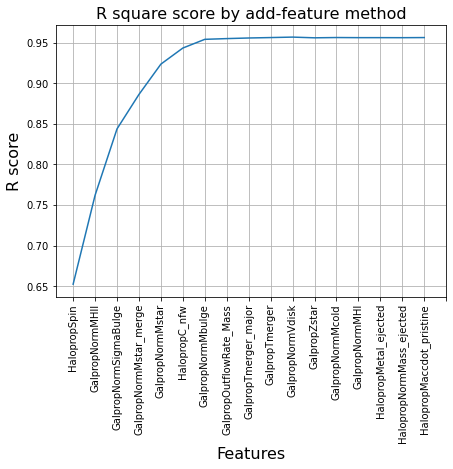

Elapsed time to run RF func on the Complete Dataset: 85269.327 seconds
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.859, test=0.856) total time=  42.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.957) total time=  22.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.990, test=0.960) total time=  55.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.857, test=0.850) total time=   7.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.962, test=0.943) total time=  14.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.965, test=0.939) total time= 1.3min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.990, test=0.959) total time= 1.4mi

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.857, test=0.855) total time=  42.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.952) total time=  22.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.951) total time=  56.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.855, test=0.841) total time=  20.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.962, test=0.944) total time=  15.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.966, test=0.943) total time= 1.3min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.859, test=0.857) total time=   8.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimato

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.857, test=0.847) total time=  41.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.966, test=0.946) total time= 1.3min
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.856, test=0.854) total time=   9.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.859, test=0.857) total time=  45.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.987, test=0.957) total time=  23.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.992, test=0.941) total time= 1.6min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.859, test=0.849) total time=   9.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.861, test=0.846) total time=  42.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.965, test=0.947) total time= 1.3min
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.859, test=0.854) total time=  19.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.965, test=0.938) total time=  37.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.988, test=0.957) total time=  21.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.989, test=0.958) total time= 1.5min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.859, test=0.833) total time=  23.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

In [25]:
# this code takes ~23.6 hrs (with interruption to commute)to run when the dataset is all morphologies 
#with randomly chosen 100,000 galaxies (out of total ~207,000 entries)

start_time = time.time()

RF_results_all = functions.target_predicting_RF_function(X=X_sample_all, y=y_sample_all)

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func on the Complete Dataset: {elapsed_time:.3f} seconds")

### <font color='red'> The most important features in TNG300, without $log_{10}M_{star}$<9.0, ($f_{disk}$ <0.0205 & $\frac{M_{bulge}}{M_{star}}$ < 0.4),  (using randomly chosen 100,000 out of 207,000 galaxies):

	 1 HalopropSpin 0.652298282114003
	 2 GalpropNormMHII 0.7619957833330049
	 3 GalpropNormSigmaBulge 0.8439434958639686
	 4 GalpropNormMstar_merge 0.8864413423026826
	 5 GalpropNormMstar 0.923864263978027
	 6 HalopropC_nfw 0.9436933580615018
	 7 GalpropNormMbulge 0.954425272690842
	 8 GalpropOutflowRate_Mass 0.9553352815152003
	 9 GalpropTmerger_major 0.9560816642231309
	 10 GalpropTmerger 0.9566102956279537
	 11 GalpropNormVdisk 0.9571773024099443
	 12 GalpropZstar 0.9563053061809573
     13 GalpropNormMcold 0.9566465642868471
     14 GalpropNormMHI 0.9565014374160077
     15 HalopropMetal_ejected 0.9565120983981873
     16 HalopropNormMass_ejected 0.9564564552179576
     17 HalopropMaccdot_pristine 0.956608697576391

### <font color='darkred'> The most important features in TNG300 (using all the dataset, 270,000 galaxies):     
     
	 1 HalopropSpin 0.5027156954191
	 2 GalpropNormMHII 0.6904627859021852
	 3 GalpropNormSigmaBulge 0.7813967542357466
	 4 GalpropNormMHI 0.8331968136333825
	 5 HalopropNormMstar_diffuse 0.8721724097431308
	 6 GalpropNormMstar 0.9121282116745905
	 7 HalopropC_nfw 0.9270299225878689
	 8 GalpropNormMbulge 0.9400458264939866
	 9 HalopropZhot 0.9416854473906517
	 10 GalpropNormMH2 0.9421628333674622
	 11 HalopropMaccdot_pristine 0.9430802626106506
	 12 GalpropNormMstar_merge 0.9438406985803699
	 13 HalopropMetal_ejected 0.9436331412342701
	 14 GalpropNormMBH 0.9437641560891564
	 15 GalpropSfrave1gyr 0.9436742968179942
    
    
<font color='darkred'> Note: NormMcold-NormMHII corr=0.96. I believe the 2nd most important feature could have as well been Mcold.
    
<font color='darkred'> NormMHI-NormMHII corr=0.97. So why are they both important??
    Mstar_diffuse highly correlated with Mstar_merge -> probably bec of ellipticals

#### The most important features in TNG100-NewSAM where Rdisk~spinRvir for fdisk<0.02 galaxies:
     
     1 HalopropSpin 0.5818459378590461
	 2 GalpropNormMcold 0.6897280429838544
	 3 GalpropNormSigmaBulge 0.7858416144733944
	 4 GalpropNormMbulge 0.8496826036025901
	 5 GalpropNormMstar 0.9057776407706974
	 6 HalopropC_nfw 0.9125443394482694
	 7 GalpropNormMstar_merge 0.9149411148277924
	 8 HalopropNormMstar_diffuse 0.9162793085706814
	 9 GalpropNormMHI 0.9162270822966448
	 10 GalpropOutflowRate_Metal 0.9169176292988489
	 11 GalpropTmerger 0.9179083142290532
	 12 GalpropNormMBH 0.9180671317363057
	 13 HalopropMcooldot 0.9163083567067593
	 14 GalpropNormMH2 0.917662308807175
	 15 GalpropZcold 0.9185773468268392
	 16 GalpropSfrave100myr 0.9181730342888731
	 17 HalopropMaccdot_radio 0.9173587991142921

#### The most important features in the TNG100-NewSAM wo fdisk<0.02:
	 1 HalopropSpin 0.6545116268918183
	 2 GalpropNormSigmaBulge 0.7650307090234199
	 3 GalpropTmerger 0.8155939296779229
	 4 GalpropNormMstar 0.8502577892077053
	 5 GalpropNormMbulge 0.8710217717724604
	 6 HalopropC_nfw 0.889655008082105
	 7 GalpropNormMcold 0.9036609618415384
	 8 GalpropNormMH2 0.9056991035291281
	 9 GalpropNormMHI 0.90849783947764
	 10 GalpropSfrave1gyr 0.9085092198789672
	 11 HalopropMcooldot 0.9090531038723041
	 12 HalopropNormMstar_diffuse 0.9094685815458577
	 13 GalpropOutflowRate_Mass 0.9104405612454741
	 14 GalpropZcold 0.9112774712942396
	 15 GalpropMaccdot_radio 0.9104395657528291
	 16 GalpropZstar 0.9108816299516845
	 17 HalopropMaccdot_pristine 0.9104133564429328

#### The most important features in the TNG100-NewSAM (where Rdisk~Rvir for fdisk<0.02):
     1 GalpropNormMHII 0.5115776943871704
	 2 GalpropNormMcold 0.6837795155645291
	 3 GalpropNormSigmaBulge 0.7651579093043096
	 4 HalopropMetal_ejected 0.8086931375129268
	 5 GalpropNormMbulge 0.8368305713001226
	 6 HalopropSpin 0.8692386263552642
	 7 GalpropNormMstar 0.8929344945607945
	 8 HalopropC_nfw 0.8983475218175246
	 9 GalpropNormMstar_merge 0.902365864243741
	 10 HalopropMcooldot 0.9049373122175082
	 11 GalpropTmerger 0.9052838052344137
	 12 GalpropNormMHI 0.9075986361006326
	 13 GalpropSfrave20myr 0.9073914451965557
	 14 HalopropNormMstar_diffuse 0.9075844690019407
	 15 GalpropSfr 0.9058595189147102
	 16 GalpropOutflowRate_Metal 0.9056400627945084
	 17 GalpropTmerger_major 0.9061621018333295

#### For comparison, in the old SAM, the most important features for the complete dataset were:
     1 HalopropSpin 0.38981842549718637
	 2 GalpropNormMstar_merge 0.5687884206620755
	 3 GalpropNormMstar 0.7074391163134375
	 4 GalpropNormVdisk 0.8172425437842289
	 5 GalpropNormMbulge 0.9139774683331688
	 6 GalpropNormSigmaBulge 0.9268403936483627
	 7 GalpropOutflowRate_Mass 0.9321074877316505
	 8 HalopropMetal_ejected 0.9312476813027875
	 9 HalopropC_nfw 0.9333837408833281
	 10 HalopropMaccdot_radio 0.9303051938395659
	 11 GalpropSfrave100myr 0.9298458404970287
	 12 HalopropMaccdot_reaccreate 0.9309502132434292
	 13 GalpropSfr 0.9294737415746473
	 14 GalpropZstar 0.9282941827107841
	 15 GalpropSfrave20myr 0.9274881104697413
	 16 GalpropMu_merger 0.9284962913476585
	 17 GalpropNormMHI 0.9270127729828616

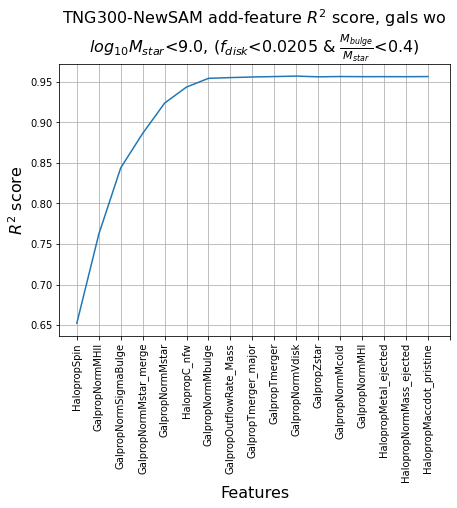

In [30]:
all_morph_fig_add_feature=RF_results_all[4].plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,18))
all_morph_fig_add_feature.set_title(label= r'TNG300-NewSAM add-feature $R^{2}$ score, gals wo' +'\n' +r'$log_{10}M_{star}$<9.0, ($f_{disk}$<0.0205 & $\frac{M_{bulge}}{M_{star}}$<0.4)',fontsize=16)
all_morph_fig_add_feature.set_xlabel('Features',fontsize=16)
all_morph_fig_add_feature.set_ylabel(r'$R^{2}$ score',fontsize=16)

# all_morph_fig_add_feature.get_figure().savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_All_morphologies_R2score_by_addfeature_method.jpg', dpi=500)

plt.show()

In [31]:
# RF_results_all[4].to_csv('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_All_morphologies_Max_R2_scores_by_addfeature_method.csv', index=False)

all_morph_addfeat = pd.read_csv('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_All_morphologies_Max_R2_scores_by_addfeature_method.csv')

all_morph_pred_fig = RF_results_all[1]
# all_morph_pred_fig.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_All_morphologies_RF_Prediction_vs_True.jpeg', dpi=500)
plt.show()

In [32]:
all_morph_fig_builtin_imp = RF_results_all[2]
# all_morph_fig_builtin_imp.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300-NewSAM_All_morphologies_Builtin_Feature_Ranking.jpeg', dpi=500)
plt.show()

## <font color='purple'> <a id =6> </a> <br> Choose a subset of 10,000 galaxies to use with Symbolic Regression (SR). This subset should be representative of all morphologies in distribution.

In [33]:
df_sample_SR = df_normalized_35.sample(n = 10000, random_state = 2023)


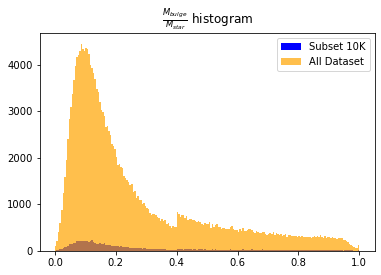

In [38]:
plt.hist(df_sample_SR.BulgeMstar_ratio, color='blue', label='Subset 10K', range=(0,1.0), bins=200)
plt.hist(df_normalized_35.BulgeMstar_ratio,  color='orange', 
         label='All Dataset', alpha=0.7, range=(0,1.0), bins=200)
plt.title(r'$\frac{M_{bulge}}{M_{star}}$ histogram')
plt.legend()
# plt.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_BulgeMstar_ratio_histogram_all_vs_10kdataset.jpeg', dpi=500)
plt.show()

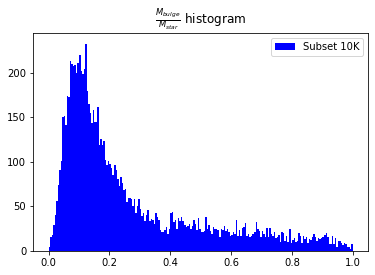

In [40]:
plt.hist(df_sample_SR.BulgeMstar_ratio, color='blue', label='Subset 10K', range=(0,1.0), bins=200)
# plt.hist(df_normalized_35.BulgeMstar_ratio,  color='orange', 
#          label='All Dataset', alpha=0.7, range=(0,1.0), bins=200)
plt.title(r'$\frac{M_{bulge}}{M_{star}}$ histogram')
plt.legend()
# plt.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_BulgeMstar_ratio_histogram_10kdataset.jpeg', dpi=500)
plt.show()

In [42]:
df_sample_SR[df_sample_SR.BulgeMstar_ratio>0.4].shape

(2368, 38)

In [43]:
df_sample_SR[df_sample_SR.BulgeMstar_ratio<0.4].shape

(7632, 38)

(array([401., 406., 410., 347., 286., 263., 170., 108.,  51.,  31.]),
 array([0.90000138, 0.90974809, 0.9194948 , 0.92924151, 0.93898822,
        0.94873493, 0.95848164, 0.96822835, 0.97797506, 0.98772177,
        0.99746848]),
 <BarContainer object of 10 artists>)

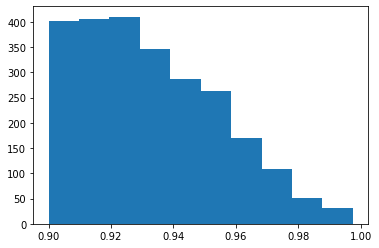

In [45]:
plt.hist(df_sample_SR[df_sample_SR.BulgeMstar_ratio<0.1].DiskMstar_ratio)

### <font color='purple'> <a id =7> </a> <br> SR All morphologies

#### <font color='blue'> Run the Symbolic Regression algorithm to search for the best physical model in terminal or VisualStudio, running the file SR_TNG300-NewSAM_eqn_search_all_morphologies_v1.py
Note: The SR algorithm does not run in Jupyter Notebook.

#### The pipeline for SR:
1. Randomly choose 10,000 (out of 207,000) galaxies to feed the SR search. This is because SR can use max ~10,000 entries to search for an equation. The morphology distribution of the 10K subset should be similar to the morphology distribution of the complete dataset.
2. Use only the most important features from the step above to feed the SR. This is because SR cannot handle a large amount of features and it does apply the built-in RF feature ranking before searching for an equation.
3. Run the SR equation search using the allowed mathematical operations for the task at hand.

The most important features used by SR to find the best equation are:
['HalopropSpin', 'GalpropNormMHII', 'GalpropNormSigmaBulge', 'GalpropNormMstar_merge', 'GalpropNormMstar', 'HalopropC_nfw', 'GalpropNormMbulge']
 
The best equation with n_iterations 1,000, 5,000, 10,000 and 15,000 is:0.602060624735432*HalopropSpin
 
R2 score=0.66
 
Elapsed time to compute the All Morphologies SR =14555.092seconds

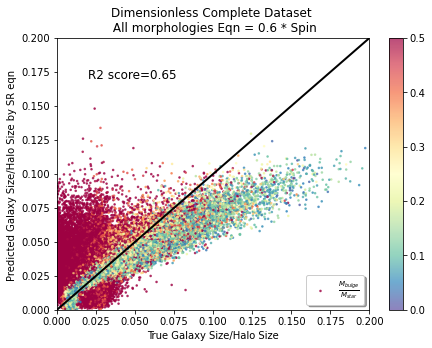

In [30]:
sr_v1_eqn1 = 0.6 * df_normalized_35.loc[:, 'HalopropSpin']

r2_score_all1=r2_score(df_normalized_35.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_normalized_35.loc[:, 'GalpropNormHalfRadius'], sr_v1_eqn1,
            c = df_normalized_35.loc[:, 'GalpropNormMbulge']/df_normalized_35.loc[:,'GalpropNormMstar'], 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{M_{bulge}}{M_{star}}$', vmin=0.0, vmax=0.5)
ax.text(0.02, 0.17, 'R2 score=' + '{:.2f}'.format(r2_score_all1), size=12)
ax.axis([0.0,0.2, 0.0,0.2])
ax.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
ax.set_title('Dimensionless Complete Dataset \n All morphologies Eqn = 0.6 * Spin')
ax.set_xlabel('True Galaxy Size/Halo Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_SR_eqn_All_morphologies_dimensionless.jpeg', dpi=500)
plt.show()

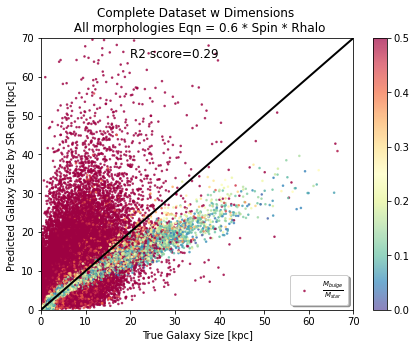

In [31]:
sr_v1_eqn2 = 0.6 * df_not_normalized.loc[:, 'HalopropSpin'] * df_not_normalized.loc[:, 'GalpropRhalo']

r2_score_all2=r2_score(df_not_normalized.loc[:, 'GalpropHalfRadius'], sr_v1_eqn2)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_not_normalized.loc[:, 'GalpropHalfRadius'], sr_v1_eqn2,
            c = df_not_normalized.loc[:, 'GalpropMbulge']/df_not_normalized.loc[:,'GalpropMstar'], 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{M_{bulge}}{M_{star}}$', vmin=0.0, vmax=0.5)
ax.text(20, 65, 'R2 score=' + '{:.2f}'.format(r2_score_all2), size=12)
ax.axis([0.0,70, 0.0,70])
ax.plot([0.0, 70], [0.0, 70], color = 'black', linewidth = 2)
ax.set_title('Complete Dataset w Dimensions \n All morphologies Eqn = 0.6 * Spin * Rhalo')
ax.set_xlabel('True Galaxy Size [kpc]')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size by SR eqn [kpc] ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_SR_eqn_All_morphologies_w_dimensions.jpeg', dpi=500)
plt.show()

## <font color='purple'> <a id =8> </a> <br> SR by morphology: Define morphologies by increasing $\frac{M_{bulge}}{M_{star}}$ fraction

In [33]:
# 52,053 galaxies in df_1
df_1 = df_normalized_35.loc[df_normalized_35.loc[:, 'BulgeMstar_ratio']<=0.10] 
df_1_raw = df_not_normalized.loc[df_not_normalized.loc[:, 'BulgeMstar_ratio']<=0.10] 

# 64,494 galaxies in df_2
df_2 = df_normalized_35.loc[(df_normalized_35.BulgeMstar_ratio > 0.10) & (df_normalized_35.BulgeMstar_ratio <= 0.20)] 
df_2_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.10) & (df_not_normalized.BulgeMstar_ratio <= 0.20)] 

# 28,372 galaxies in df_3
df_3 = df_normalized_35.loc[(df_normalized_35.BulgeMstar_ratio > 0.20) & (df_normalized_35.BulgeMstar_ratio <= 0.30)] 
df_3_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.20) & (df_not_normalized.BulgeMstar_ratio <= 0.30)] 

# 13,582 galaxies in df_4
df_4 = df_normalized_35.loc[(df_normalized_35.BulgeMstar_ratio > 0.30) & (df_normalized_35.BulgeMstar_ratio <= 0.40)] 
df_4_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.30) & (df_not_normalized.BulgeMstar_ratio <= 0.40)] 

# 13,539 galaxies in df_5
df_5 = df_normalized_35.loc[(df_normalized_35.BulgeMstar_ratio > 0.40) & (df_normalized_35.BulgeMstar_ratio <= 0.50)] 
df_5_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.40) & (df_not_normalized.BulgeMstar_ratio <= 0.50)] 

# 35,427 galaxies in df_5
df_6 = df_normalized_35.loc[df_normalized_35.loc[:, 'BulgeMstar_ratio']>0.50] 
df_6_raw = df_not_normalized.loc[df_not_normalized.loc[:, 'BulgeMstar_ratio']>0.50] 

# Combined morphologies 1 to 4 in order to fit one physical model to all of them; 
# 158,501 galaxies in the 1-4 morphologies, out of a total of ~207,000
df_14 = df_normalized_35.loc[df_normalized_35.BulgeMstar_ratio <= 0.40] #normalized
df_14_raw = df_not_normalized.loc[df_not_normalized.BulgeMstar_ratio <= 0.40] 

In [58]:
# df_1.to_csv('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_df_1_Pure_Disks_Normalized_as_defined_in_TNG300notebook_v4', index=False)
# df_1_raw.to_csv('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_df_1_Pure_Disks_Raw_as_defined_in_TNG300notebook_v4', index=False)

### <font color='purple'> <a id =9> </a> <br> SR by morphology: Group 1 Pure Disk Galaxies, $\frac{M_{bulge}}{M_{star}}$<0.1

In [41]:
X_1 = df_1.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio',
                         'GalpropNormMdisk', 'DiskMstar_ratio'])


y_1 = df_1.loc[:,'GalpropNormHalfRadius']

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.9938 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
RF Accuracy: 0.99 (+/- 0.01)


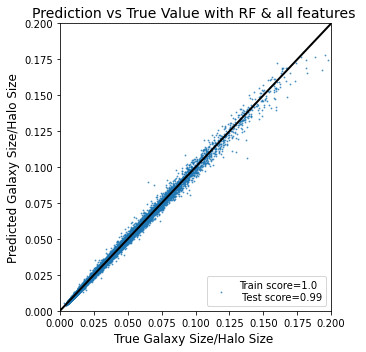

Elapsed time to compute the importances: 0.187 seconds
Elapsed time to compute the importances: 108.911 seconds


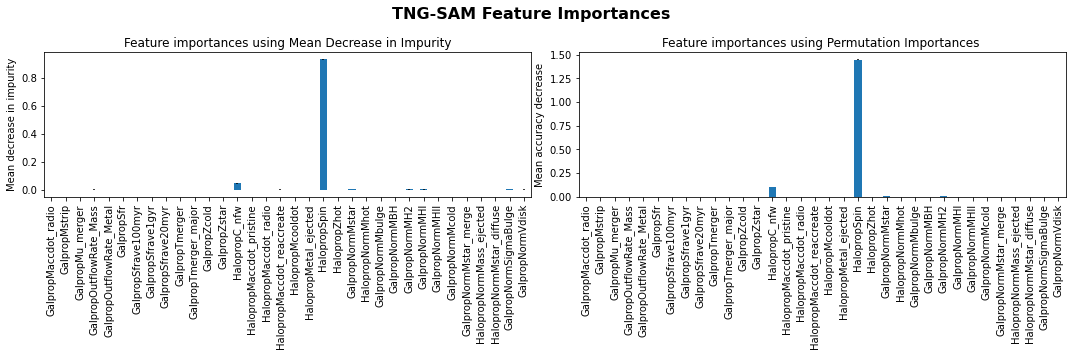

  0%|                                                    | 0/34 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▎                                          | 1/34 [00:02<01:35,  2.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▌                                         | 2/34 [00:13<04:03,  7.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▉                                        | 3/34 [00:26<05:08,  9.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▏                                      | 4/34 [00:37<05:13, 10.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▍                                     | 5/34 [00:49<05:13, 10.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|███████▊                                    | 6/34 [01:01<05:17, 11.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████                                   | 7/34 [01:12<05:07, 11.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▎                                 | 8/34 [01:24<04:59, 11.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▋                                | 9/34 [01:37<04:54, 11.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▋                              | 10/34 [01:43<04:02, 10.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▉                             | 11/34 [01:47<03:07,  8.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▏                           | 12/34 [02:00<03:34,  9.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▍                          | 13/34 [02:11<03:31, 10.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▋                         | 14/34 [02:22<03:27, 10.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▉                        | 15/34 [02:30<03:03,  9.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▏                      | 16/34 [02:34<02:21,  7.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 17/34 [02:46<02:37,  9.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▊                    | 18/34 [02:56<02:33,  9.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████                   | 19/34 [03:08<02:32, 10.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▎                 | 20/34 [03:17<02:17,  9.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▌                | 21/34 [03:28<02:12, 10.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▊               | 22/34 [03:39<02:04, 10.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████              | 23/34 [03:49<01:53, 10.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▎            | 24/34 [04:00<01:43, 10.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▌           | 25/34 [04:02<01:11,  7.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▉          | 26/34 [04:14<01:13,  9.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████▏        | 27/34 [04:24<01:06,  9.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▍       | 28/34 [04:34<00:58,  9.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▋      | 29/34 [04:45<00:49,  9.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▉     | 30/34 [04:53<00:37,  9.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████▏   | 31/34 [05:04<00:29, 10.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▍  | 32/34 [05:08<00:16,  8.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▋ | 33/34 [05:19<00:08,  8.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 34/34 [05:30<00:00,  9.72s/it]


1. iteration: 
	 1 HalopropSpin 0.9316749236373595


  0%|                                                    | 0/33 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▎                                          | 1/33 [00:15<08:11, 15.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▋                                         | 2/33 [00:33<08:39, 16.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████                                        | 3/33 [00:48<08:05, 16.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▎                                      | 4/33 [01:06<08:06, 16.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▋                                     | 5/33 [01:24<08:02, 17.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|████████                                    | 6/33 [01:42<07:50, 17.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▎                                  | 7/33 [01:59<07:35, 17.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▋                                 | 8/33 [02:16<07:07, 17.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|████████████                                | 9/33 [02:33<06:56, 17.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████                              | 10/33 [02:47<06:12, 16.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 11/33 [02:57<05:14, 14.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▋                           | 12/33 [03:15<05:25, 15.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▉                          | 13/33 [03:33<05:23, 16.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▏                        | 14/33 [03:48<05:01, 15.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▌                       | 15/33 [04:00<04:22, 14.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 16/33 [04:17<04:19, 15.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 17/33 [04:35<04:17, 16.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.009, test=0.006) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.019, test=-0.002) total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.022, test=-0.009) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.016, test=0.001) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.037, test=0.025) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.072, test=0.022) total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.297, test=-0.182) total time=   1.3s
[CV 2/3] 

 55%|███████████████████████▍                   | 18/33 [04:50<03:58, 15.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.009, test=0.007) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.019, test=-0.002) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.021, test=-0.007) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.015, test=0.003) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.040, test=0.023) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.075, test=0.019) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.303, test=-0.151) total time=   3.3s
[CV 1/3] END

 58%|████████████████████████▊                  | 19/33 [05:06<03:43, 15.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.011, test=0.005) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.015, test=0.003) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.021, test=-0.006) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.023, test=-0.010) total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.034, test=0.030) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.078, test=0.017) total time=   3.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.008, test=-0.001) total time=   0.9s
[CV 1/3] 

 61%|██████████████████████████                 | 20/33 [05:24<03:35, 16.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.011, test=0.005) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.020, test=-0.005) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.015, test=0.002) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.019, test=-0.002) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.016, test=0.001) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.036, test=0.025) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.040, test=0.023) total time=   1.8s
[CV 2/3] END

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.013, test=0.000) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.021, test=-0.006) total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.040, test=0.022) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.074, test=0.018) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.078, test=0.017) total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.299, test=-0.180) total time=   3.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.008, test=-0.001) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimato

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.012, test=0.005) total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.023, test=-0.011) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.033, test=0.029) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.069, test=0.021) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.072, test=0.022) total time=   3.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.306, test=-0.174) total time=   5.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.008, test=-0.001) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_esti

 64%|███████████████████████████▎               | 21/33 [05:42<03:22, 16.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.013, test=0.001) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.009, test=0.006) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.016, test=-0.000) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.021, test=-0.005) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.034, test=0.030) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.076, test=0.014) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.076, test=0.019) total time=   3.1s
[CV 1/3] E

 67%|████████████████████████████▋              | 22/33 [06:00<03:08, 17.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|█████████████████████████████▉             | 23/33 [06:17<02:53, 17.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.013, test=0.000) total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.021, test=-0.005) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.037, test=0.025) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.293, test=-0.183) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.304, test=-0.176) total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.008, test=-0.001) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.387, test=-0.245) total time=   1.6s
[CV

 73%|███████████████████████████████▎           | 24/33 [06:35<02:35, 17.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▌          | 25/33 [06:53<02:21, 17.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▉         | 26/33 [07:08<01:58, 16.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▏       | 27/33 [07:28<01:46, 17.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▍      | 28/33 [07:46<01:29, 17.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▊     | 29/33 [08:02<01:08, 17.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████    | 30/33 [08:20<00:52, 17.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▍  | 31/33 [08:36<00:34, 17.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▋ | 32/33 [08:54<00:17, 17.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 33/33 [09:11<00:00, 16.73s/it]


2. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408


  0%|                                                    | 0/32 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/32 [00:27<14:14, 27.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 2/32 [00:55<13:49, 27.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████▏                                       | 3/32 [01:19<12:36, 26.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 4/32 [01:47<12:28, 26.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|██████▉                                     | 5/32 [02:14<12:06, 26.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▎                                   | 6/32 [02:41<11:42, 27.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▋                                  | 7/32 [03:08<11:17, 27.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 8/32 [03:31<10:16, 25.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▍                               | 9/32 [03:58<10:02, 26.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▍                             | 10/32 [04:21<09:12, 25.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 34%|██████████████▊                            | 11/32 [04:41<08:14, 23.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▏                          | 12/32 [05:08<08:12, 24.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▍                         | 13/32 [05:35<08:00, 25.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▊                        | 14/32 [05:57<07:17, 24.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▏                      | 15/32 [06:24<07:06, 25.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 16/32 [06:48<06:38, 24.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▊                    | 17/32 [07:15<06:22, 25.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████▏                  | 18/32 [07:42<06:03, 25.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.617, test=0.017) total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.629, test=0.012) total time=   4.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.940, test=0.937) total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.953, test=0.937) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.941) total time=   4.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.944, test=0.933) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.943, test=0.941) total time=   2.8s
[CV 2/3] END

 59%|█████████████████████████▌                 | 19/32 [08:09<05:41, 26.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 20/32 [08:36<05:16, 26.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.942, test=0.941) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.960, test=0.942) total time=   2.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.931) total time=   3.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.936, test=0.930) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.924) total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.924) total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.941, test=0.935) total time=   1.4s
[CV 2/3] END bo

 66%|████████████████████████████▏              | 21/32 [09:00<04:42, 25.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▌             | 22/32 [09:21<04:03, 24.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▉            | 23/32 [09:45<03:37, 24.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.925) total time=   6.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.941, test=0.935) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.955, test=0.940) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.958, test=0.932) total time=   4.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.978, test=0.930) total time=   6.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.940, test=0.936) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.955, test=0.938) total time=   2.5s
[CV 2/3] EN

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.936, test=0.929) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.953, test=0.924) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.951, test=0.932) total time=   4.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.920) total time=   5.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.940, test=0.938) total time=   2.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.979, test=0.925) total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.978, test=0.928) total time=   3.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estim

 75%|████████████████████████████████▎          | 24/32 [10:08<03:10, 23.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.942, test=0.932) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.956, test=0.934) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.956, test=0.940) total time=   4.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.938, test=0.936) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.940, test=0.936) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.979, test=0.922) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.977, test=0.932) total time=   6.7s
[CV 3/3] END

 78%|█████████████████████████████████▌         | 25/32 [10:33<02:48, 24.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.932) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.941, test=0.936) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.977, test=0.933) total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.980, test=0.927) total time=   6.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.940, test=0.930) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.954, test=0.938) total time=   2.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.977, test=0.932) total time=   4.0s
[CV 2/3] EN

 81%|██████████████████████████████████▉        | 26/32 [10:54<02:20, 23.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████▎      | 27/32 [11:19<01:59, 23.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 28/32 [11:44<01:36, 24.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.957, test=0.929) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.954, test=0.938) total time=   4.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.978, test=0.933) total time=   6.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.939, test=0.936) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.957, test=0.926) total time=   4.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.977, test=0.932) total time=   6.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.937, test=0.937) total time=   2.8s
[CV 3/3] 

 91%|██████████████████████████████████████▉    | 29/32 [12:12<01:15, 25.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▎  | 30/32 [12:36<00:49, 24.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▋ | 31/32 [13:01<00:24, 24.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 32/32 [13:25<00:00, 25.18s/it]


3. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922


  0%|                                                    | 0/31 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/31 [00:34<17:14, 34.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 2/31 [01:08<16:39, 34.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▎                                       | 3/31 [01:37<14:54, 31.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 4/31 [02:06<13:52, 30.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 5/31 [02:41<14:00, 32.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▌                                   | 6/31 [03:16<13:46, 33.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|█████████▉                                  | 7/31 [03:50<13:23, 33.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▎                                | 8/31 [04:25<12:59, 33.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▊                               | 9/31 [04:58<12:18, 33.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▊                             | 10/31 [05:28<11:22, 32.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                           | 11/31 [06:03<11:04, 33.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▋                          | 12/31 [06:39<10:45, 34.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████                         | 13/31 [07:12<10:10, 33.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▍                       | 14/31 [07:47<09:41, 34.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 15/31 [08:22<09:10, 34.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 16/31 [08:57<08:36, 34.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▌                   | 17/31 [09:26<07:40, 32.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▉                  | 18/31 [10:02<07:20, 33.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▎                | 19/31 [10:37<06:49, 34.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▋               | 20/31 [11:12<06:18, 34.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 21/31 [11:48<05:48, 34.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▌            | 22/31 [12:22<05:12, 34.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.962) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.991, test=0.978) total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.986) total time=   5.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.973) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.985) total time=   3.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.993) total time=   2.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.993) total time=   8.3s
[CV 1/3] EN

 74%|███████████████████████████████▉           | 23/31 [12:57<04:38, 34.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.983) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.993) total time=   8.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.975) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.975) total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.976) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.986) total time=   8.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.964) total time=   2.1s
[CV 3/3]

 77%|█████████████████████████████████▎         | 24/31 [13:33<04:05, 35.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 25/31 [14:08<03:31, 35.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████       | 26/31 [14:45<02:57, 35.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▍     | 27/31 [15:21<02:22, 35.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▊    | 28/31 [15:50<01:41, 33.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.993) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.985) total time=   8.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.965) total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.985) total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.992) total time=   4.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.963) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.971) total time=   4.3s
[CV 2/3] EN

[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.993) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.993) total time=   7.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.985) total time=   7.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.972) total time=   4.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.985) total time=   2.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.994) total time=   4.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.964) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_esti

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.984) total time=   4.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.971, test=0.971) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.993) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.993) total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.994) total time=   4.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.965) total time=   4.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.993) total time=   7.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimato

 94%|████████████████████████████████████████▏  | 29/31 [16:28<01:10, 35.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.985) total time=   5.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.974) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.986) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.986) total time=   7.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.993) total time=   7.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.973) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.991, test=0.978) total time=   1.3s
[CV 3/3] END

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.974) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.976, test=0.962) total time=   4.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.994) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.994) total time=   8.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.973) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.994) total time=   3.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.994) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_esti

 97%|█████████████████████████████████████████▌ | 30/31 [17:03<00:34, 34.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 31/31 [17:38<00:00, 34.15s/it]


4. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547


  0%|                                                    | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.963) total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.989, test=0.987) total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.991, test=0.979) total time=   6.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.973) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.973) total time=   3.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.976) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.986) total time=   7.1s
[CV 2/3] END

  3%|█▍                                          | 1/30 [00:44<21:38, 44.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|██▉                                         | 2/30 [01:22<18:55, 40.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 3/30 [02:07<19:09, 42.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▊                                      | 4/30 [02:53<19:06, 44.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 5/30 [03:41<18:51, 45.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 6/30 [04:27<18:14, 45.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▎                                 | 7/30 [05:10<17:09, 44.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▋                                | 8/30 [06:01<17:10, 46.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 9/30 [06:56<17:15, 49.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 10/30 [07:40<15:55, 47.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▊                           | 11/30 [08:21<14:25, 45.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 12/30 [09:10<14:00, 46.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▋                        | 13/30 [09:50<12:36, 44.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████                       | 14/30 [10:37<12:04, 45.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 15/30 [11:23<11:22, 45.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▉                    | 16/30 [12:08<10:34, 45.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 17/30 [12:53<09:48, 45.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 18/30 [13:38<09:03, 45.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████▏               | 19/30 [14:23<08:16, 45.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 20/30 [15:08<07:31, 45.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████             | 21/30 [15:53<06:45, 45.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▌           | 22/30 [16:37<05:59, 44.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|████████████████████████████████▉          | 23/30 [17:24<05:16, 45.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 24/30 [18:13<04:39, 46.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 25/30 [18:59<03:51, 46.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▎     | 26/30 [19:36<02:53, 43.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▋    | 27/30 [20:21<02:11, 43.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.965) total time=   2.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.994, test=0.993) total time=   4.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.994) total time=   6.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.961) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.985) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.994) total time=   9.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.994) total time=   9.5s
[CV 2/3] END

 93%|████████████████████████████████████████▏  | 28/30 [21:04<01:27, 43.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.966) total time=   2.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.986) total time=   4.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.993) total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.994) total time=  10.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.972) total time=   5.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.986) total time=   9.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.973) total time=   5.2s
[CV 3/3] EN

 97%|█████████████████████████████████████████▌ | 29/30 [21:47<00:43, 43.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 30/30 [22:23<00:00, 44.78s/it]


5. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▌                                          | 1/29 [00:40<18:51, 40.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███                                         | 2/29 [01:21<18:27, 41.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.995) total time=  10.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.974) total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.985) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.995) total time=   9.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.995) total time=   9.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.971) total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.993) total time=   1.9s
[CV 1/3] EN

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.994) total time=   9.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.974) total time=   2.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.985) total time=   4.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.996) total time=   6.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.973) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.964) total time=   5.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.994) total time=   2.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_esti

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.964) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.971) total time=   5.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.995) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.985) total time=  10.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.961) total time=   2.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.995) total time=   4.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.995) total time=   2.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_esti

 10%|████▌                                       | 3/29 [02:11<19:29, 44.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████                                      | 4/29 [03:01<19:30, 46.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.976, test=0.962) total time=   4.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.994) total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.994) total time=   9.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.976, test=0.963) total time=   5.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.994) total time=   9.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.962) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.995) total time=   1.9s
[CV 3/3] EN

 17%|███████▌                                    | 5/29 [03:50<19:07, 47.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.994, test=0.993) total time=   7.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.985) total time=   8.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.971) total time=   2.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.995) total time=   4.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.985) total time=   6.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.961) total time=   5.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.994) total time=   9.5s
[CV 3/3] E

 21%|█████████                                   | 6/29 [04:40<18:32, 48.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 7/29 [05:29<17:51, 48.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▏                               | 8/29 [06:19<17:08, 48.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.987) total time=  10.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.974) total time=   2.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.983) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.994) total time=   9.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.962) total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.995) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.985) total time=   9.2s
[CV 3/3] END 

 31%|█████████████▋                              | 9/29 [07:06<16:11, 48.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 34%|██████████████▊                            | 10/29 [07:51<15:02, 47.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▎                          | 11/29 [08:41<14:28, 48.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▊                         | 12/29 [09:31<13:48, 48.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▎                       | 13/29 [10:19<12:54, 48.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 14/29 [10:54<11:08, 44.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 15/29 [11:37<10:14, 43.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▋                   | 16/29 [12:27<09:53, 45.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▏                 | 17/29 [13:16<09:22, 46.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▋                | 18/29 [14:06<08:44, 47.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 66%|████████████████████████████▏              | 19/29 [14:55<08:02, 48.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▋             | 20/29 [15:45<07:18, 48.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|███████████████████████████████▏           | 21/29 [16:26<06:09, 46.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▌          | 22/29 [17:16<05:31, 47.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 23/29 [18:06<04:48, 48.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▌       | 24/29 [18:55<04:02, 48.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|█████████████████████████████████████      | 25/29 [19:45<03:16, 49.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▌    | 26/29 [20:35<02:27, 49.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████   | 27/29 [21:17<01:33, 46.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 28/29 [22:07<00:47, 47.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 29/29 [22:56<00:00, 47.48s/it]


6. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▌                                          | 1/28 [00:56<25:32, 56.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███▏                                        | 2/28 [01:53<24:41, 56.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▋                                       | 3/28 [02:50<23:45, 57.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.995) total time=  13.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.996) total time=  12.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.974) total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.986) total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.995) total time=   7.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.987) total time=   9.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.961) total time=   1.7s
[CV 1/3] END

 14%|██████▎                                     | 4/28 [03:48<22:49, 57.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|███████▊                                    | 5/28 [04:45<21:51, 57.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.987) total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.995) total time=  15.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.975) total time=   4.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.987) total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.995) total time=  15.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.974) total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.995) total time=   6.5s
[CV 1/3] END

 21%|█████████▍                                  | 6/28 [05:42<20:56, 57.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 7/28 [06:39<19:58, 57.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                               | 8/28 [07:36<19:04, 57.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.993) total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.996) total time=  14.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.964) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.973) total time=   6.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.988) total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.996) total time=  15.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.970) total time=   1.2s
[CV 1/3]

 32%|██████████████▏                             | 9/28 [08:22<16:59, 53.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.972, test=0.972) total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.987) total time=   6.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.996) total time=   9.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.963) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.975) total time=   7.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.995) total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.986) total time=  15.2s
[CV 3/3] EN

 36%|███████████████▎                           | 10/28 [09:15<16:02, 53.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.987) total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.995, test=0.995) total time=  13.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.996) total time=  12.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.975) total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.994) total time=   6.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.986) total time=   9.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.972) total time=   1.2s
[CV 1/3] END

 39%|████████████████▉                          | 11/28 [10:13<15:29, 54.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.971) total time=   7.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.987) total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.996) total time=  15.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.971) total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.987) total time=   6.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.988) total time=   9.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.973) total time=   1.2s
[CV 1/3] EN

 43%|██████████████████▍                        | 12/28 [11:00<14:01, 52.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▉                       | 13/28 [11:56<13:22, 53.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.996) total time=   9.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.972, test=0.971) total time=   3.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.985) total time=   6.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.995) total time=  14.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.972) total time=   6.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   3.6s
[CV 3/3]

 50%|█████████████████████▌                     | 14/28 [12:53<12:43, 54.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████                    | 15/28 [13:40<11:21, 52.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 16/28 [14:38<10:47, 53.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████                 | 17/28 [15:35<10:04, 54.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.986) total time=   3.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.996) total time=  14.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.971) total time=   3.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.985) total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.995) total time=  13.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.962) total time=   3.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.995) total time=   6.2s
[CV 3/3] END

 64%|███████████████████████████▋               | 18/28 [16:33<09:17, 55.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 19/28 [17:29<08:23, 55.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 20/28 [18:26<07:29, 56.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 21/28 [19:22<06:33, 56.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▊         | 22/28 [20:23<05:46, 57.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▎       | 23/28 [21:26<04:55, 59.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 24/28 [22:25<03:56, 59.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▍    | 25/28 [23:23<02:56, 58.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▉   | 26/28 [24:21<01:57, 58.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 27/28 [25:23<00:59, 59.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 28/28 [26:23<00:00, 56.55s/it]


7. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601
	 7 GalpropNormSigmaBulge 0.994460482770335


  0%|                                                    | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/27 [01:05<28:31, 65.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███▎                                        | 2/27 [02:11<27:30, 66.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▉                                       | 3/27 [03:18<26:29, 66.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                     | 4/27 [04:24<25:19, 66.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▏                                   | 5/27 [05:29<24:04, 65.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▊                                  | 6/27 [06:34<22:57, 65.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▍                                | 7/27 [07:40<21:53, 65.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████                               | 8/27 [08:46<20:49, 65.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 9/27 [09:50<19:35, 65.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▉                           | 10/27 [10:51<18:06, 63.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▌                         | 11/27 [12:01<17:31, 65.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.996) total time=  15.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.972) total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.995) total time=   6.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   3.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.988) total time=  15.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.961) total time=   1.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.986) total time=   2.7s
[CV 1/3] E

 44%|███████████████████                        | 12/27 [13:13<16:52, 67.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▋                      | 13/27 [14:20<15:43, 67.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 14/27 [15:26<14:33, 67.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.971) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.975) total time=   8.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.987) total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.997) total time=  15.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.976) total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.987) total time=   6.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.996) total time=   3.6s
[CV 2/3] EN

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.987) total time=   8.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.963) total time=   7.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  13.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.970) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.975) total time=   8.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   3.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_est

 56%|███████████████████████▉                   | 15/27 [16:33<13:23, 66.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 16/27 [17:38<12:10, 66.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████                | 17/27 [18:32<10:28, 62.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.988) total time=  14.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.971) total time=   7.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.989) total time=   3.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=   9.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.974) total time=   7.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  13.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.961) total time=   3.9s
[CV 2/3] 

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.996) total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=   6.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.988) total time=   9.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.970) total time=   3.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.995) total time=   2.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  13.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.962) total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators

 67%|████████████████████████████▋              | 18/27 [19:28<09:04, 60.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████▎            | 19/27 [20:34<08:17, 62.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▊           | 20/27 [21:40<07:23, 63.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▍         | 21/27 [22:45<06:23, 63.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.989) total time=   3.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.997) total time=  15.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.974) total time=   7.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.986) total time=  13.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.971) total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.996) total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.987) total time=   6.9s
[CV 2/3] EN

 81%|███████████████████████████████████        | 22/27 [23:50<05:21, 64.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.974) total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.988) total time=   6.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.997) total time=  14.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.962) total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=   6.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   3.6s
[CV 2/3] EN

 85%|████████████████████████████████████▋      | 23/27 [24:56<04:18, 64.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▏    | 24/27 [26:01<03:14, 64.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▊   | 25/27 [27:07<02:10, 65.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.996) total time=   9.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.972) total time=   7.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.988) total time=  13.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.962) total time=   4.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.996) total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  16.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.973) total time=   9.0s
[CV 3/3] END 

 96%|█████████████████████████████████████████▍ | 26/27 [28:01<01:01, 61.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 27/27 [29:06<00:00, 64.70s/it]


8. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601
	 7 GalpropNormSigmaBulge 0.994460482770335
	 8 GalpropSfr 0.9944317021260475


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/26 [01:12<30:05, 72.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▍                                        | 2/26 [02:24<28:55, 72.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████                                       | 3/26 [03:37<27:45, 72.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▊                                     | 4/26 [04:50<26:38, 72.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▍                                   | 5/26 [06:03<25:31, 72.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▏                                 | 6/26 [07:16<24:17, 72.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▊                                | 7/26 [08:34<23:36, 74.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▌                              | 8/26 [09:46<22:06, 73.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▏                            | 9/26 [10:42<19:20, 68.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                          | 10/26 [11:42<17:33, 65.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▏                        | 11/26 [12:56<17:01, 68.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▊                       | 12/26 [14:06<16:04, 68.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 13/26 [15:19<15:08, 69.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████▏                   | 14/26 [16:32<14:10, 70.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▊                  | 15/26 [17:45<13:06, 71.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▍                | 16/26 [18:57<11:58, 71.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|████████████████████████████               | 17/26 [20:10<10:49, 72.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▊             | 18/26 [21:23<09:38, 72.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▍           | 19/26 [22:36<08:27, 72.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████          | 20/26 [23:48<07:14, 72.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 21/26 [25:01<06:02, 72.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.974) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.974) total time=  11.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.987) total time=   4.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.996) total time=  18.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.974) total time=   1.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.995) total time=   4.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=   8.8s
[CV 2/3] END 

 85%|████████████████████████████████████▍      | 22/26 [26:13<04:49, 72.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|██████████████████████████████████████     | 23/26 [27:26<03:37, 72.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.987) total time=  17.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.974) total time=   9.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.987) total time=  15.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.972) total time=   4.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.986) total time=   3.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  15.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.965) total time=   1.9s
[CV 1/3] END 

 92%|███████████████████████████████████████▋   | 24/26 [28:38<02:25, 72.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.997) total time=  12.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.962) total time=   5.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=   8.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  10.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.975) total time=   2.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.973) total time=  10.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.988) total time=   4.8s
[CV 1/3] END

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.965) total time=   5.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=   8.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   4.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.989) total time=  19.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.976, test=0.962) total time=  10.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   4.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  10.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_esti

 96%|█████████████████████████████████████████▎ | 25/26 [29:51<01:12, 72.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 26/26 [31:04<00:00, 71.71s/it]


9. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601
	 7 GalpropNormSigmaBulge 0.994460482770335
	 8 GalpropSfr 0.9944317021260475
	 9 HalopropMaccdot_reaccreate 0.9943410958906713


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.974) total time=  10.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.987) total time=   4.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.997) total time=  18.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.974) total time=   5.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=   9.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  12.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.977) total time=   2.1s
[CV 2/3] EN

  4%|█▊                                          | 1/25 [01:20<32:00, 80.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▌                                        | 2/25 [02:40<30:47, 80.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▎                                      | 3/25 [04:00<29:24, 80.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.977, test=0.963) total time=   2.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.996) total time=   3.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.995) total time=   9.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.988) total time=  12.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.975) total time=   5.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.996) total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  18.1s
[CV 2/3] END bo

 16%|███████                                     | 4/25 [05:24<28:35, 81.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 5/25 [06:44<27:03, 81.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 6/25 [08:04<25:34, 80.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.997) total time=  20.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.977, test=0.966) total time=  10.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  17.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.965) total time=   5.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.995, test=0.996) total time=   8.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   4.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.989) total time=  20.3s
[CV 2/3]

 28%|████████████▎                               | 7/25 [09:11<22:51, 76.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 8/25 [10:30<21:52, 77.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  18.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.959) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.995) total time=   3.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  18.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.985) total time=  17.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.972) total time=   4.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.995) total time=   3.3s
[CV 2/3] END 

 36%|███████████████▊                            | 9/25 [11:47<20:30, 76.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 10/25 [13:07<19:30, 78.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▉                        | 11/25 [14:28<18:22, 78.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▋                      | 12/25 [15:46<17:01, 78.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 13/25 [16:52<14:56, 74.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████                   | 14/25 [17:58<13:14, 72.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 15/25 [19:19<12:28, 74.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▌               | 16/25 [20:39<11:27, 76.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 17/25 [21:59<10:20, 77.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▉            | 18/25 [23:19<09:08, 78.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▋          | 19/25 [24:40<07:54, 79.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 20/25 [26:01<06:37, 79.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████       | 21/25 [27:21<05:19, 79.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▊     | 22/25 [28:42<04:00, 80.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▌   | 23/25 [30:02<02:40, 80.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▎ | 24/25 [31:08<01:15, 75.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 25/25 [32:29<00:00, 77.99s/it]


10. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601
	 7 GalpropNormSigmaBulge 0.994460482770335
	 8 GalpropSfr 0.9944317021260475
	 9 HalopropMaccdot_reaccreate 0.9943410958906713
	 10 GalpropSfrave1gyr 0.9942507285793947


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                          | 1/24 [01:27<33:34, 87.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▋                                        | 2/24 [02:55<32:09, 87.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 3/24 [04:23<30:47, 87.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 4/24 [05:51<29:15, 87.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▏                                  | 5/24 [07:19<27:48, 87.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 6/24 [08:46<26:19, 87.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▊                               | 7/24 [10:12<24:42, 87.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 8/24 [11:22<21:46, 81.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   6.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.989) total time=  25.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.974) total time=  11.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   5.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.987) total time=  13.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.963) total time=   5.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=   9.4s
[CV 3/3]

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  16.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.973) total time=   2.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.995) total time=   3.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  20.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.987) total time=  19.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.974) total time=   2.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.995) total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

 38%|████████████████▌                           | 9/24 [12:53<21:10, 84.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.996) total time=  13.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.976) total time=   5.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.996) total time=   4.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.986) total time=  20.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.974) total time=  12.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.988) total time=   5.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.997) total time=  13.4s
[CV 2/3] E

 42%|█████████████████▉                         | 10/24 [14:21<19:58, 85.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.987) total time=   3.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  19.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.997) total time=  18.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.962) total time=   5.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  10.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  13.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.975) total time=   2.3s
[CV 1/3] END

 46%|███████████████████▋                       | 11/24 [15:46<18:31, 85.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.988) total time=  23.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.974) total time=   5.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  10.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.987) total time=   5.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.997) total time=  21.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.975) total time=  11.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   5.0s
[CV 3/3] 

 50%|█████████████████████▌                     | 12/24 [17:14<17:15, 86.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████▎                   | 13/24 [18:42<15:54, 86.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.996) total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.995) total time=  20.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.988) total time=  18.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.963) total time=   5.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  10.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  13.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.975) total time=   2.3s
[CV 2/3] END

 58%|█████████████████████████                  | 14/24 [20:11<14:33, 87.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 15/24 [21:39<13:07, 87.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 16/24 [23:06<11:40, 87.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.989) total time=  21.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.965) total time=   2.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.976, test=0.965) total time=  11.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   5.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.997) total time=  22.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.976, test=0.965) total time=  11.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   5.3s
[CV 3/3

 71%|██████████████████████████████▍            | 17/24 [24:35<10:14, 87.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 18/24 [26:02<08:46, 87.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 19/24 [27:15<06:56, 83.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 20/24 [28:44<05:39, 84.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.996) total time=   4.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  20.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.997) total time=  19.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.964) total time=   5.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.995) total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.988) total time=  20.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.961) total time=   5.8s
[CV 2/3] END 

 88%|█████████████████████████████████████▋     | 21/24 [30:13<04:18, 86.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▍   | 22/24 [31:41<02:53, 86.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 23/24 [33:09<01:27, 87.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 24/24 [34:38<00:00, 86.59s/it]


11. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601
	 7 GalpropNormSigmaBulge 0.994460482770335
	 8 GalpropSfr 0.9944317021260475
	 9 HalopropMaccdot_reaccreate 0.9943410958906713
	 10 GalpropSfrave1gyr 0.9942507285793947
	 11 GalpropNormMstar_merge 0.9942589651516193


  0%|                                                    | 0/23 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▉                                          | 1/23 [01:34<34:49, 94.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▊                                        | 2/23 [03:10<33:21, 95.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 3/23 [04:45<31:43, 95.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▋                                    | 4/23 [06:21<30:11, 95.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▌                                  | 5/23 [07:57<28:45, 95.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▍                                | 6/23 [09:34<27:11, 95.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▍                              | 7/23 [10:52<24:01, 90.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                            | 8/23 [12:23<22:37, 90.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|█████████████████▏                          | 9/23 [13:58<21:28, 92.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▋                        | 10/23 [15:35<20:12, 93.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▌                      | 11/23 [17:09<18:41, 93.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▍                    | 12/23 [18:44<17:15, 94.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 13/23 [20:20<15:46, 94.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▏                | 14/23 [21:59<14:23, 95.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|████████████████████████████               | 15/23 [23:35<12:48, 96.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|█████████████████████████████▉             | 16/23 [25:11<11:12, 96.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▊           | 17/23 [26:47<09:36, 96.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▋         | 18/23 [28:06<07:34, 90.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▌       | 19/23 [29:42<06:09, 92.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   5.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.988) total time=  24.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.974) total time=  12.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   5.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.988) total time=  14.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.975) total time=   6.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  11.3s
[CV 1/3]

 87%|█████████████████████████████████████▍     | 20/23 [31:20<04:42, 94.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.995) total time=   4.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.986) total time=  23.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.974) total time=   6.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.995) total time=   4.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.987) total time=  22.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.973) total time=   6.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  11.2s
[CV 1/3] END boo

 91%|███████████████████████████████████████▎   | 21/23 [32:57<03:09, 94.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.975) total time=   2.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.977, test=0.964) total time=  13.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   5.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.997) total time=  24.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.974) total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.976, test=0.961) total time=  13.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.997) total time=   5.9s
[CV 1/3] EN

 96%|█████████████████████████████████████████▏ | 22/23 [34:33<01:35, 95.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.987) total time=  22.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.964) total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.976, test=0.964) total time=  13.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   6.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.996) total time=  25.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.975) total time=  13.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.988) total time=   5.9s
[CV 3/3] 

100%|███████████████████████████████████████████| 23/23 [36:09<00:00, 94.31s/it]


12. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601
	 7 GalpropNormSigmaBulge 0.994460482770335
	 8 GalpropSfr 0.9944317021260475
	 9 HalopropMaccdot_reaccreate 0.9943410958906713
	 10 GalpropSfrave1gyr 0.9942507285793947
	 11 GalpropNormMstar_merge 0.9942589651516193
	 12 GalpropZstar 0.9943024431030104


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|█▉                                         | 1/22 [01:41<35:40, 101.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▉                                       | 2/22 [03:24<34:02, 102.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  11.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.996) total time=  14.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.977, test=0.964) total time=   2.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.996) total time=   4.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.987) total time=  22.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.997) total time=  21.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.965) total time=   2.6s
[CV 3/3] END

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  22.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.997) total time=  21.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.973) total time=   6.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  11.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.988) total time=  15.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.974) total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.995) total time=   4.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

 14%|█████▊                                     | 3/22 [05:07<32:26, 102.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|███████▊                                   | 4/22 [06:50<30:51, 102.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|█████████▊                                 | 5/22 [08:33<29:11, 103.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▋                               | 6/22 [10:16<27:28, 103.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.997) total time=  21.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.961) total time=  14.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  24.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.963) total time=   2.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.988) total time=   4.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  12.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.989) total time=  16.2s
[CV 3/3] EN

 32%|█████████████▋                             | 7/22 [12:05<26:13, 104.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▋                           | 8/22 [13:44<24:01, 102.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  12.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.987) total time=   6.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.997) total time=  26.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.966) total time=   7.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.995) total time=  12.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   6.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.989) total time=  26.2s
[CV 2/3

 41%|█████████████████▌                         | 9/22 [15:27<22:16, 102.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████                       | 10/22 [17:07<20:25, 102.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████                     | 11/22 [18:49<18:41, 102.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|██████████████████████▉                   | 12/22 [20:31<17:01, 102.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|████████████████████████▊                 | 13/22 [22:15<15:23, 102.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|██████████████████████████▋               | 14/22 [23:58<13:42, 102.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|████████████████████████████▋             | 15/22 [25:42<12:01, 103.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|██████████████████████████████▌           | 16/22 [27:25<10:17, 102.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|████████████████████████████████▍         | 17/22 [29:07<08:34, 102.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|██████████████████████████████████▎       | 18/22 [30:51<06:52, 103.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▎     | 19/22 [32:35<05:09, 103.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|██████████████████████████████████████▏   | 20/22 [34:19<03:27, 103.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████  | 21/22 [36:02<01:43, 103.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|██████████████████████████████████████████| 22/22 [37:46<00:00, 103.01s/it]


13. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601
	 7 GalpropNormSigmaBulge 0.994460482770335
	 8 GalpropSfr 0.9944317021260475
	 9 HalopropMaccdot_reaccreate 0.9943410958906713
	 10 GalpropSfrave1gyr 0.9942507285793947
	 11 GalpropNormMstar_merge 0.9942589651516193
	 12 GalpropZstar 0.9943024431030104
	 13 HalopropZhot 0.9941144906849857


  0%|                                                    | 0/21 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                         | 1/21 [01:50<36:46, 110.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▏                                       | 2/21 [03:22<31:31, 99.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████▏                                    | 3/21 [05:13<31:29, 104.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▏                                  | 4/21 [07:04<30:25, 107.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▏                                | 5/21 [08:57<29:06, 109.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▎                              | 6/21 [10:49<27:31, 110.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 7/21 [12:39<25:42, 110.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▍                          | 8/21 [14:26<23:37, 109.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▍                        | 9/21 [16:17<21:57, 109.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.995) total time=  13.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.996) total time=   7.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.988) total time=  28.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.963) total time=   7.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.987) total time=  13.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   7.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.988) total time=  29.2s
[CV 2/3

 48%|████████████████████                      | 10/21 [18:07<20:07, 109.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████                    | 11/21 [19:58<18:22, 110.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████                  | 12/21 [21:50<16:37, 110.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.989) total time=  18.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.973) total time=   7.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.986) total time=  13.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.987) total time=  17.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.974) total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.975) total time=  15.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.988) total time=   7.0s
[CV 1/3] END

 62%|██████████████████████████                | 13/21 [23:45<14:56, 112.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.964) total time=   7.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  13.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  17.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.974) total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.994, test=0.995) total time=   5.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  26.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.996) total time=  25.7s
[CV 2/3] END

 67%|████████████████████████████              | 14/21 [25:38<13:05, 112.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.987) total time=  13.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.996) total time=  17.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.963) total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.986) total time=   5.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.995) total time=  13.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.996) total time=  17.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.977, test=0.964) total time=   7.6s
[CV 2/3] END b

 71%|██████████████████████████████            | 15/21 [27:30<11:13, 112.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  13.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  17.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.964) total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.976, test=0.975) total time=  14.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   6.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.989) total time=  28.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.974) total time=   7.5s
[CV 1/3] EN

 76%|████████████████████████████████          | 16/21 [29:22<09:20, 112.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████        | 17/21 [31:13<07:27, 111.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.989) total time=  16.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.961) total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.977) total time=  15.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   7.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.987) total time=  29.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.965) total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.995) total time=   5.2s
[CV 3/3] EN

 86%|████████████████████████████████████      | 18/21 [33:06<05:36, 112.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████    | 19/21 [34:59<03:44, 112.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████  | 20/21 [36:52<01:52, 112.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|██████████████████████████████████████████| 21/21 [38:44<00:00, 110.68s/it]


14. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601
	 7 GalpropNormSigmaBulge 0.994460482770335
	 8 GalpropSfr 0.9944317021260475
	 9 HalopropMaccdot_reaccreate 0.9943410958906713
	 10 GalpropSfrave1gyr 0.9942507285793947
	 11 GalpropNormMstar_merge 0.9942589651516193
	 12 GalpropZstar 0.9943024431030104
	 13 HalopropZhot 0.9941144906849857
	 14 GalpropNormVdisk 0.9941315737811508


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.973) total time=   3.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.986) total time=   5.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  13.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.987) total time=  17.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.974) total time=   7.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.995) total time=   5.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.986) total time=  27.3s
[CV 2/3] END bo

  5%|██▏                                        | 1/20 [01:59<37:41, 119.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.971) total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.987) total time=   5.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.987) total time=  27.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.996) total time=  26.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.977, test=0.966) total time=  15.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.995) total time=  26.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.977, test=0.967) total time=   7.7s
[CV 3/3] END 

 10%|████▎                                      | 2/20 [03:58<35:50, 119.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▍                                    | 3/20 [05:59<33:59, 119.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▌                                  | 4/20 [07:59<32:02, 120.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|██████████▊                                | 5/20 [09:59<29:59, 119.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|████████████▉                              | 6/20 [11:59<27:57, 119.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████                            | 7/20 [13:36<24:24, 112.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 8/20 [15:13<21:29, 107.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▎                       | 9/20 [17:13<20:25, 111.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████                     | 10/20 [19:11<18:54, 113.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████                   | 11/20 [21:11<17:18, 115.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▏                | 12/20 [23:11<15:34, 116.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▎              | 13/20 [25:10<13:43, 117.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|█████████████████████████████▍            | 14/20 [27:10<11:49, 118.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|███████████████████████████████▌          | 15/20 [29:10<09:54, 118.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|█████████████████████████████████▌        | 16/20 [31:10<07:57, 119.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|███████████████████████████████████▋      | 17/20 [33:11<05:59, 119.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|█████████████████████████████████████▊    | 18/20 [34:51<03:47, 113.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|███████████████████████████████████████▉  | 19/20 [36:52<01:56, 116.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|██████████████████████████████████████████| 20/20 [38:52<00:00, 116.63s/it]


15. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601
	 7 GalpropNormSigmaBulge 0.994460482770335
	 8 GalpropSfr 0.9944317021260475
	 9 HalopropMaccdot_reaccreate 0.9943410958906713
	 10 GalpropSfrave1gyr 0.9942507285793947
	 11 GalpropNormMstar_merge 0.9942589651516193
	 12 GalpropZstar 0.9943024431030104
	 13 HalopropZhot 0.9941144906849857
	 14 GalpropNormVdisk 0.9941315737811508
	 15 GalpropMaccdot_radio 0.9940293979071809


  0%|                                                    | 0/19 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██▎                                        | 1/19 [02:06<37:58, 126.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▌                                      | 2/19 [04:12<35:49, 126.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|██████▊                                    | 3/19 [06:22<34:02, 127.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.996) total time=   7.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.988) total time=  32.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.976) total time=   3.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.974) total time=  16.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   7.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.988) total time=  31.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.973) total time=   8.1s
[CV 3/3]

 21%|█████████                                  | 4/19 [08:29<31:55, 127.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▎                               | 5/19 [10:36<29:45, 127.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▌                             | 6/19 [12:41<27:25, 126.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▊                           | 7/19 [14:44<25:03, 125.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████                         | 8/19 [16:52<23:06, 126.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.974) total time=   8.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  14.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.988) total time=  19.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.975) total time=   3.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.977, test=0.963) total time=  16.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   7.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.997) total time=  31.9s
[CV 1/3] EN

 47%|████████████████████▎                      | 9/19 [18:57<20:58, 125.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  19.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.974) total time=   8.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.995) total time=  14.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.987) total time=  19.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.962) total time=   3.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.985) total time=   5.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  14.7s
[CV 2/3] END b

 53%|██████████████████████                    | 10/19 [21:03<18:52, 125.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.997) total time=  27.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.977, test=0.962) total time=  16.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  29.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.972) total time=   8.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  14.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.987) total time=   7.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.996) total time=  31.0s
[CV 3/3]

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.974) total time=  16.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   7.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.988) total time=  19.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.974) total time=  16.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.987) total time=   7.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.996) total time=  19.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.962) total time=   8.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_esti

 58%|████████████████████████▎                 | 11/19 [23:10<16:51, 126.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  14.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.988) total time=  19.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.974) total time=   3.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.977, test=0.965) total time=  18.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.997) total time=   8.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.997) total time=  34.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.974) total time=   8.8s
[CV 2/3] EN

 63%|██████████████████████████▌               | 12/19 [25:17<14:45, 126.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|████████████████████████████▋             | 13/19 [27:24<12:40, 126.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|██████████████████████████████▉           | 14/19 [29:31<10:34, 126.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▏        | 15/19 [31:39<08:28, 127.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|███████████████████████████████████▎      | 16/19 [33:47<06:22, 127.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.996) total time=  20.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.973) total time=   3.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.995) total time=   6.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.995) total time=  31.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.997) total time=  29.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.971) total time=  17.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.987) total time=   8.0s
[CV 3/3] 

 89%|█████████████████████████████████████▌    | 17/19 [35:54<04:14, 127.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|███████████████████████████████████████▊  | 18/19 [38:01<02:07, 127.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.995) total time=  15.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  20.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.972) total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.996) total time=   6.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.995) total time=  15.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.988) total time=  20.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.971) total time=   3.5s
[CV 1/3] END b

100%|██████████████████████████████████████████| 19/19 [40:09<00:00, 126.81s/it]


16. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601
	 7 GalpropNormSigmaBulge 0.994460482770335
	 8 GalpropSfr 0.9944317021260475
	 9 HalopropMaccdot_reaccreate 0.9943410958906713
	 10 GalpropSfrave1gyr 0.9942507285793947
	 11 GalpropNormMstar_merge 0.9942589651516193
	 12 GalpropZstar 0.9943024431030104
	 13 HalopropZhot 0.9941144906849857
	 14 GalpropNormVdisk 0.9941315737811508
	 15 GalpropMaccdot_radio 0.9940293979071809
	 16 HalopropMcooldot 0.9940791054443174


  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▍                                        | 1/18 [02:14<38:13, 134.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▊                                      | 2/18 [04:29<35:55, 134.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▏                                   | 3/18 [06:46<33:53, 135.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▌                                 | 4/18 [09:00<31:32, 135.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|███████████▉                               | 5/18 [11:15<29:15, 135.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 6/18 [13:05<25:17, 126.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▋                          | 7/18 [15:16<23:28, 128.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████                        | 8/18 [17:32<21:45, 130.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 9/18 [19:44<19:40, 131.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|███████████████████████▎                  | 10/18 [21:35<16:37, 124.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|█████████████████████████▋                | 11/18 [23:50<14:55, 127.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████              | 12/18 [26:05<13:01, 130.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▎           | 13/18 [28:21<10:59, 131.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|████████████████████████████████▋         | 14/18 [30:35<08:50, 132.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████       | 15/18 [32:51<06:40, 133.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|█████████████████████████████████████▎    | 16/18 [35:06<04:27, 133.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|███████████████████████████████████████▋  | 17/18 [37:21<02:14, 134.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|██████████████████████████████████████████| 18/18 [39:12<00:00, 130.71s/it]

17. iteration: 
	 1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601
	 7 GalpropNormSigmaBulge 0.994460482770335
	 8 GalpropSfr 0.9944317021260475
	 9 HalopropMaccdot_reaccreate 0.9943410958906713
	 10 GalpropSfrave1gyr 0.9942507285793947
	 11 GalpropNormMstar_merge 0.9942589651516193
	 12 GalpropZstar 0.9943024431030104
	 13 HalopropZhot 0.9941144906849857
	 14 GalpropNormVdisk 0.9941315737811508
	 15 GalpropMaccdot_radio 0.9940293979071809
	 16 HalopropMcooldot 0.9940791054443174
	 17 HalopropNormMstar_diffuse 0.9939457432393111


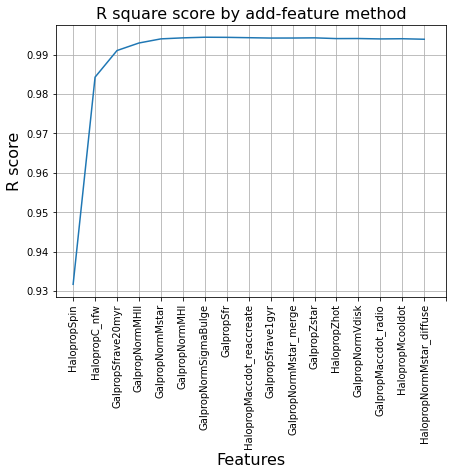

Elapsed time to run RF func on Group 1: 34598.167 seconds
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.995) total time=  35.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.963) total time=   3.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.995) total time=   6.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.987) total time=  17.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  22.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.976, test=0.965) total time=   3.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.977, test=0.966) total time=  21.0s
[CV 2/3] END boot

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.995) total time=  34.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.987) total time=  32.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.975) total time=  19.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.986) total time=  33.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.977, test=0.964) total time=   9.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.993) total time=   6.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.987) total time=  33.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimat

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.995) total time=  34.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.988) total time=  32.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.977, test=0.963) total time=   3.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.974) total time=  19.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.987) total time=   9.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.997) total time=  37.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.975) total time=  19.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_est

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.974) total time=   9.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  17.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.999, test=0.987) total time=   8.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.997) total time=  36.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.974) total time=  20.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.988) total time=  35.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.976) total time=  10.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.977, test=0.966) total time=  19.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   8.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.996) total time=  37.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.977, test=0.963) total time=   9.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.994) total time=   6.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.987) total time=  34.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.976, test=0.963) total time=   9.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimat

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.975) total time=   3.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.995, test=0.995) total time=   6.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.996) total time=  17.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.987) total time=  22.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.977, test=0.962) total time=  19.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.996) total time=   8.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.997) total time=  22.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimat

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.997) total time=  22.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.972) total time=  19.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.996) total time=  34.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.970) total time=  19.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.987) total time=  34.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.974) total time=   9.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.987) total time=  17.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estima

In [42]:
# this code takes 34598.167seconds ~ 9.6hrs to run when the dataset is Group 1 galaxies with 52,053 entries
start_time = time.time()

RF_results_1 = functions.target_predicting_RF_function(X=X_1, y=y_1)

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func on Group 1: {elapsed_time:.3f} seconds")

##### RF best parameters for Group 1, Pure Disk Galaxies with $\frac{M_{bulge}}{M_{star}}$<0.1:

    Best params, best score: 0.9938 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}

#### The most important features for Group 1 galaxies are:  
     1 HalopropSpin 0.9316749236373595
	 2 HalopropC_nfw 0.9843207557546408
	 3 GalpropSfrave20myr 0.9910818401670922
	 4 GalpropNormMHII 0.992994979871547
	 5 GalpropNormMstar 0.9940427165531078
	 6 GalpropNormMHI 0.9943019214926601
	 7 GalpropNormSigmaBulge 0.994460482770335
	 8 GalpropSfr 0.9944317021260475
	 9 HalopropMaccdot_reaccreate 0.9943410958906713
	 10 GalpropSfrave1gyr 0.9942507285793947
	 11 GalpropNormMstar_merge 0.9942589651516193
	 12 GalpropZstar 0.9943024431030104
	 13 HalopropZhot 0.9941144906849857
	 14 GalpropNormVdisk 0.9941315737811508
	 15 GalpropMaccdot_radio 0.9940293979071809
	 16 HalopropMcooldot 0.9940791054443174
	 17 HalopropNormMstar_diffuse 0.9939457432393111

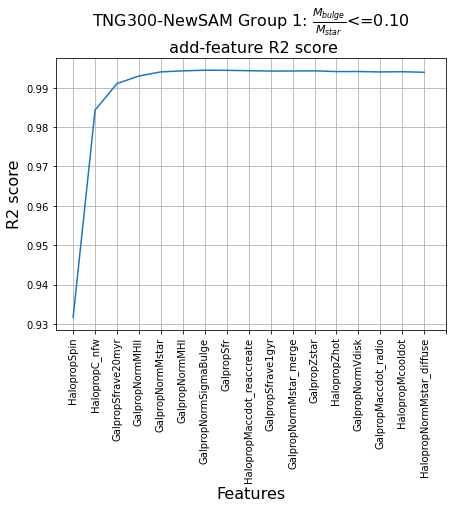

In [52]:
group1_fig_add_feature=RF_results_1[4].plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,18))
group1_fig_add_feature.set_title(label= r'TNG300-NewSAM Group 1: $\frac{M_{bulge}}{M_{star}}$<=0.10' + '\n add-feature R2 score',fontsize=16)
group1_fig_add_feature.set_xlabel('Features',fontsize=16)
group1_fig_add_feature.set_ylabel('R2 score',fontsize=16)

# group1_fig_add_feature.get_figure().savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300_Group_1_R_score_by_add_feature_method.jpg', dpi=500)

plt.show()

In [53]:
# RF_results_1[4].to_csv('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300_Group_1_Max_r_scores_by_add_column_method.csv', index=False)

group1 = pd.read_csv('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300_Group_1_Max_r_scores_by_add_column_method.csv')

group1_fig = RF_results_1[1]
# group1_fig.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300_Group_1_RF_Prediction_vs_True.jpeg', dpi=500)
plt.show()

group1_fig_builtin_imp = RF_results_1[2]
# group1_fig_builtin_imp.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300_Group_1_Built_in_Feature_Ranking.jpeg', dpi=500)
plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.9937 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
RF Accuracy: 0.99 (+/- 0.01)


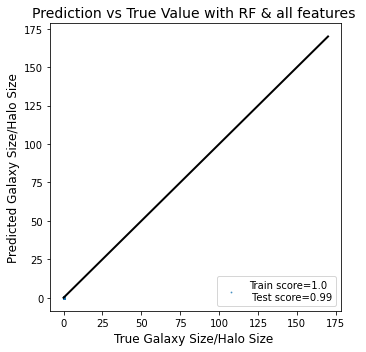

Elapsed time to compute the importances: 0.051 seconds
Elapsed time to compute the importances: 72.180 seconds


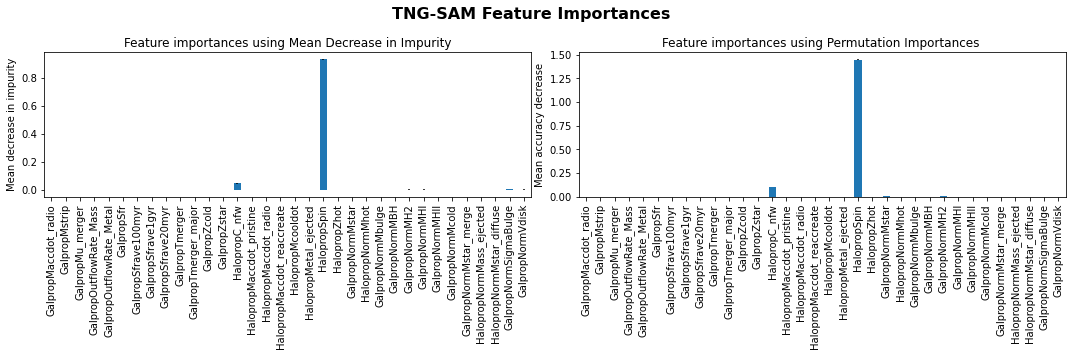

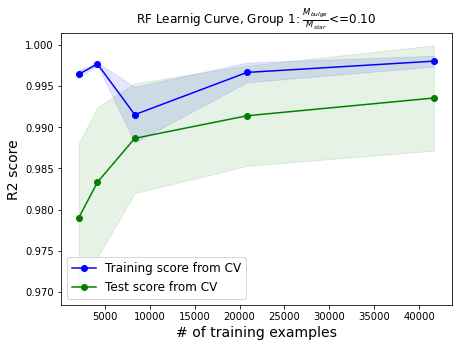

Elapsed time to run RF func and Learning Curves on Group 1 (B/M<=0.10): 1860.550 seconds


In [56]:
# this code takes ~3min to run when the dataset is Group 1 galaxies with ~8,000 entries
start_time = time.time()

RF_lc_1 = tp_lc_functions.target_predicting_RF_function(X_1, y_1, r'RF Learnig Curve, Group 1: $\frac{M_{bulge}}{M_{star}}$<=0.10')

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func and Learning Curves on Group 1 (B/M<=0.10): {elapsed_time:.3f} seconds")

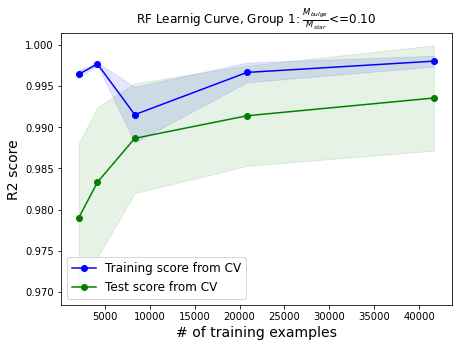

In [57]:
lc_1 = RF_lc_1[4]
# lc_1.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300_Group_1_RF_Learning_Curve.jpeg', dpi=500)
lc_1

### <font color='purple'> <a id =10> </a> <br> SR by morphology: Group 2 Disk Galaxies, 0.1<$\frac{M_{bulge}}{M_{star}}$<0.2

In [60]:
df_2_sample = df_2.sample(n = 30000, random_state = 2023)


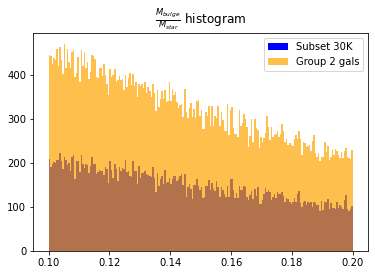

In [64]:
plt.hist(df_2_sample.BulgeMstar_ratio, color='blue', label='Subset 30K', range=(0.1,0.2), bins=200)
plt.hist(df_2.BulgeMstar_ratio,  color='orange', 
         label='Group 2 gals', alpha=0.7, range=(0.1,0.2), bins=200)
plt.title(r'$\frac{M_{bulge}}{M_{star}}$ histogram')
plt.legend()
# plt.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_BulgeMstar_ratio_histogram_all_vs_10kdataset.jpeg', dpi=500)
plt.show()

In [66]:
X_2_sample = df_2_sample.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio',
                         'GalpropNormMdisk', 'DiskMstar_ratio'])
 

y_2_sample = df_2_sample.loc[:,'GalpropNormHalfRadius']

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.9927 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
RF Accuracy: 0.99 (+/- 0.00)


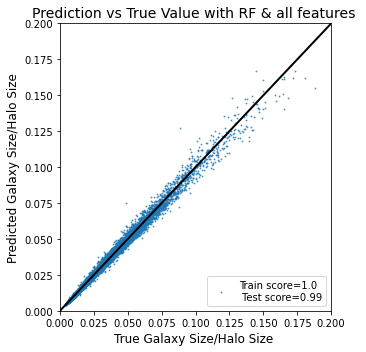

Elapsed time to compute the importances: 0.051 seconds
Elapsed time to compute the importances: 37.238 seconds


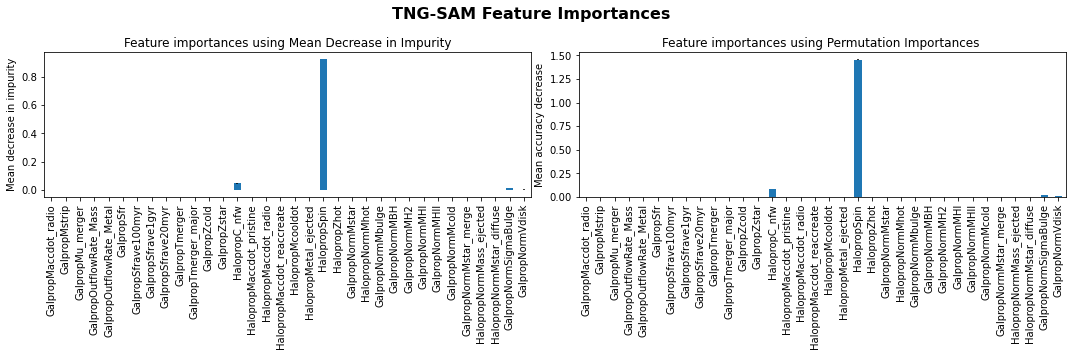

  0%|                                                    | 0/34 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▎                                          | 1/34 [00:03<01:59,  3.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▌                                         | 2/34 [00:09<02:41,  5.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▉                                        | 3/34 [00:15<02:53,  5.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▏                                      | 4/34 [00:21<02:52,  5.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▍                                     | 5/34 [00:27<02:47,  5.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|███████▊                                    | 6/34 [00:33<02:38,  5.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████                                   | 7/34 [00:39<02:37,  5.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▎                                 | 8/34 [00:45<02:33,  5.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▋                                | 9/34 [00:51<02:28,  5.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▋                              | 10/34 [00:56<02:17,  5.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▉                             | 11/34 [00:59<01:52,  4.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▏                           | 12/34 [01:07<02:08,  5.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▍                          | 13/34 [01:13<02:02,  5.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▋                         | 14/34 [01:19<01:57,  5.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▉                        | 15/34 [01:24<01:44,  5.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▏                      | 16/34 [01:27<01:28,  4.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 17/34 [01:34<01:31,  5.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▊                    | 18/34 [01:39<01:25,  5.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████                   | 19/34 [01:44<01:19,  5.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▎                 | 20/34 [01:49<01:13,  5.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▌                | 21/34 [01:55<01:10,  5.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▊               | 22/34 [02:01<01:05,  5.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████              | 23/34 [02:06<01:00,  5.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▎            | 24/34 [02:12<00:54,  5.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▌           | 25/34 [02:13<00:38,  4.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▉          | 26/34 [02:19<00:38,  4.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████▏        | 27/34 [02:25<00:35,  5.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▍       | 28/34 [02:30<00:30,  5.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▋      | 29/34 [02:35<00:25,  5.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▉     | 30/34 [02:41<00:20,  5.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████▏   | 31/34 [02:47<00:16,  5.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▍  | 32/34 [02:51<00:10,  5.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▋ | 33/34 [02:56<00:05,  5.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 34/34 [03:02<00:00,  5.36s/it]


1. iteration: 
	 1 HalopropSpin 0.9258305160643313


  0%|                                                    | 0/33 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▎                                          | 1/33 [00:08<04:34,  8.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▋                                         | 2/33 [00:18<04:50,  9.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████                                        | 3/33 [00:26<04:23,  8.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▎                                      | 4/33 [00:35<04:17,  8.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▋                                     | 5/33 [00:45<04:19,  9.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|████████                                    | 6/33 [00:54<04:07,  9.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▎                                  | 7/33 [01:04<04:05,  9.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▋                                 | 8/33 [01:13<03:52,  9.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|████████████                                | 9/33 [01:21<03:34,  8.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████                              | 10/33 [01:30<03:20,  8.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 11/33 [01:36<02:59,  8.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▋                           | 12/33 [01:46<03:02,  8.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▉                          | 13/33 [01:55<02:56,  8.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▏                        | 14/33 [02:05<02:51,  9.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▌                       | 15/33 [02:12<02:33,  8.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 16/33 [02:21<02:24,  8.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 17/33 [02:31<02:23,  8.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▍                   | 18/33 [02:39<02:10,  8.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▊                  | 19/33 [02:47<02:00,  8.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████                 | 20/33 [02:57<01:57,  9.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▎               | 21/33 [03:07<01:51,  9.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 22/33 [03:17<01:44,  9.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|█████████████████████████████▉             | 23/33 [03:27<01:35,  9.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▎           | 24/33 [03:36<01:25,  9.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▌          | 25/33 [03:46<01:16,  9.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▉         | 26/33 [03:56<01:07,  9.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▏       | 27/33 [04:04<00:56,  9.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▍      | 28/33 [04:13<00:45,  9.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▊     | 29/33 [04:22<00:36,  9.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████    | 30/33 [04:30<00:26,  8.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▍  | 31/33 [04:39<00:17,  8.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▋ | 32/33 [04:49<00:09,  9.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 33/33 [04:58<00:00,  9.06s/it]


2. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956


  0%|                                                    | 0/32 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/32 [00:13<06:47, 13.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 2/32 [00:26<06:40, 13.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████▏                                       | 3/32 [00:40<06:30, 13.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 4/32 [00:53<06:18, 13.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|██████▉                                     | 5/32 [01:07<06:06, 13.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▎                                   | 6/32 [01:21<05:53, 13.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▋                                  | 7/32 [01:34<05:39, 13.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 8/32 [01:48<05:26, 13.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▍                               | 9/32 [02:01<05:12, 13.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▍                             | 10/32 [02:15<04:55, 13.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 34%|██████████████▊                            | 11/32 [02:26<04:30, 12.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▏                          | 12/32 [02:39<04:20, 13.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▍                         | 13/32 [02:53<04:10, 13.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▊                        | 14/32 [03:05<03:51, 12.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▏                      | 15/32 [03:18<03:39, 12.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 16/32 [03:32<03:29, 13.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▊                    | 17/32 [03:45<03:16, 13.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████▏                  | 18/32 [03:58<03:05, 13.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▌                 | 19/32 [04:12<02:53, 13.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 20/32 [04:26<02:40, 13.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 66%|████████████████████████████▏              | 21/32 [04:39<02:27, 13.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▌             | 22/32 [04:52<02:14, 13.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▉            | 23/32 [05:06<02:00, 13.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 24/32 [05:19<01:47, 13.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▌         | 25/32 [05:33<01:34, 13.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▉        | 26/32 [05:46<01:21, 13.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████▎      | 27/32 [06:00<01:07, 13.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 28/32 [06:14<00:54, 13.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|██████████████████████████████████████▉    | 29/32 [06:27<00:40, 13.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▎  | 30/32 [06:40<00:26, 13.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▋ | 31/32 [06:54<00:13, 13.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 32/32 [07:07<00:00, 13.36s/it]


3. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439


  0%|                                                    | 0/31 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/31 [00:18<09:06, 18.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 2/31 [00:36<08:52, 18.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▎                                       | 3/31 [00:53<08:17, 17.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 4/31 [01:12<08:08, 18.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 5/31 [01:30<07:54, 18.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▌                                   | 6/31 [01:49<07:38, 18.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|█████████▉                                  | 7/31 [02:08<07:22, 18.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▎                                | 8/31 [02:26<07:04, 18.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▊                               | 9/31 [02:45<06:46, 18.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▊                             | 10/31 [03:01<06:15, 17.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                           | 11/31 [03:16<05:41, 17.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▋                          | 12/31 [03:35<05:32, 17.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████                         | 13/31 [03:53<05:20, 17.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▍                       | 14/31 [04:09<04:52, 17.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 15/31 [04:27<04:40, 17.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 16/31 [04:46<04:27, 17.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▌                   | 17/31 [05:04<04:10, 17.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▉                  | 18/31 [05:23<03:55, 18.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▎                | 19/31 [05:41<03:39, 18.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▋               | 20/31 [06:00<03:21, 18.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 21/31 [06:19<03:04, 18.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▌            | 22/31 [06:37<02:46, 18.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▉           | 23/31 [06:54<02:24, 18.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████▎         | 24/31 [07:13<02:07, 18.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 25/31 [07:31<01:50, 18.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████       | 26/31 [07:50<01:31, 18.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▍     | 27/31 [08:08<01:13, 18.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▊    | 28/31 [08:27<00:55, 18.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▏  | 29/31 [08:46<00:37, 18.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 30/31 [09:05<00:18, 18.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 31/31 [09:22<00:00, 18.13s/it]


4. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854


  0%|                                                    | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/30 [00:22<10:48, 22.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|██▉                                         | 2/30 [00:45<10:31, 22.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 3/30 [01:07<10:10, 22.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▊                                      | 4/30 [01:30<09:48, 22.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 5/30 [01:53<09:28, 22.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 6/30 [02:16<09:07, 22.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▎                                 | 7/30 [02:38<08:42, 22.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▋                                | 8/30 [03:01<08:18, 22.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 9/30 [03:23<07:55, 22.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 10/30 [03:46<07:29, 22.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▊                           | 11/30 [04:06<06:56, 21.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 12/30 [04:29<06:38, 22.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▋                        | 13/30 [04:51<06:19, 22.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████                       | 14/30 [05:13<05:52, 22.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 15/30 [05:35<05:31, 22.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▉                    | 16/30 [05:58<05:12, 22.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 17/30 [06:20<04:49, 22.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 18/30 [06:43<04:29, 22.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████▏               | 19/30 [07:06<04:07, 22.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 20/30 [07:28<03:45, 22.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████             | 21/30 [07:51<03:23, 22.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▌           | 22/30 [08:14<03:01, 22.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|████████████████████████████████▉          | 23/30 [08:36<02:37, 22.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 24/30 [08:59<02:15, 22.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 25/30 [09:21<01:52, 22.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▎     | 26/30 [09:44<01:30, 22.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▋    | 27/30 [10:07<01:07, 22.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.012, test=0.001) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.028, test=-0.014) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.029, test=-0.010) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.031, test=-0.010) total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.049, test=0.034) total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.106, test=0.033) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.376, test=-0.174) total time=   2.3s
[CV 1

 93%|████████████████████████████████████████▏  | 28/30 [10:29<00:45, 22.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 29/30 [10:52<00:22, 22.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 30/30 [11:14<00:00, 22.49s/it]


5. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.012, test=0.001) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.014, test=-0.003) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.028, test=-0.014) total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.049, test=0.034) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.109, test=0.029) total time=   1.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.012, test=-0.001) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.453, test=-0.232) total time=   0.8s
[CV 1/3] 

  3%|█▌                                          | 1/29 [00:26<12:14, 26.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.026, test=-0.006) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.031, test=-0.022) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.029, test=-0.015) total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.050, test=0.035) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.101, test=0.031) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.103, test=0.032) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.365, test=-0.179) total time=   0.6s
[CV 2/

  7%|███                                         | 2/29 [00:52<11:55, 26.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.015, test=-0.005) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.023, test=-0.011) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.027, test=-0.016) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.024, test=-0.008) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.048, test=0.034) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.105, test=0.021) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.107, test=0.028) total time=   0.9s
[CV 1/3] END 

 10%|████▌                                       | 3/29 [01:19<11:32, 26.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.011, test=0.001) total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.024, test=-0.009) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.030, test=-0.010) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.045, test=0.042) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.050, test=0.036) total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.376, test=-0.212) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.375, test=-0.170) total time=   2.5s
[CV 2/3

 14%|██████                                      | 4/29 [01:46<11:06, 26.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▌                                    | 5/29 [02:13<10:39, 26.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.011, test=0.001) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.026, test=-0.005) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.045, test=0.042) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.107, test=0.024) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.108, test=0.023) total time=   1.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.011, test=-0.001) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.011, test=0.000) total time=   1.0s
[CV 2/3] END b

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.014, test=-0.003) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.026, test=-0.005) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.028, test=-0.016) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.032, test=-0.021) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.046, test=0.042) total time=   1.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.365, test=-0.187) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.373, test=-0.173) total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, 

 21%|█████████                                   | 6/29 [02:39<10:11, 26.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.011, test=0.000) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.012, test=0.001) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.027, test=-0.018) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.032, test=-0.021) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.050, test=0.035) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.107, test=0.023) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.383, test=-0.203) total time=   1.5s
[CV 3/3] 

 24%|██████████▌                                 | 7/29 [03:06<09:46, 26.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▏                               | 8/29 [03:33<09:20, 26.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▋                              | 9/29 [03:59<08:52, 26.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 34%|██████████████▊                            | 10/29 [04:25<08:23, 26.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▎                          | 11/29 [04:50<07:46, 25.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▊                         | 12/29 [05:16<07:23, 26.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▎                       | 13/29 [05:43<06:59, 26.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 14/29 [06:08<06:29, 25.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 15/29 [06:35<06:04, 26.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▋                   | 16/29 [07:01<05:40, 26.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▏                 | 17/29 [07:27<05:14, 26.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▋                | 18/29 [07:54<04:48, 26.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 66%|████████████████████████████▏              | 19/29 [08:20<04:23, 26.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▋             | 20/29 [08:47<03:58, 26.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|███████████████████████████████▏           | 21/29 [09:14<03:31, 26.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▌          | 22/29 [09:40<03:04, 26.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 23/29 [10:06<02:38, 26.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▌       | 24/29 [10:33<02:12, 26.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|█████████████████████████████████████      | 25/29 [10:59<01:45, 26.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▌    | 26/29 [11:26<01:19, 26.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████   | 27/29 [11:53<00:53, 26.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 28/29 [12:20<00:26, 26.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 29/29 [12:46<00:00, 26.44s/it]


6. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▌                                          | 1/28 [00:30<13:32, 30.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███▏                                        | 2/28 [01:00<13:09, 30.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▋                                       | 3/28 [01:31<12:41, 30.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████▎                                     | 4/28 [02:01<12:09, 30.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|███████▊                                    | 5/28 [02:32<11:41, 30.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▍                                  | 6/28 [03:02<11:10, 30.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 7/28 [03:33<10:39, 30.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                               | 8/28 [04:03<10:08, 30.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████▏                             | 9/28 [04:33<09:38, 30.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▎                           | 10/28 [05:03<09:05, 30.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▉                          | 11/28 [05:32<08:25, 29.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▍                        | 12/28 [06:02<07:59, 29.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▉                       | 13/28 [06:33<07:30, 30.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 14/28 [07:02<06:56, 29.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████                    | 15/28 [07:32<06:28, 29.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 16/28 [08:02<06:00, 30.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████                 | 17/28 [08:33<05:33, 30.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▋               | 18/28 [09:04<05:04, 30.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 19/28 [09:35<04:35, 30.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 20/28 [10:06<04:05, 30.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 21/28 [10:36<03:34, 30.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▊         | 22/28 [11:06<03:02, 30.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▎       | 23/28 [11:37<02:32, 30.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 24/28 [12:08<02:02, 30.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▍    | 25/28 [12:38<01:31, 30.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▉   | 26/28 [13:09<01:01, 30.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 27/28 [13:39<00:30, 30.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 28/28 [14:05<00:00, 30.18s/it]


7. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816
	 7 GalpropSfrave100myr 0.9932625439143724


  0%|                                                    | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/27 [00:34<14:50, 34.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███▎                                        | 2/27 [01:08<14:19, 34.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▉                                       | 3/27 [01:43<13:46, 34.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                     | 4/27 [02:17<13:11, 34.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▏                                   | 5/27 [02:52<12:37, 34.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▊                                  | 6/27 [03:26<12:01, 34.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▍                                | 7/27 [04:00<11:27, 34.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████                               | 8/27 [04:35<10:52, 34.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 9/27 [05:08<10:15, 34.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▉                           | 10/27 [05:41<09:33, 33.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▌                         | 11/27 [06:16<09:04, 34.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████                        | 12/27 [06:50<08:32, 34.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▋                      | 13/27 [07:24<07:55, 33.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 14/27 [07:58<07:22, 34.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|███████████████████████▉                   | 15/27 [08:33<06:51, 34.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 16/27 [09:07<06:17, 34.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████                | 17/27 [09:42<05:43, 34.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 18/27 [10:16<05:10, 34.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████▎            | 19/27 [10:51<04:35, 34.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▊           | 20/27 [11:25<04:01, 34.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▍         | 21/27 [12:00<03:26, 34.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|███████████████████████████████████        | 22/27 [12:34<02:51, 34.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▋      | 23/27 [13:08<02:17, 34.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▏    | 24/27 [13:43<01:43, 34.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▊   | 25/27 [14:17<01:08, 34.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 26/27 [14:52<00:34, 34.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 27/27 [15:26<00:00, 34.32s/it]


8. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816
	 7 GalpropSfrave100myr 0.9932625439143724
	 8 GalpropSfr 0.9932127807831845


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/26 [00:38<15:53, 38.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▍                                        | 2/26 [01:16<15:17, 38.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████                                       | 3/26 [01:54<14:40, 38.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▊                                     | 4/26 [02:33<14:03, 38.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▍                                   | 5/26 [03:11<13:26, 38.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▏                                 | 6/26 [03:50<12:48, 38.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▊                                | 7/26 [04:28<12:08, 38.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▌                              | 8/26 [05:06<11:28, 38.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▏                            | 9/26 [05:42<10:41, 37.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                          | 10/26 [06:21<10:06, 37.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▏                        | 11/26 [06:59<09:30, 38.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▊                       | 12/26 [07:36<08:48, 37.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 13/26 [08:14<08:11, 37.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████▏                   | 14/26 [08:52<07:35, 37.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▊                  | 15/26 [09:31<06:57, 38.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▍                | 16/26 [10:09<06:20, 38.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|████████████████████████████               | 17/26 [10:47<05:43, 38.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▊             | 18/26 [11:25<05:05, 38.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▍           | 19/26 [12:03<04:27, 38.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████          | 20/26 [12:41<03:48, 38.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 21/26 [13:20<03:10, 38.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▍      | 22/26 [13:58<02:32, 38.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|██████████████████████████████████████     | 23/26 [14:36<01:54, 38.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▋   | 24/26 [15:15<01:16, 38.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▎ | 25/26 [15:53<00:38, 38.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 26/26 [16:32<00:00, 38.16s/it]


9. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816
	 7 GalpropSfrave100myr 0.9932625439143724
	 8 GalpropSfr 0.9932127807831845
	 9 GalpropNormMbulge 0.9931604544157736


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                          | 1/25 [00:41<16:47, 41.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▌                                        | 2/25 [01:24<16:10, 42.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▎                                      | 3/25 [02:06<15:32, 42.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 4/25 [02:49<14:48, 42.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 5/25 [03:31<14:05, 42.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 6/25 [04:13<13:21, 42.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▎                               | 7/25 [04:55<12:38, 42.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 8/25 [05:37<11:53, 41.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▊                            | 9/25 [06:17<11:03, 41.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 10/25 [06:59<10:25, 41.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▉                        | 11/25 [07:41<09:46, 41.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▋                      | 12/25 [08:22<09:01, 41.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 13/25 [09:04<08:20, 41.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████                   | 14/25 [09:47<07:40, 41.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 15/25 [10:29<07:00, 42.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▌               | 16/25 [11:11<06:19, 42.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 17/25 [11:54<05:37, 42.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▉            | 18/25 [12:36<04:56, 42.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▋          | 19/25 [13:18<04:13, 42.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 20/25 [14:01<03:31, 42.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████       | 21/25 [14:43<02:49, 42.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▊     | 22/25 [15:25<02:06, 42.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▌   | 23/25 [16:08<01:24, 42.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▎ | 24/25 [16:50<00:42, 42.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 25/25 [17:32<00:00, 42.12s/it]


10. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816
	 7 GalpropSfrave100myr 0.9932625439143724
	 8 GalpropSfr 0.9932127807831845
	 9 GalpropNormMbulge 0.9931604544157736
	 10 GalpropTmerger 0.9931019970569


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                          | 1/24 [00:45<17:22, 45.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▋                                        | 2/24 [01:31<16:47, 45.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 3/24 [02:17<16:03, 45.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 4/24 [03:03<15:16, 45.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▏                                  | 5/24 [03:48<14:30, 45.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 6/24 [04:34<13:43, 45.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.990) total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.992) total time=   5.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.971) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.972) total time=   3.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.992) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.993) total time=   6.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.971) total time=   1.9s
[CV 2/3] END

 29%|████████████▊                               | 7/24 [05:20<12:57, 45.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 8/24 [06:04<12:02, 45.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                           | 9/24 [06:50<11:21, 45.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.992) total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.993) total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.970) total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.991) total time=   6.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.969) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.991) total time=   3.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.992) total time=   1.6s
[CV 2/3] E

 42%|█████████████████▉                         | 10/24 [07:36<10:38, 45.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▋                       | 11/24 [08:20<09:49, 45.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.992) total time=   3.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.970) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.970) total time=   3.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.992) total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.993) total time=   6.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.970) total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.990) total time=   1.3s
[CV 1/3] EN

 50%|█████████████████████▌                     | 12/24 [09:06<09:04, 45.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.970) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.992) total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.991) total time=   3.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.992) total time=   4.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.969) total time=   3.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.992) total time=   6.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.969) total time=   1.8s
[CV 3/3] END bo

 54%|███████████████████████▎                   | 13/24 [09:52<08:21, 45.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.992) total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.972) total time=   3.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.992) total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.993) total time=   4.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.969) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.992) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.992) total time=   6.5s
[CV 3/3] E

 58%|█████████████████████████                  | 14/24 [10:38<07:35, 45.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.969) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.970) total time=   3.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.992) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.994) total time=   6.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.971) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.991) total time=   3.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.992) total time=   4.1s
[CV 1/3] EN

 62%|██████████████████████████▉                | 15/24 [11:23<06:51, 45.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.991) total time=   6.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.973, test=0.971) total time=   3.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.991) total time=   6.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.970) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.991) total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.991) total time=   6.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.972) total time=   3.7s
[CV 3/3] END b

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.971) total time=   3.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.992) total time=   6.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.969) total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.991) total time=   5.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.968) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.991) total time=   1.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.992) total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimato

 67%|████████████████████████████▋              | 16/24 [12:09<06:05, 45.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▍            | 17/24 [12:55<05:20, 45.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 18/24 [13:41<04:33, 45.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 19/24 [14:26<03:48, 45.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 20/24 [15:12<03:02, 45.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 21/24 [15:58<02:17, 45.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▍   | 22/24 [16:44<01:31, 45.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 23/24 [17:30<00:45, 45.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 24/24 [18:16<00:00, 45.67s/it]


11. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816
	 7 GalpropSfrave100myr 0.9932625439143724
	 8 GalpropSfr 0.9932127807831845
	 9 GalpropNormMbulge 0.9931604544157736
	 10 GalpropTmerger 0.9931019970569
	 11 HalopropMaccdot_radio 0.9930902823604514


  0%|                                                    | 0/23 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▉                                          | 1/23 [00:49<18:06, 49.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▊                                        | 2/23 [01:38<17:14, 49.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 3/23 [02:28<16:27, 49.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▋                                    | 4/23 [03:17<15:38, 49.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▌                                  | 5/23 [04:06<14:48, 49.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▍                                | 6/23 [04:56<13:58, 49.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▍                              | 7/23 [05:45<13:08, 49.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                            | 8/23 [06:32<12:10, 48.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|█████████████████▏                          | 9/23 [07:22<11:24, 48.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▋                        | 10/23 [08:11<10:36, 48.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▌                      | 11/23 [08:59<09:43, 48.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▍                    | 12/23 [09:39<08:28, 46.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 13/23 [10:29<07:51, 47.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▏                | 14/23 [11:18<07:10, 47.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|████████████████████████████               | 15/23 [12:08<06:26, 48.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|█████████████████████████████▉             | 16/23 [12:57<05:41, 48.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▊           | 17/23 [13:38<04:38, 46.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▋         | 18/23 [14:28<03:57, 47.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▌       | 19/23 [15:17<03:12, 48.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▍     | 20/23 [16:07<02:25, 48.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████▎   | 21/23 [16:56<01:37, 48.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 22/23 [17:46<00:48, 48.96s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 23/23 [18:35<00:00, 48.50s/it]


12. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816
	 7 GalpropSfrave100myr 0.9932625439143724
	 8 GalpropSfr 0.9932127807831845
	 9 GalpropNormMbulge 0.9931604544157736
	 10 GalpropTmerger 0.9931019970569
	 11 HalopropMaccdot_radio 0.9930902823604514
	 12 HalopropMaccdot_pristine 0.99327063583923


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                          | 1/22 [00:51<18:06, 51.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████                                        | 2/22 [01:43<17:16, 51.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████                                      | 3/22 [02:35<16:28, 52.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|████████                                    | 4/22 [03:28<15:38, 52.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████                                  | 5/22 [04:20<14:45, 52.11s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|████████████                                | 6/22 [05:12<13:54, 52.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 7/22 [06:04<13:01, 52.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|████████████████                            | 8/22 [06:54<12:00, 51.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|██████████████████                          | 9/22 [07:46<11:11, 51.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▌                       | 10/22 [08:38<10:21, 51.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 11/22 [09:30<09:30, 51.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▍                   | 12/22 [10:22<08:38, 51.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 13/22 [11:14<07:47, 51.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▎               | 14/22 [12:06<06:55, 51.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▎             | 15/22 [12:58<06:03, 51.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▎           | 16/22 [13:50<05:11, 51.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████▏         | 17/22 [14:42<04:19, 51.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▏       | 18/22 [15:34<03:27, 51.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|█████████████████████████████████████▏     | 19/22 [16:26<02:35, 51.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████    | 20/22 [17:18<01:44, 52.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|█████████████████████████████████████████  | 21/22 [18:10<00:52, 52.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 22/22 [19:02<00:00, 51.95s/it]


13. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816
	 7 GalpropSfrave100myr 0.9932625439143724
	 8 GalpropSfr 0.9932127807831845
	 9 GalpropNormMbulge 0.9931604544157736
	 10 GalpropTmerger 0.9931019970569
	 11 HalopropMaccdot_radio 0.9930902823604514
	 12 HalopropMaccdot_pristine 0.99327063583923
	 13 HalopropMetal_ejected 0.9930133231871304


  0%|                                                    | 0/21 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                          | 1/21 [00:55<18:37, 55.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▏                                       | 2/21 [01:52<17:44, 56.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████▎                                     | 3/21 [02:48<16:48, 56.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▍                                   | 4/21 [03:44<15:52, 56.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▍                                 | 5/21 [04:39<14:54, 55.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                               | 6/21 [05:35<13:57, 55.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 7/21 [06:31<13:03, 55.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▊                           | 8/21 [07:25<11:59, 55.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▊                         | 9/21 [08:21<11:06, 55.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▍                      | 10/21 [09:17<10:13, 55.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▌                    | 11/21 [10:14<09:18, 55.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 12/21 [11:09<08:23, 55.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▌                | 13/21 [12:06<07:28, 56.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 14/21 [13:02<06:32, 56.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 15/21 [13:58<05:35, 55.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▊          | 16/21 [14:54<04:39, 55.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▊        | 17/21 [15:50<03:44, 56.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 18/21 [16:46<02:48, 56.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▉    | 19/21 [17:42<01:52, 56.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████▉  | 20/21 [18:38<00:56, 56.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 21/21 [19:34<00:00, 55.93s/it]


14. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816
	 7 GalpropSfrave100myr 0.9932625439143724
	 8 GalpropSfr 0.9932127807831845
	 9 GalpropNormMbulge 0.9931604544157736
	 10 GalpropTmerger 0.9931019970569
	 11 HalopropMaccdot_radio 0.9930902823604514
	 12 HalopropMaccdot_pristine 0.99327063583923
	 13 HalopropMetal_ejected 0.9930133231871304
	 14 HalopropNormMhot 0.993156375378475


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██▏                                         | 1/20 [00:59<18:46, 59.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 2/20 [01:58<17:50, 59.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                     | 3/20 [02:57<16:45, 59.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 4/20 [03:56<15:44, 59.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 5/20 [04:55<14:43, 58.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 6/20 [05:54<13:44, 58.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▍                            | 7/20 [06:53<12:46, 58.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▌                          | 8/20 [07:51<11:43, 58.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▊                        | 9/20 [08:50<10:46, 58.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 10/20 [09:49<09:48, 58.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▋                   | 11/20 [10:48<08:50, 58.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 12/20 [12:44<10:10, 76.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▎              | 13/20 [30:14<43:19, 371.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.991) total time=  12.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.971) total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.991) total time=   6.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.993) total time=   7.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.975, test=0.972) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.992) total time=   2.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.992) total time=   6.0s
[CV 2/3] END bo

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.972) total time=   7.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.991) total time=  12.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.971) total time=   7.0s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.991) total time=  12.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.973) total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.992) total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.992) total time=  12.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators

 70%|█████████████████████████████▍            | 14/20 [47:16<56:46, 567.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.967) total time=   3.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.993) total time=   6.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.993) total time=   7.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.973) total time=   7.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.992) total time=   3.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.992) total time=   7.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.971) total time=   1.4s
[CV 2/3] END

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.971) total time=   4.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.992) total time=   7.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.992) total time=   8.8s


 75%|██████████████████████████████          | 15/20 [1:03:09<57:00, 684.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|████████████████████████████████        | 16/20 [1:20:47<53:05, 796.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|██████████████████████████████████      | 17/20 [1:36:52<42:21, 847.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|████████████████████████████████████    | 18/20 [1:49:49<27:32, 826.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|██████████████████████████████████████  | 19/20 [1:50:49<09:55, 595.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|████████████████████████████████████████| 20/20 [1:51:47<00:00, 335.36s/it]


15. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816
	 7 GalpropSfrave100myr 0.9932625439143724
	 8 GalpropSfr 0.9932127807831845
	 9 GalpropNormMbulge 0.9931604544157736
	 10 GalpropTmerger 0.9931019970569
	 11 HalopropMaccdot_radio 0.9930902823604514
	 12 HalopropMaccdot_pristine 0.99327063583923
	 13 HalopropMetal_ejected 0.9930133231871304
	 14 HalopropNormMhot 0.993156375378475
	 15 GalpropZstar 0.9929838870656383


  0%|                                                    | 0/19 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.972) total time=   4.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.991) total time=   7.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.993) total time=   8.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.970) total time=   1.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.991) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.991) total time=   7.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.993) total time=   3.7s
[CV 2/3] END b

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.970) total time=   4.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.992) total time=17.0min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.993) total time=  14.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.969) total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.972, test=0.969) total time=   8.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.993) total time=15.2min
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.998, test=0.993) total time=  15.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estim

  5%|██                                      | 1/19 [28:40<8:36:09, 1720.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.991) total time=   2.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.992) total time=  12.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.971) total time=   3.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.991) total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.996, test=0.992) total time=  12.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.967) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.991) total time=   2.3s
[CV 3/3] END boo

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.970) total time=17.9min
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.997, test=0.991) total time=   3.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.991) total time= 5.8min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.971) total time=18.0min
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.991) total time= 5.8min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.971) total time=18.0min
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.993) total time= 4.9min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estima

 11%|███▉                                 | 2/19 [1:59:30<18:28:58, 3914.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.972) total time=17.9min
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.991) total time= 5.0min
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.993) total time=  49.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.968) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.972) total time=17.1min
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.993) total time= 6.3min
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.992) total time=  16.5s
[CV 3/3] EN

 16%|█████▊                               | 3/19 [2:54:04<16:05:53, 3622.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|████████                              | 4/19 [2:56:05<9:19:54, 2239.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|██████████                            | 5/19 [2:57:03<5:39:03, 1453.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|████████████▎                          | 6/19 [2:58:01<3:32:05, 978.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|██████████████▎                        | 7/19 [2:59:00<2:15:36, 678.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|████████████████▍                      | 8/19 [2:59:58<1:28:05, 480.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|███████████████████▍                     | 9/19 [3:00:58<58:13, 349.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|█████████████████████                   | 10/19 [3:01:58<38:58, 259.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|███████████████████████▏                | 11/19 [3:02:58<26:30, 198.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|█████████████████████████▎              | 12/19 [3:04:00<18:19, 157.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|███████████████████████████▎            | 13/19 [3:05:00<12:46, 127.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|█████████████████████████████▍          | 14/19 [3:06:00<08:56, 107.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|████████████████████████████████▎        | 15/19 [3:07:00<06:12, 93.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|██████████████████████████████████▌      | 16/19 [3:08:01<04:09, 83.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|████████████████████████████████████▋    | 17/19 [3:09:01<02:32, 76.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|██████████████████████████████████████▊  | 18/19 [3:10:01<01:11, 71.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|████████████████████████████████████████| 19/19 [3:11:02<00:00, 603.29s/it]


16. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816
	 7 GalpropSfrave100myr 0.9932625439143724
	 8 GalpropSfr 0.9932127807831845
	 9 GalpropNormMbulge 0.9931604544157736
	 10 GalpropTmerger 0.9931019970569
	 11 HalopropMaccdot_radio 0.9930902823604514
	 12 HalopropMaccdot_pristine 0.99327063583923
	 13 HalopropMetal_ejected 0.9930133231871304
	 14 HalopropNormMhot 0.993156375378475
	 15 GalpropZstar 0.9929838870656383
	 16 HalopropZhot 0.9929486689103625


  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▍                                         | 1/18 [01:03<17:55, 63.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▉                                       | 2/18 [02:06<16:54, 63.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 3/18 [03:10<15:55, 63.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▊                                  | 4/18 [04:15<14:54, 63.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▏                               | 5/18 [05:19<13:51, 63.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 6/18 [06:23<12:49, 64.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|█████████████████                           | 7/18 [07:27<11:44, 64.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████▌                        | 8/18 [08:29<10:35, 63.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|██████████████████████                      | 9/18 [09:33<09:31, 63.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|███████████████████████▉                   | 10/18 [10:37<08:28, 63.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▎                | 11/18 [11:40<07:24, 63.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 12/18 [12:44<06:22, 63.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|███████████████████████████████            | 13/18 [13:48<05:18, 63.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▍         | 14/18 [14:52<04:15, 63.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 15/18 [16:29<03:41, 73.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▏    | 16/18 [17:31<02:20, 70.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▌  | 17/18 [18:36<01:08, 68.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 18/18 [19:29<00:00, 64.98s/it]


17. iteration: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816
	 7 GalpropSfrave100myr 0.9932625439143724
	 8 GalpropSfr 0.9932127807831845
	 9 GalpropNormMbulge 0.9931604544157736
	 10 GalpropTmerger 0.9931019970569
	 11 HalopropMaccdot_radio 0.9930902823604514
	 12 HalopropMaccdot_pristine 0.99327063583923
	 13 HalopropMetal_ejected 0.9930133231871304
	 14 HalopropNormMhot 0.993156375378475
	 15 GalpropZstar 0.9929838870656383
	 16 HalopropZhot 0.9929486689103625
	 17 GalpropSfrave1gyr 0.9928925917587633


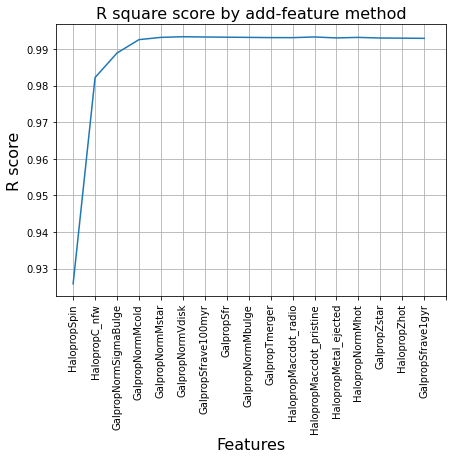

Elapsed time to run RF func on Group 2: 31455.852 seconds
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.969) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.992) total time=   3.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.991) total time= 1.3min
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.992) total time=  15.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.972) total time=   9.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.991) total time=  15.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.973, test=0.970) total time=   4.9s
[CV 1/3] END bo

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.971) total time=   4.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.996, test=0.991) total time=   8.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.992) total time= 1.2min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.973, test=0.969) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.972) total time=   9.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.992) total time=   4.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.993) total time=  16.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimat

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.973) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.990) total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.992) total time=   8.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.998, test=0.993) total time= 1.2min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.972) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.992) total time=   3.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.992) total time=  15.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimato

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.974) total time=   9.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.991) total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.992) total time= 1.2min
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.970) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.991) total time=   3.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.991) total time=   8.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.993) total time=   9.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimat

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.973) total time=17.0min
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.992) total time= 6.4min
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.992) total time=   9.6s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.974, test=0.970) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.968) total time=   9.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.993) total time=   3.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.992) total time= 1.3min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimat

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.973) total time=   4.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.991) total time=   7.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.992) total time=   3.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.993) total time= 1.3min
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.972) total time=   4.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.991) total time=   3.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.992) total time=  15.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimato

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.968) total time=   4.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.996, test=0.991) total time=   3.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.992) total time= 1.3min
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.975, test=0.971) total time=   4.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.992) total time=   8.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.998, test=0.992) total time=   4.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.999, test=0.993) total time=  15.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimato

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.975, test=0.971) total time=   9.4s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.997, test=0.991) total time= 1.3min
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.974, test=0.971) total time=   5.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.997, test=0.992) total time=   8.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.999, test=0.993) total time=   9.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.972, test=0.967) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.974, test=0.970) total time=   9.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimato

In [67]:
# this code takes 34598.167seconds ~ 9.6hrs to run when the dataset is Group 1 galaxies with 52,053 entries
start_time = time.time()

RF_results_2 = functions.target_predicting_RF_function(X=X_2_sample, y=y_2_sample)

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func on Group 2: {elapsed_time:.3f} seconds")

##### RF best parameters for Group 2, Pure Disk Galaxies with 0.1<$\frac{M_{bulge}}{M_{star}}$<0.2:

Fitting 5 folds for each of 27 candidates, totalling 135 fits
        
        Best params, best score: 0.9927 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
RF Accuracy: 0.99 (+/- 0.00)

#### The most important features for Group 2 galaxies are: 
	 1 HalopropSpin 0.9258305160643313
	 2 HalopropC_nfw 0.9821933582638956
	 3 GalpropNormSigmaBulge 0.9888880226905439
	 4 GalpropNormMcold 0.9925435135828854
	 5 GalpropNormMstar 0.9931640719986204
	 6 GalpropNormVdisk 0.9933384945449816
	 7 GalpropSfrave100myr 0.9932625439143724
	 8 GalpropSfr 0.9932127807831845
	 9 GalpropNormMbulge 0.9931604544157736
	 10 GalpropTmerger 0.9931019970569
	 11 HalopropMaccdot_radio 0.9930902823604514
	 12 HalopropMaccdot_pristine 0.99327063583923
	 13 HalopropMetal_ejected 0.9930133231871304
	 14 HalopropNormMhot 0.993156375378475
	 15 GalpropZstar 0.9929838870656383
	 16 HalopropZhot 0.9929486689103625
	 17 GalpropSfrave1gyr 0.9928925917587633

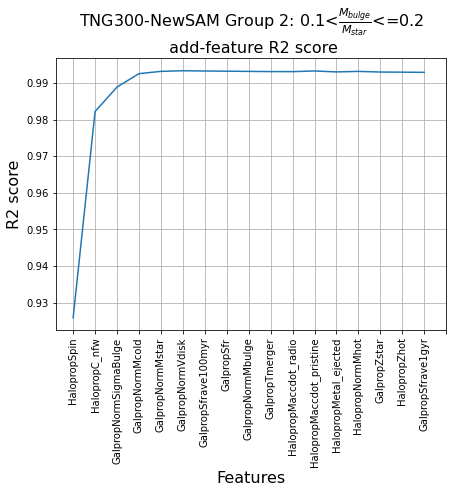

In [69]:
group2_fig_add_feature=RF_results_2[4].plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,18))
group2_fig_add_feature.set_title(label= r'TNG300-NewSAM Group 2: 0.1<$\frac{M_{bulge}}{M_{star}}$<=0.2' + '\n add-feature R2 score',fontsize=16)
group2_fig_add_feature.set_xlabel('Features',fontsize=16)
group2_fig_add_feature.set_ylabel('R2 score',fontsize=16)

# group2_fig_add_feature.get_figure().savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300_Group_2_R_score_by_add_feature_method.jpg', dpi=500)

plt.show()

In [70]:
# RF_results_2[4].to_csv('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300_Group_2_Max_r_scores_by_add_column_method.csv', index=False)

group2 = pd.read_csv('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300_Group_2_Max_r_scores_by_add_column_method.csv')

group2_fig = RF_results_2[1]
group2_fig.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300_Group_2_RF_Prediction_vs_True.jpeg', dpi=500)
plt.show()

group2_fig_builtin_imp = RF_results_2[2]
# group2_fig_builtin_imp.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300_Group_2_Built_in_Feature_Ranking.jpeg', dpi=500)
plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.9926 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
RF Accuracy: 0.99 (+/- 0.00)


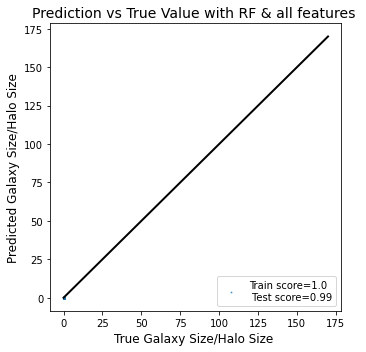

Elapsed time to compute the importances: 0.091 seconds


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Elapsed time to compute the importances: 5745.738 seconds


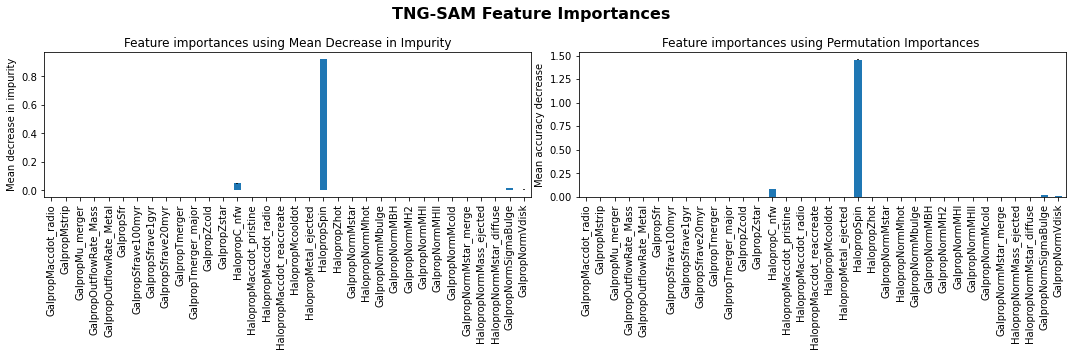

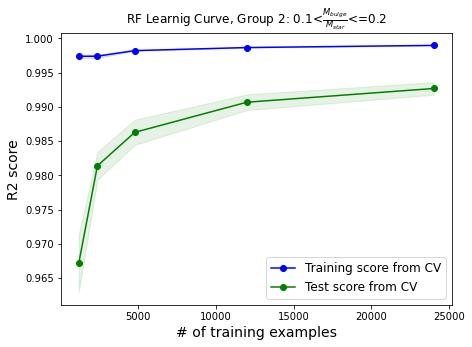

Elapsed time to run RF func and Learning Curves on Group 2 (0.1<B/M<=0.2): 24356.047 seconds


In [73]:
# this code takes ~6.7hrs (while computer is in sleep mode) to run when the dataset is Group 2 galaxies with a subset of ~30,000 entries (out of ~64,000 total)
start_time = time.time()

RF_lc_2 = tp_lc_functions.target_predicting_RF_function(X_2_sample, y_2_sample, r'RF Learnig Curve, Group 2: 0.1<$\frac{M_{bulge}}{M_{star}}$<=0.2')

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func and Learning Curves on Group 2 (0.1<B/M<=0.2): {elapsed_time:.3f} seconds")

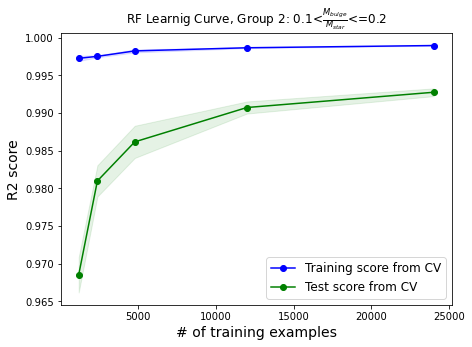

In [72]:
lc_2 = RF_lc_2[4]
# lc_2.savefig('TNG300-SAM_images/v4_TNG300-SAM_wo_DISKgals_w_smallfdisk/v4_TNG300_Group_2_RF_Learning_Curve.jpeg', dpi=500)
lc_2